In [ ]:
from scipy.integrate import solve_ivp, odeint
import sys
import time 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 140
import random
from collections import OrderedDict
from shapely.geometry import Polygon, LineString, Point
np.set_printoptions(linewidth=100)


renata_shape_file_relevant_column = gpd.read_file("./data/china_codes/spatial_match.shp") #shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code", "pop_2020", "ADM2_EN", "geometry"]])
tp_df.columns = ['tile_ID', 'population', 'Name', 'geometry']
tp_df['tile_ID'] = tp_df['tile_ID'].fillna(0).astype(int)
tp_df.reset_index(drop=True, inplace=True)
tp_gdf = tp_df.copy() # for getting the geometry
tp_df = pd.DataFrame(tp_df[['tile_ID', 'population', 'Name']])





def filter_data(df):
    mv_ot = df
    mv_ot = mv_ot.fillna(0)
    mv_ot = mv_ot * 50000/100 #44520/100
    mv_ot_id = mv_ot.rename(columns=lambda x: x.split("_")[1])
    column_name_and_index = list(mv_ot_id.columns)
    mv_ot_id.insert(0, "tile_ID", column_name_and_index, True)
    mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id= mv_ot_id.to_numpy()
    np.fill_diagonal(mv_ot_id, 0)
    mv_ot_id = pd.DataFrame(mv_ot_id, columns=column_name_and_index)
    mv_ot_id.insert(0, "ID", column_name_and_index, True)
    #mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id['ID'] = mv_ot_id['ID'].astype(int)
    #display(mv_ot_id)
    mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tp_df['tile_ID'])].copy()
    #display(mv_ot_id_filter)
    mv_ot_id_filter['ID'] = mv_ot_id_filter['ID'].astype(str)
    col_name = mv_ot_id_filter['ID'].tolist()
    mv_ot_id_filter = mv_ot_id_filter.set_index('ID')
    mv_ot_id_filter_ro_col = mv_ot_id_filter[col_name]
    #pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
    #mv_ot_id_filter_ro_col =  mv_ot_id_filter_ro_col.set_index('ID')
    return mv_ot_id_filter_ro_col

def tp_filter(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    epsilon_0 = epsilon_0[['ID', '110000']]
    epsilon_0 = epsilon_0.set_index('ID')
    df = df.drop('0', axis = 0)
    #display(epsilon_0)
    tp_filter = pd.concat([epsilon_0, df], axis=1)
    #display(tp_filter)
    tp_arr = tp_filter['population'].to_numpy()
    return tp_arr


mv_ot = pd.read_csv('./data/move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)
#display(epsilon_0)
mv_in = pd.read_csv('./data/move_in_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_1 = filter_data(mv_in)
#epsilon_1

epsilon = (epsilon_0 + epsilon_1)/2.0
# no_of_loc = 5
# epsilon = epsilon.iloc[:no_of_loc, : no_of_loc]

tp_for_pop_filter = tp_df.copy()
tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
tp = tp_filter(tp_for_pop_filter, epsilon_0) # get population the same order of ID in the flow frame


# print (tp[0:no_of_loc])
# tp = tp[0:no_of_loc]
# print(tp)
#tp = np.array([18827262.0, 11090783.0, 10163788.0, 7577289.0, 2987605.0])
epsilon = epsilon/tp
epsilon= epsilon.to_numpy()
np.fill_diagonal(epsilon, 0)
n=len(epsilon)
pi = (np.ones(n*n).reshape(n,n))*(1/5)

#tc = 3  # time between contacts in days 
tl = 5.5  # latent period of the infection
tr = 10  # recovery time in days
te = 60*365 # Human life expectancy in days (60 yr) 

R0_list = [1.5, 2, 3, 5, 6]
for rnot in R0_list:
    R0 = rnot

    #beta = 1 / tc  # contact rate in per daymu
    sigma = 1 /tl  # latency rate per day
    gamma = 1 / tr # recovery rate in per day
    mu = 1/te # Natural human death rate (in days^-1)
    beta = R0*(gamma+mu)
    #beta = R0*(gamma) #natural births and deaths are not considered in our model 

    t0 = 0.0 # start time
    tn = 365 # No_of_days
    time_sp = 1 # time increment is one day


    S0=np.zeros(n, dtype='float128')
    E0=np.zeros(n, dtype='float128')
    I0=np.zeros(n, dtype='float128')
    R0=np.zeros(n, dtype='float128')

    # s0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Sij random num b/w 1 and 5
    # e0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Eij random num b/w 1 and 5
    # i0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Iij random num b/w 1 and 5
    # r0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Rij random num b/w 1 and 5

    s0= np.zeros(n*n).reshape(n,n)
    e0= np.zeros(n*n).reshape(n,n)
    i0= np.zeros(n*n).reshape(n,n)
    r0= np.zeros(n*n).reshape(n,n)

    np.fill_diagonal(s0, 0)
    np.fill_diagonal(e0, 0)
    np.fill_diagonal(i0, 0)
    np.fill_diagonal(r0, 0)


    #for i in range(0, len(tp)):
    #E_temp = np.random.randint(100,150,(1,n)).reshape(-1)
    E_temp = np.zeros(n)
    #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)

    time = []
    inf_loc =[]
    for i in range(1,n):
        #print ('Location:', i)
        I_temp = np.zeros(n)
        I_temp[i] = 100
        #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)
        #print (E_temp)

        S0 = tp + s0.sum(axis=1) - e0.sum(axis=1) - i0.sum(axis=1) -r0.sum(axis=1) - E_temp - I_temp
        #S0 = tp 
        E0 =  E_temp 
        I0 = I_temp 
        #R0 = r0.reshape(n,n).sum(axis=1)

        # print ('Sii0:', S0)
        # print ('Eii0:', E0)
        # print ('Iii0:', I0)
        # print ('Rii0:', R0)
        # print ('sumSij0:', s0.sum(axis=1))
        # print ('sumEij0:', e0.sum(axis=1))
        # print ('sumIij0:', i0.sum(axis=1))
        # print ('sumRij0:', r0.sum(axis=1))

        #print('Sii0 + Eii0 + Iii0 + Rii0 + sumSij0 + sumEij0 + sumIij0 + sumRij0:', S0+E0+I0+R0+s0.sum(axis=1)+e0.sum(axis=1)+i0.sum(axis=1)+r0.sum(axis=1))


        sij = s0.reshape(-1)
        eij = e0.reshape(-1)
        iij = i0.reshape(-1)
        rij = r0.reshape(-1)


        ics = np.hstack((S0,E0,I0,R0,sij,eij,iij,rij))

        #print (ics.dtype)



        def seir_meta(t, ics, epsilon, pi):
            Sii = ics[0:n]; Eii = ics[n:2*n]
            Iii = ics[(2*n):3*n]; Rii = ics[(3*n):4*n]
            Sij = ics[(4*n+(0*n**2)):(4*n+(1*n**2))]
            Eij = ics[(4*n+(1*n**2)):(4*n+(2*n**2))]
            Iij = ics[(4*n+(2*n**2)):(4*n+(3*n**2))]
            Rij = ics[(4*n+(3*n**2)):(4*n+(4*n**2))]
            Sij.shape = (n,n); Eij.shape = (n,n); Iij.shape = (n,n); Rij.shape = (n,n)

            axis = 1
            sumIij = Iii + Iij.sum(axis=axis) # sumIij... no: of infected people in each location from all other loc ([len[N]])
            sumNij = Sii + Eii + Iii + Rii + Sij.sum(axis=axis) + Eij.sum(axis=axis) + Iij.sum(axis=axis) + Rij.sum(axis=axis)
            ''' Xij.sum(axis=1) are the arrays of population from all j's to a particular i '''

            Nij = Sij + Eij + Iij + Rij


            dSii_dt = mu*sumNij -beta*Sii*(sumIij/sumNij) - (epsilon*Sii).sum(axis=0) + (pi*Sij).sum(axis=0) - mu*Sii
            dSij_dt = mu*Nij -beta*Sij*(sumIij/sumNij)  + (epsilon*Sii)  - pi*Sij - mu*Sij
            dEii_dt = beta*Sii*(sumIij/sumNij) - (epsilon*Eii).sum(axis=0) + (pi*Eij).sum(axis=0) - sigma * Eii - mu*Eii
            dEij_dt = beta*Sij*(sumIij/sumNij) + (epsilon*Eii) - pi*Eij - sigma*Eij - mu*Eij
            dIii_dt = sigma * Eii  - (epsilon*Iii).sum(axis=0) + (pi*Iij).sum(axis=0) - gamma*Iii - mu*Iii
            dIij_dt = sigma * Eij  + (epsilon*Iii) - pi*Iij - gamma*Iij  - mu*Iij
            dRii_dt = gamma*Iii - (epsilon*Rii).sum(axis=0) + (pi*Rij).sum(axis=0) - mu*Rii
            dRij_dt = gamma*Iij  + (epsilon*Rii) - pi*Rij - mu*Rij

            dSij_dt_r = dSij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dEij_dt_r = dEij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dIij_dt_r = dIij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dRij_dt_r = dRij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array

            r = np.hstack((dSii_dt, dEii_dt, dIii_dt, dRii_dt, dSij_dt_r, dEij_dt_r, dIij_dt_r, dRij_dt_r))

            return r

        p = (epsilon, pi)
        t_span = (t0, tn)
        t = np.arange(t0, tn+time_sp, time_sp)

        # tic = time.time()
        # result_odeint = odeint(seir_meta, ics, t, p, tfirst=True)
        # toc = time.time()
        # print("Time Elapsed for ODEINT:", toc - tic)


        #tic = time.time()
        result_solve_ivp = solve_ivp(seir_meta, t_span, ics, args=p,
                                       method='DOP853', dense_output=True, t_eval=t, rtol= 1e-3, atol=1e-6) #DOP853
        # toc = time.time()
        # print("Time Elapsed for solve_ivp: ", toc - tic)

        #State DataFrame Creation
        col_name = list(mv_ot.columns)
        name = [x.split('_')[0] for x in col_name]
        code = [x.split('_')[1] for x in col_name]
        code_filter = list(epsilon_0.columns)
        #print(len(code), len(code_filter))
        index = []
        for i, x in enumerate(code):
            for j in code_filter:
                if x == j:
                    index.append(i)

        name_filter = []
        for i, x in enumerate(index):
            name_filter.append(name[x])



        level_1_label = [n+'_'+c for n,c in zip(name_filter,code_filter)]
        level_1_label = level_1_label[0:n]
        level_2_label = ['S_ii','S_ij','E_ii','E_ij','I_ii','I_ij','R_ii','R_ij']
        #level_2_label = ['S_ii','E_ii','I_ii','R_ii']
        S = result_solve_ivp.y[0:n, : ].T; E = result_solve_ivp.y[n:2*n, : ].T
        I = result_solve_ivp.y[2*n:3*n, : ].T; R = result_solve_ivp.y[3*n:4*n, : ].T


        Sij = result_solve_ivp.y[(4*n+(0*n**2)):(4*n+(1*n**2))].T
        Eij = result_solve_ivp.y[(4*n+(1*n**2)):(4*n+(2*n**2))].T
        Iij = result_solve_ivp.y[(4*n+(2*n**2)):(4*n+(3*n**2))].T
        Rij = result_solve_ivp.y[(4*n+(3*n**2)):(4*n+(4*n**2))].T

        Sij = Sij.reshape(Sij.shape[0],n,n); Eij = Eij.reshape(Eij.shape[0],n,n) 
        Iij = Iij.reshape(Iij.shape[0],n,n); Rij = Rij.reshape(Rij.shape[0],n,n)
        #x.shape is a 2-tuple which represents the shape of x,  
        #x.shape[0] gives the first element in that tuple

        sumSij = Sij.sum(axis=1); sumEij = Eij.sum(axis=1)  #X's came to i from all js
        sumIij = Iij.sum(axis=1); sumRij = Rij.sum(axis=1)  #X's came to i from all js

        header = pd.MultiIndex.from_product([level_1_label, level_2_label], names=['Location','State'])
        #fortran_order = np.reshape(np.vstack([S,E,I,R]), (len(S), -1), order = 'F') #reshape the data in Fortran order, before creating the dataframe
        fortran_order = np.reshape(np.vstack([S, sumSij,E,sumEij,I,sumIij,R,sumRij]), (len(S), -1), order = 'F')
        df = pd.DataFrame(fortran_order, columns = header)
        df.index.name = 'Time'

        #tot_te = time.time()
        #print("Total Time Elapsed: ", tot_te - tot_t)

        df1 = df.iloc[:, df.columns.get_level_values(0)=='Beijingshi_110000']
        #df2 = df1.iloc[:, df1.columns.get_level_values(1)=='I_ii']
        df1.columns = df1.columns.get_level_values('State')
        time_temp = df1[df1['I_ii'] + df1['I_ij'] >=100.].index.values

        if len(time_temp) != 0:
            time.append(time_temp[0])
        else:
            time.append(999)
        #print(time[0])
        

        #print (time_temp[0])

#     df_100_to_Beijing_dist = {'Location': level_1_label[1:n], 'Beijing records 100 infections on':time}
#     df_100_to_Beijing = pd.DataFrame(df_100_to_Beijing_dist)
    
    
    def tp_filter_df_with_geometry(df, epsilon_0):
        epsilon_0 = epsilon_0.reset_index(drop=False)
        epsilon_0 = epsilon_0[['ID', '110000']]
        epsilon_0 = epsilon_0.set_index('ID')
        df = df.drop('0', axis = 0)
        #display(epsilon_0)
        tp_filter = pd.concat([epsilon_0, df], axis=1)
        tp_filter = tp_filter.drop(columns ='110000')
        gdf = gpd.GeoDataFrame(tp_filter, crs="EPSG:4326", geometry='geometry')
        #display(gdf)
        return gdf


    tp_for_pop_filter = tp_gdf.copy()
    tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
    tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
    tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
    gdf_filter_0 = tp_filter_df_with_geometry(tp_for_pop_filter, epsilon_0)

    gdf_filter = gdf_filter_0[1:n].copy()

    gdf_filter.insert(2, 'Beijing_100_infections_time', time, True)
    gdf_filter.insert(1, '100_initial_infections_at', level_1_label[1:n], True)
    
    Beijing_100_infections_time = pd.DataFrame(gdf_filter.iloc[:, : 5])
    Beijing_100_infections_time = Beijing_100_infections_time[['100_initial_infections_at', 'Beijing_100_infections_time']]
    #Beijing_100_infections_time.to_csv('Beijing_100_infections_time_with_out_interventions_r0_1_3.csv', index=True)
    gdf_filter = gdf_filter.to_crs(epsg=3395)
    Beijing_temp = gpd.GeoDataFrame(tp_gdf[['tile_ID', 'population', "geometry"]])
    Beijing_temp_proj = Beijing_temp.to_crs(epsg=3395)
    #Beijing_temp_proj
    Beijing = Beijing_temp_proj.geometry[0]
    distance_from_Beijing = gdf_filter.geometry.distance(Beijing)
    gdf_filter.insert(4, 'distance_from_Beijing', distance_from_Beijing, True)
    gdf_filter = gdf_filter.to_crs(epsg=4326)
    
    gdf_filter_out = pd.DataFrame(gdf_filter[['100_initial_infections_at', 'Name', 'Beijing_100_infections_time', 'distance_from_Beijing', 'population']])
    gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
    gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
    file_name = "./data/Beijing_100_infections_time_with_out_interventions_recovery_time_10_days_r0_"+str(rnot)+".csv"
    gdf_filter_out.to_csv(file_name, index=True)


#     fig = plt.figure(figsize=(12, 8))
#     ax = gdf_filter.plot(column='Beijing_100_infections_time', vmin = 20, vmax= 60, 
#                                cmap="rainbow_r", figsize=(12,8), legend=True, legend_kwds={'shrink': 0.5}, 
#                          alpha = 1.0, markersize = 10)#rainbow, winter, jet autumn copper Reds_r
#     #ax = gdf_filter.plot(column='distance_from_Beijing', ax=ax, color='blue', alpha=0.5, zorder=2)
#     for idx, row in gdf_filter.iterrows():
#         if(row['Beijing_100_infections_time'] < 40):
#             plt.annotate(text=row['100_initial_infections_at'].split('_')[0], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
#                      horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
#     ax.set_title('Time to record 100 infections in Beijing')

#     ax.set_xlabel(r'Longitude($^{\circ} E$)')
#     ax.set_ylabel(r'Latitude($^{\circ} N$)')
#     ax.figure.savefig("time_to_record_100_infections_in_Beijing.png", dpi =300, transparent=False)
#     plt.show()

In [15]:
from scipy.integrate import solve_ivp, odeint
import sys
import time 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 140
import random
from collections import OrderedDict
from shapely.geometry import Polygon, LineString, Point
np.set_printoptions(linewidth=100)


renata_shape_file_relevant_column = gpd.read_file("../china_codes/spatial_match.shp") #shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code", "pop_2020", "ADM2_EN", "geometry"]])
tp_df.columns = ['tile_ID', 'population', 'Name', 'geometry']
tp_df['tile_ID'] = tp_df['tile_ID'].fillna(0).astype(int)
tp_df.reset_index(drop=True, inplace=True)
tp_gdf = tp_df.copy() # for getting the geometry
tp_df = pd.DataFrame(tp_df[['tile_ID', 'population', 'Name']])





def filter_data(df):
    mv_ot = df
    mv_ot = mv_ot.fillna(0)
    mv_ot = mv_ot * 50000/100 #44520/100
    mv_ot_id = mv_ot.rename(columns=lambda x: x.split("_")[1])
    column_name_and_index = list(mv_ot_id.columns)
    mv_ot_id.insert(0, "tile_ID", column_name_and_index, True)
    mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id= mv_ot_id.to_numpy()
    np.fill_diagonal(mv_ot_id, 0)
    mv_ot_id = pd.DataFrame(mv_ot_id, columns=column_name_and_index)
    mv_ot_id.insert(0, "ID", column_name_and_index, True)
    #mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id['ID'] = mv_ot_id['ID'].astype(int)
    #display(mv_ot_id)
    mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tp_df['tile_ID'])].copy()
    #display(mv_ot_id_filter)
    mv_ot_id_filter['ID'] = mv_ot_id_filter['ID'].astype(str)
    col_name = mv_ot_id_filter['ID'].tolist()
    mv_ot_id_filter = mv_ot_id_filter.set_index('ID')
    mv_ot_id_filter_ro_col = mv_ot_id_filter[col_name]
    #pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
    #mv_ot_id_filter_ro_col =  mv_ot_id_filter_ro_col.set_index('ID')
    return mv_ot_id_filter_ro_col

def tp_filter(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    epsilon_0 = epsilon_0[['ID', '110000']]
    epsilon_0 = epsilon_0.set_index('ID')
    df = df.drop('0', axis = 0)
    #display(epsilon_0)
    tp_filter = pd.concat([epsilon_0, df], axis=1)
    #display(tp_filter)
    tp_arr = tp_filter['population'].to_numpy()
    return tp_arr


mv_ot = pd.read_csv('move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)
#display(epsilon_0)
mv_in = pd.read_csv('move_in_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_1 = filter_data(mv_in)
#epsilon_1

epsilon = (epsilon_0 + epsilon_1)/2.0
# no_of_loc = 5
# epsilon = epsilon.iloc[:no_of_loc, : no_of_loc]

tp_for_pop_filter = tp_df.copy()
tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
tp = tp_filter(tp_for_pop_filter, epsilon_0) # get population the same order of ID in the flow frame


# print (tp[0:no_of_loc])
# tp = tp[0:no_of_loc]
# print(tp)
#tp = np.array([18827262.0, 11090783.0, 10163788.0, 7577289.0, 2987605.0])
epsilon = epsilon/tp
epsilon= epsilon.to_numpy()
np.fill_diagonal(epsilon, 0)
n=len(epsilon)
pi = (np.ones(n*n).reshape(n,n))*(1/5)

#tc = 3  # time between contacts in days 
tl = 5.5  # latent period of the infection
tr = 9  # recovery time in days
te = 60*365 # Human life expectancy in days (60 yr) 

R0_list = [1.5, 2, 3, 4, 5, 6]
for rnot in R0_list:
    R0 = rnot

    #beta = 1 / tc  # contact rate in per daymu
    sigma = 1 /tl  # latency rate per day
    gamma = 1 / tr # recovery rate in per day
    mu = 1/te # Natural human death rate (in days^-1)
    beta = R0*(gamma+mu)
    #beta = R0*(gamma) #natural births and deaths are not considered in our model 

    t0 = 0.0 # start time
    tn = 365 # No_of_days
    time_sp = 1 # time increment is one day


    S0=np.zeros(n, dtype='float128')
    E0=np.zeros(n, dtype='float128')
    I0=np.zeros(n, dtype='float128')
    R0=np.zeros(n, dtype='float128')

    # s0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Sij random num b/w 1 and 5
    # e0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Eij random num b/w 1 and 5
    # i0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Iij random num b/w 1 and 5
    # r0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Rij random num b/w 1 and 5

    s0= np.zeros(n*n).reshape(n,n)
    e0= np.zeros(n*n).reshape(n,n)
    i0= np.zeros(n*n).reshape(n,n)
    r0= np.zeros(n*n).reshape(n,n)

    np.fill_diagonal(s0, 0)
    np.fill_diagonal(e0, 0)
    np.fill_diagonal(i0, 0)
    np.fill_diagonal(r0, 0)


    #for i in range(0, len(tp)):
    #E_temp = np.random.randint(100,150,(1,n)).reshape(-1)
    E_temp = np.zeros(n)
    #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)

    time = []
    inf_loc =[]
    for i in range(1,n):
        #print ('Location:', i)
        I_temp = np.zeros(n)
        I_temp[i] = 100
        #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)
        #print (E_temp)

        S0 = tp + s0.sum(axis=1) - e0.sum(axis=1) - i0.sum(axis=1) -r0.sum(axis=1) - E_temp - I_temp
        #S0 = tp 
        E0 =  E_temp 
        I0 = I_temp 
        #R0 = r0.reshape(n,n).sum(axis=1)

        # print ('Sii0:', S0)
        # print ('Eii0:', E0)
        # print ('Iii0:', I0)
        # print ('Rii0:', R0)
        # print ('sumSij0:', s0.sum(axis=1))
        # print ('sumEij0:', e0.sum(axis=1))
        # print ('sumIij0:', i0.sum(axis=1))
        # print ('sumRij0:', r0.sum(axis=1))

        #print('Sii0 + Eii0 + Iii0 + Rii0 + sumSij0 + sumEij0 + sumIij0 + sumRij0:', S0+E0+I0+R0+s0.sum(axis=1)+e0.sum(axis=1)+i0.sum(axis=1)+r0.sum(axis=1))


        sij = s0.reshape(-1)
        eij = e0.reshape(-1)
        iij = i0.reshape(-1)
        rij = r0.reshape(-1)


        ics = np.hstack((S0,E0,I0,R0,sij,eij,iij,rij))

        #print (ics.dtype)



        def seir_meta(t, ics, epsilon, pi):
            Sii = ics[0:n]; Eii = ics[n:2*n]
            Iii = ics[(2*n):3*n]; Rii = ics[(3*n):4*n]
            Sij = ics[(4*n+(0*n**2)):(4*n+(1*n**2))]
            Eij = ics[(4*n+(1*n**2)):(4*n+(2*n**2))]
            Iij = ics[(4*n+(2*n**2)):(4*n+(3*n**2))]
            Rij = ics[(4*n+(3*n**2)):(4*n+(4*n**2))]
            Sij.shape = (n,n); Eij.shape = (n,n); Iij.shape = (n,n); Rij.shape = (n,n)

            axis = 1
            sumIij = Iii + Iij.sum(axis=axis) # sumIij... no: of infected people in each location from all other loc ([len[N]])
            sumNij = Sii + Eii + Iii + Rii + Sij.sum(axis=axis) + Eij.sum(axis=axis) + Iij.sum(axis=axis) + Rij.sum(axis=axis)
            ''' Xij.sum(axis=1) are the arrays of population from all j's to a particular i '''

            Nij = Sij + Eij + Iij + Rij


            dSii_dt = mu*sumNij -beta*Sii*(sumIij/sumNij) - (epsilon*Sii).sum(axis=0) + (pi*Sij).sum(axis=0) - mu*Sii
            dSij_dt = mu*Nij -beta*Sij*(sumIij/sumNij)  + (epsilon*Sii)  - pi*Sij - mu*Sij
            dEii_dt = beta*Sii*(sumIij/sumNij) - (epsilon*Eii).sum(axis=0) + (pi*Eij).sum(axis=0) - sigma * Eii - mu*Eii
            dEij_dt = beta*Sij*(sumIij/sumNij) + (epsilon*Eii) - pi*Eij - sigma*Eij - mu*Eij
            dIii_dt = sigma * Eii  - (epsilon*Iii).sum(axis=0) + (pi*Iij).sum(axis=0) - gamma*Iii - mu*Iii
            dIij_dt = sigma * Eij  + (epsilon*Iii) - pi*Iij - gamma*Iij  - mu*Iij
            dRii_dt = gamma*Iii - (epsilon*Rii).sum(axis=0) + (pi*Rij).sum(axis=0) - mu*Rii
            dRij_dt = gamma*Iij  + (epsilon*Rii) - pi*Rij - mu*Rij

            dSij_dt_r = dSij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dEij_dt_r = dEij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dIij_dt_r = dIij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dRij_dt_r = dRij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array

            r = np.hstack((dSii_dt, dEii_dt, dIii_dt, dRii_dt, dSij_dt_r, dEij_dt_r, dIij_dt_r, dRij_dt_r))

            return r

        p = (epsilon, pi)
        t_span = (t0, tn)
        t = np.arange(t0, tn+time_sp, time_sp)

        # tic = time.time()
        # result_odeint = odeint(seir_meta, ics, t, p, tfirst=True)
        # toc = time.time()
        # print("Time Elapsed for ODEINT:", toc - tic)


        #tic = time.time()
        result_solve_ivp = solve_ivp(seir_meta, t_span, ics, args=p,
                                       method='DOP853', dense_output=True, t_eval=t, rtol= 1e-3, atol=1e-6) #DOP853
        # toc = time.time()
        # print("Time Elapsed for solve_ivp: ", toc - tic)

        #State DataFrame Creation
        col_name = list(mv_ot.columns)
        name = [x.split('_')[0] for x in col_name]
        code = [x.split('_')[1] for x in col_name]
        code_filter = list(epsilon_0.columns)
        #print(len(code), len(code_filter))
        index = []
        for i, x in enumerate(code):
            for j in code_filter:
                if x == j:
                    index.append(i)

        name_filter = []
        for i, x in enumerate(index):
            name_filter.append(name[x])



        level_1_label = [n+'_'+c for n,c in zip(name_filter,code_filter)]
        level_1_label = level_1_label[0:n]
        level_2_label = ['S_ii','S_ij','E_ii','E_ij','I_ii','I_ij','R_ii','R_ij']
        #level_2_label = ['S_ii','E_ii','I_ii','R_ii']
        S = result_solve_ivp.y[0:n, : ].T; E = result_solve_ivp.y[n:2*n, : ].T
        I = result_solve_ivp.y[2*n:3*n, : ].T; R = result_solve_ivp.y[3*n:4*n, : ].T


        Sij = result_solve_ivp.y[(4*n+(0*n**2)):(4*n+(1*n**2))].T
        Eij = result_solve_ivp.y[(4*n+(1*n**2)):(4*n+(2*n**2))].T
        Iij = result_solve_ivp.y[(4*n+(2*n**2)):(4*n+(3*n**2))].T
        Rij = result_solve_ivp.y[(4*n+(3*n**2)):(4*n+(4*n**2))].T

        Sij = Sij.reshape(Sij.shape[0],n,n); Eij = Eij.reshape(Eij.shape[0],n,n) 
        Iij = Iij.reshape(Iij.shape[0],n,n); Rij = Rij.reshape(Rij.shape[0],n,n)
        #x.shape is a 2-tuple which represents the shape of x,  
        #x.shape[0] gives the first element in that tuple

        sumSij = Sij.sum(axis=1); sumEij = Eij.sum(axis=1)  #X's came to i from all js
        sumIij = Iij.sum(axis=1); sumRij = Rij.sum(axis=1)  #X's came to i from all js

        header = pd.MultiIndex.from_product([level_1_label, level_2_label], names=['Location','State'])
        #fortran_order = np.reshape(np.vstack([S,E,I,R]), (len(S), -1), order = 'F') #reshape the data in Fortran order, before creating the dataframe
        fortran_order = np.reshape(np.vstack([S, sumSij,E,sumEij,I,sumIij,R,sumRij]), (len(S), -1), order = 'F')
        df = pd.DataFrame(fortran_order, columns = header)
        df.index.name = 'Time'

        #tot_te = time.time()
        #print("Total Time Elapsed: ", tot_te - tot_t)

        df1 = df.iloc[:, df.columns.get_level_values(0)=='Beijingshi_110000']
        #df2 = df1.iloc[:, df1.columns.get_level_values(1)=='I_ii']
        df1.columns = df1.columns.get_level_values('State')
        time_temp = df1[df1['I_ii'] + df1['I_ij'] >=100.].index.values

        if len(time_temp) != 0:
            time.append(time_temp[0])
        else:
            time.append(999)
        #print(time[0])
        

        #print (time_temp[0])

#     df_100_to_Beijing_dist = {'Location': level_1_label[1:n], 'Beijing records 100 infections on':time}
#     df_100_to_Beijing = pd.DataFrame(df_100_to_Beijing_dist)
    
    
    def tp_filter_df_with_geometry(df, epsilon_0):
        epsilon_0 = epsilon_0.reset_index(drop=False)
        epsilon_0 = epsilon_0[['ID', '110000']]
        epsilon_0 = epsilon_0.set_index('ID')
        df = df.drop('0', axis = 0)
        #display(epsilon_0)
        tp_filter = pd.concat([epsilon_0, df], axis=1)
        tp_filter = tp_filter.drop(columns ='110000')
        gdf = gpd.GeoDataFrame(tp_filter, crs="EPSG:4326", geometry='geometry')
        #display(gdf)
        return gdf


    tp_for_pop_filter = tp_gdf.copy()
    tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
    tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
    tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
    gdf_filter_0 = tp_filter_df_with_geometry(tp_for_pop_filter, epsilon_0)

    gdf_filter = gdf_filter_0[1:n].copy()

    gdf_filter.insert(2, 'Beijing_100_infections_time', time, True)
    gdf_filter.insert(1, '100_initial_infections_at', level_1_label[1:n], True)
    
    Beijing_100_infections_time = pd.DataFrame(gdf_filter.iloc[:, : 5])
    Beijing_100_infections_time = Beijing_100_infections_time[['100_initial_infections_at', 'Beijing_100_infections_time']]
    #Beijing_100_infections_time.to_csv('Beijing_100_infections_time_with_out_interventions_r0_1_3.csv', index=True)
    gdf_filter = gdf_filter.to_crs(epsg=3395)
    Beijing_temp = gpd.GeoDataFrame(tp_gdf[['tile_ID', 'population', "geometry"]])
    Beijing_temp_proj = Beijing_temp.to_crs(epsg=3395)
    #Beijing_temp_proj
    Beijing = Beijing_temp_proj.geometry[0]
    distance_from_Beijing = gdf_filter.geometry.distance(Beijing)
    gdf_filter.insert(4, 'distance_from_Beijing', distance_from_Beijing, True)
    gdf_filter = gdf_filter.to_crs(epsg=4326)
    
    gdf_filter_out = pd.DataFrame(gdf_filter[['100_initial_infections_at', 'Name', 'Beijing_100_infections_time', 'distance_from_Beijing', 'population']])
    gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
    gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
    file_name = "Beijing_100_infections_time_with_out_interventions_recovery_time_9_days_r0_"+str(rnot)+".csv"
    gdf_filter_out.to_csv(file_name, index=True)


#     fig = plt.figure(figsize=(12, 8))
#     ax = gdf_filter.plot(column='Beijing_100_infections_time', vmin = 20, vmax= 60, 
#                                cmap="rainbow_r", figsize=(12,8), legend=True, legend_kwds={'shrink': 0.5}, 
#                          alpha = 1.0, markersize = 10)#rainbow, winter, jet autumn copper Reds_r
#     #ax = gdf_filter.plot(column='distance_from_Beijing', ax=ax, color='blue', alpha=0.5, zorder=2)
#     for idx, row in gdf_filter.iterrows():
#         if(row['Beijing_100_infections_time'] < 40):
#             plt.annotate(text=row['100_initial_infections_at'].split('_')[0], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
#                      horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
#     ax.set_title('Time to record 100 infections in Beijing')

#     ax.set_xlabel(r'Longitude($^{\circ} E$)')
#     ax.set_ylabel(r'Latitude($^{\circ} N$)')
#     ax.figure.savefig("time_to_record_100_infections_in_Beijing.png", dpi =300, transparent=False)
#     plt.show()

/tmp/ipykernel_1073422/3680759577.py:333: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
/tmp/ipykernel_1073422/3680759577.py:334: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
/tmp/ipykernel_1073422/3680759577.py:333: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
/tmp/ipykernel_1073422/3680759577.py:334: UserWarning: Geometry is in a geographic CRS. Results from 'ce

In [16]:
from scipy.integrate import solve_ivp, odeint
import sys
import time 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 140
import random
from collections import OrderedDict
from shapely.geometry import Polygon, LineString, Point
np.set_printoptions(linewidth=100)


renata_shape_file_relevant_column = gpd.read_file("../china_codes/spatial_match.shp") #shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code", "pop_2020", "ADM2_EN", "geometry"]])
tp_df.columns = ['tile_ID', 'population', 'Name', 'geometry']
tp_df['tile_ID'] = tp_df['tile_ID'].fillna(0).astype(int)
tp_df.reset_index(drop=True, inplace=True)
tp_gdf = tp_df.copy() # for getting the geometry
tp_df = pd.DataFrame(tp_df[['tile_ID', 'population', 'Name']])





def filter_data(df):
    mv_ot = df
    mv_ot = mv_ot.fillna(0)
    mv_ot = mv_ot * 50000/100 #44520/100
    mv_ot_id = mv_ot.rename(columns=lambda x: x.split("_")[1])
    column_name_and_index = list(mv_ot_id.columns)
    mv_ot_id.insert(0, "tile_ID", column_name_and_index, True)
    mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id= mv_ot_id.to_numpy()
    np.fill_diagonal(mv_ot_id, 0)
    mv_ot_id = pd.DataFrame(mv_ot_id, columns=column_name_and_index)
    mv_ot_id.insert(0, "ID", column_name_and_index, True)
    #mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id['ID'] = mv_ot_id['ID'].astype(int)
    #display(mv_ot_id)
    mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tp_df['tile_ID'])].copy()
    #display(mv_ot_id_filter)
    mv_ot_id_filter['ID'] = mv_ot_id_filter['ID'].astype(str)
    col_name = mv_ot_id_filter['ID'].tolist()
    mv_ot_id_filter = mv_ot_id_filter.set_index('ID')
    mv_ot_id_filter_ro_col = mv_ot_id_filter[col_name]
    #pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
    #mv_ot_id_filter_ro_col =  mv_ot_id_filter_ro_col.set_index('ID')
    return mv_ot_id_filter_ro_col

def tp_filter(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    epsilon_0 = epsilon_0[['ID', '110000']]
    epsilon_0 = epsilon_0.set_index('ID')
    df = df.drop('0', axis = 0)
    #display(epsilon_0)
    tp_filter = pd.concat([epsilon_0, df], axis=1)
    #display(tp_filter)
    tp_arr = tp_filter['population'].to_numpy()
    return tp_arr


mv_ot = pd.read_csv('move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)
#display(epsilon_0)
mv_in = pd.read_csv('move_in_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_1 = filter_data(mv_in)
#epsilon_1

epsilon = (epsilon_0 + epsilon_1)/2.0
# no_of_loc = 5
# epsilon = epsilon.iloc[:no_of_loc, : no_of_loc]

tp_for_pop_filter = tp_df.copy()
tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
tp = tp_filter(tp_for_pop_filter, epsilon_0) # get population the same order of ID in the flow frame


# print (tp[0:no_of_loc])
# tp = tp[0:no_of_loc]
# print(tp)
#tp = np.array([18827262.0, 11090783.0, 10163788.0, 7577289.0, 2987605.0])
epsilon = epsilon/tp
epsilon= epsilon.to_numpy()
np.fill_diagonal(epsilon, 0)
n=len(epsilon)
pi = (np.ones(n*n).reshape(n,n))*(1/5)

#tc = 3  # time between contacts in days 
tl = 5.5  # latent period of the infection
tr = 8  # recovery time in days
te = 60*365 # Human life expectancy in days (60 yr) 

R0_list = [1.5, 2, 3, 4, 5, 6]
for rnot in R0_list:
    R0 = rnot

    #beta = 1 / tc  # contact rate in per daymu
    sigma = 1 /tl  # latency rate per day
    gamma = 1 / tr # recovery rate in per day
    mu = 1/te # Natural human death rate (in days^-1)
    beta = R0*(gamma+mu)
    #beta = R0*(gamma) #natural births and deaths are not considered in our model 

    t0 = 0.0 # start time
    tn = 365 # No_of_days
    time_sp = 1 # time increment is one day


    S0=np.zeros(n, dtype='float128')
    E0=np.zeros(n, dtype='float128')
    I0=np.zeros(n, dtype='float128')
    R0=np.zeros(n, dtype='float128')

    # s0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Sij random num b/w 1 and 5
    # e0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Eij random num b/w 1 and 5
    # i0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Iij random num b/w 1 and 5
    # r0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Rij random num b/w 1 and 5

    s0= np.zeros(n*n).reshape(n,n)
    e0= np.zeros(n*n).reshape(n,n)
    i0= np.zeros(n*n).reshape(n,n)
    r0= np.zeros(n*n).reshape(n,n)

    np.fill_diagonal(s0, 0)
    np.fill_diagonal(e0, 0)
    np.fill_diagonal(i0, 0)
    np.fill_diagonal(r0, 0)


    #for i in range(0, len(tp)):
    #E_temp = np.random.randint(100,150,(1,n)).reshape(-1)
    E_temp = np.zeros(n)
    #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)

    time = []
    inf_loc =[]
    for i in range(1,n):
        #print ('Location:', i)
        I_temp = np.zeros(n)
        I_temp[i] = 100
        #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)
        #print (E_temp)

        S0 = tp + s0.sum(axis=1) - e0.sum(axis=1) - i0.sum(axis=1) -r0.sum(axis=1) - E_temp - I_temp
        #S0 = tp 
        E0 =  E_temp 
        I0 = I_temp 
        #R0 = r0.reshape(n,n).sum(axis=1)

        # print ('Sii0:', S0)
        # print ('Eii0:', E0)
        # print ('Iii0:', I0)
        # print ('Rii0:', R0)
        # print ('sumSij0:', s0.sum(axis=1))
        # print ('sumEij0:', e0.sum(axis=1))
        # print ('sumIij0:', i0.sum(axis=1))
        # print ('sumRij0:', r0.sum(axis=1))

        #print('Sii0 + Eii0 + Iii0 + Rii0 + sumSij0 + sumEij0 + sumIij0 + sumRij0:', S0+E0+I0+R0+s0.sum(axis=1)+e0.sum(axis=1)+i0.sum(axis=1)+r0.sum(axis=1))


        sij = s0.reshape(-1)
        eij = e0.reshape(-1)
        iij = i0.reshape(-1)
        rij = r0.reshape(-1)


        ics = np.hstack((S0,E0,I0,R0,sij,eij,iij,rij))

        #print (ics.dtype)



        def seir_meta(t, ics, epsilon, pi):
            Sii = ics[0:n]; Eii = ics[n:2*n]
            Iii = ics[(2*n):3*n]; Rii = ics[(3*n):4*n]
            Sij = ics[(4*n+(0*n**2)):(4*n+(1*n**2))]
            Eij = ics[(4*n+(1*n**2)):(4*n+(2*n**2))]
            Iij = ics[(4*n+(2*n**2)):(4*n+(3*n**2))]
            Rij = ics[(4*n+(3*n**2)):(4*n+(4*n**2))]
            Sij.shape = (n,n); Eij.shape = (n,n); Iij.shape = (n,n); Rij.shape = (n,n)

            axis = 1
            sumIij = Iii + Iij.sum(axis=axis) # sumIij... no: of infected people in each location from all other loc ([len[N]])
            sumNij = Sii + Eii + Iii + Rii + Sij.sum(axis=axis) + Eij.sum(axis=axis) + Iij.sum(axis=axis) + Rij.sum(axis=axis)
            ''' Xij.sum(axis=1) are the arrays of population from all j's to a particular i '''

            Nij = Sij + Eij + Iij + Rij


            dSii_dt = mu*sumNij -beta*Sii*(sumIij/sumNij) - (epsilon*Sii).sum(axis=0) + (pi*Sij).sum(axis=0) - mu*Sii
            dSij_dt = mu*Nij -beta*Sij*(sumIij/sumNij)  + (epsilon*Sii)  - pi*Sij - mu*Sij
            dEii_dt = beta*Sii*(sumIij/sumNij) - (epsilon*Eii).sum(axis=0) + (pi*Eij).sum(axis=0) - sigma * Eii - mu*Eii
            dEij_dt = beta*Sij*(sumIij/sumNij) + (epsilon*Eii) - pi*Eij - sigma*Eij - mu*Eij
            dIii_dt = sigma * Eii  - (epsilon*Iii).sum(axis=0) + (pi*Iij).sum(axis=0) - gamma*Iii - mu*Iii
            dIij_dt = sigma * Eij  + (epsilon*Iii) - pi*Iij - gamma*Iij  - mu*Iij
            dRii_dt = gamma*Iii - (epsilon*Rii).sum(axis=0) + (pi*Rij).sum(axis=0) - mu*Rii
            dRij_dt = gamma*Iij  + (epsilon*Rii) - pi*Rij - mu*Rij

            dSij_dt_r = dSij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dEij_dt_r = dEij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dIij_dt_r = dIij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dRij_dt_r = dRij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array

            r = np.hstack((dSii_dt, dEii_dt, dIii_dt, dRii_dt, dSij_dt_r, dEij_dt_r, dIij_dt_r, dRij_dt_r))

            return r

        p = (epsilon, pi)
        t_span = (t0, tn)
        t = np.arange(t0, tn+time_sp, time_sp)

        # tic = time.time()
        # result_odeint = odeint(seir_meta, ics, t, p, tfirst=True)
        # toc = time.time()
        # print("Time Elapsed for ODEINT:", toc - tic)


        #tic = time.time()
        result_solve_ivp = solve_ivp(seir_meta, t_span, ics, args=p,
                                       method='DOP853', dense_output=True, t_eval=t, rtol= 1e-3, atol=1e-6) #DOP853
        # toc = time.time()
        # print("Time Elapsed for solve_ivp: ", toc - tic)

        #State DataFrame Creation
        col_name = list(mv_ot.columns)
        name = [x.split('_')[0] for x in col_name]
        code = [x.split('_')[1] for x in col_name]
        code_filter = list(epsilon_0.columns)
        #print(len(code), len(code_filter))
        index = []
        for i, x in enumerate(code):
            for j in code_filter:
                if x == j:
                    index.append(i)

        name_filter = []
        for i, x in enumerate(index):
            name_filter.append(name[x])



        level_1_label = [n+'_'+c for n,c in zip(name_filter,code_filter)]
        level_1_label = level_1_label[0:n]
        level_2_label = ['S_ii','S_ij','E_ii','E_ij','I_ii','I_ij','R_ii','R_ij']
        #level_2_label = ['S_ii','E_ii','I_ii','R_ii']
        S = result_solve_ivp.y[0:n, : ].T; E = result_solve_ivp.y[n:2*n, : ].T
        I = result_solve_ivp.y[2*n:3*n, : ].T; R = result_solve_ivp.y[3*n:4*n, : ].T


        Sij = result_solve_ivp.y[(4*n+(0*n**2)):(4*n+(1*n**2))].T
        Eij = result_solve_ivp.y[(4*n+(1*n**2)):(4*n+(2*n**2))].T
        Iij = result_solve_ivp.y[(4*n+(2*n**2)):(4*n+(3*n**2))].T
        Rij = result_solve_ivp.y[(4*n+(3*n**2)):(4*n+(4*n**2))].T

        Sij = Sij.reshape(Sij.shape[0],n,n); Eij = Eij.reshape(Eij.shape[0],n,n) 
        Iij = Iij.reshape(Iij.shape[0],n,n); Rij = Rij.reshape(Rij.shape[0],n,n)
        #x.shape is a 2-tuple which represents the shape of x,  
        #x.shape[0] gives the first element in that tuple

        sumSij = Sij.sum(axis=1); sumEij = Eij.sum(axis=1)  #X's came to i from all js
        sumIij = Iij.sum(axis=1); sumRij = Rij.sum(axis=1)  #X's came to i from all js

        header = pd.MultiIndex.from_product([level_1_label, level_2_label], names=['Location','State'])
        #fortran_order = np.reshape(np.vstack([S,E,I,R]), (len(S), -1), order = 'F') #reshape the data in Fortran order, before creating the dataframe
        fortran_order = np.reshape(np.vstack([S, sumSij,E,sumEij,I,sumIij,R,sumRij]), (len(S), -1), order = 'F')
        df = pd.DataFrame(fortran_order, columns = header)
        df.index.name = 'Time'

        #tot_te = time.time()
        #print("Total Time Elapsed: ", tot_te - tot_t)

        df1 = df.iloc[:, df.columns.get_level_values(0)=='Beijingshi_110000']
        #df2 = df1.iloc[:, df1.columns.get_level_values(1)=='I_ii']
        df1.columns = df1.columns.get_level_values('State')
        time_temp = df1[df1['I_ii'] + df1['I_ij'] >=100.].index.values

        if len(time_temp) != 0:
            time.append(time_temp[0])
        else:
            time.append(999)
        #print(time[0])
        

        #print (time_temp[0])

#     df_100_to_Beijing_dist = {'Location': level_1_label[1:n], 'Beijing records 100 infections on':time}
#     df_100_to_Beijing = pd.DataFrame(df_100_to_Beijing_dist)
    
    
    def tp_filter_df_with_geometry(df, epsilon_0):
        epsilon_0 = epsilon_0.reset_index(drop=False)
        epsilon_0 = epsilon_0[['ID', '110000']]
        epsilon_0 = epsilon_0.set_index('ID')
        df = df.drop('0', axis = 0)
        #display(epsilon_0)
        tp_filter = pd.concat([epsilon_0, df], axis=1)
        tp_filter = tp_filter.drop(columns ='110000')
        gdf = gpd.GeoDataFrame(tp_filter, crs="EPSG:4326", geometry='geometry')
        #display(gdf)
        return gdf


    tp_for_pop_filter = tp_gdf.copy()
    tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
    tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
    tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
    gdf_filter_0 = tp_filter_df_with_geometry(tp_for_pop_filter, epsilon_0)

    gdf_filter = gdf_filter_0[1:n].copy()

    gdf_filter.insert(2, 'Beijing_100_infections_time', time, True)
    gdf_filter.insert(1, '100_initial_infections_at', level_1_label[1:n], True)
    
    Beijing_100_infections_time = pd.DataFrame(gdf_filter.iloc[:, : 5])
    Beijing_100_infections_time = Beijing_100_infections_time[['100_initial_infections_at', 'Beijing_100_infections_time']]
    #Beijing_100_infections_time.to_csv('Beijing_100_infections_time_with_out_interventions_r0_1_3.csv', index=True)
    gdf_filter = gdf_filter.to_crs(epsg=3395)
    Beijing_temp = gpd.GeoDataFrame(tp_gdf[['tile_ID', 'population', "geometry"]])
    Beijing_temp_proj = Beijing_temp.to_crs(epsg=3395)
    #Beijing_temp_proj
    Beijing = Beijing_temp_proj.geometry[0]
    distance_from_Beijing = gdf_filter.geometry.distance(Beijing)
    gdf_filter.insert(4, 'distance_from_Beijing', distance_from_Beijing, True)
    gdf_filter = gdf_filter.to_crs(epsg=4326)
    
    gdf_filter_out = pd.DataFrame(gdf_filter[['100_initial_infections_at', 'Name', 'Beijing_100_infections_time', 'distance_from_Beijing', 'population']])
    gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
    gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
    file_name = "Beijing_100_infections_time_with_out_interventions_recovery_time_8_days_r0_"+str(rnot)+".csv"
    gdf_filter_out.to_csv(file_name, index=True)


#     fig = plt.figure(figsize=(12, 8))
#     ax = gdf_filter.plot(column='Beijing_100_infections_time', vmin = 20, vmax= 60, 
#                                cmap="rainbow_r", figsize=(12,8), legend=True, legend_kwds={'shrink': 0.5}, 
#                          alpha = 1.0, markersize = 10)#rainbow, winter, jet autumn copper Reds_r
#     #ax = gdf_filter.plot(column='distance_from_Beijing', ax=ax, color='blue', alpha=0.5, zorder=2)
#     for idx, row in gdf_filter.iterrows():
#         if(row['Beijing_100_infections_time'] < 40):
#             plt.annotate(text=row['100_initial_infections_at'].split('_')[0], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
#                      horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
#     ax.set_title('Time to record 100 infections in Beijing')

#     ax.set_xlabel(r'Longitude($^{\circ} E$)')
#     ax.set_ylabel(r'Latitude($^{\circ} N$)')
#     ax.figure.savefig("time_to_record_100_infections_in_Beijing.png", dpi =300, transparent=False)
#     plt.show()

/tmp/ipykernel_1073422/1600685934.py:333: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
/tmp/ipykernel_1073422/1600685934.py:334: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
/tmp/ipykernel_1073422/1600685934.py:333: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
/tmp/ipykernel_1073422/1600685934.py:334: UserWarning: Geometry is in a geographic CRS. Results from 'ce

In [17]:
from scipy.integrate import solve_ivp, odeint
import sys
import time 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 140
import random
from collections import OrderedDict
from shapely.geometry import Polygon, LineString, Point
np.set_printoptions(linewidth=100)


renata_shape_file_relevant_column = gpd.read_file("../china_codes/spatial_match.shp") #shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code", "pop_2020", "ADM2_EN", "geometry"]])
tp_df.columns = ['tile_ID', 'population', 'Name', 'geometry']
tp_df['tile_ID'] = tp_df['tile_ID'].fillna(0).astype(int)
tp_df.reset_index(drop=True, inplace=True)
tp_gdf = tp_df.copy() # for getting the geometry
tp_df = pd.DataFrame(tp_df[['tile_ID', 'population', 'Name']])





def filter_data(df):
    mv_ot = df
    mv_ot = mv_ot.fillna(0)
    mv_ot = mv_ot * 50000/100 #44520/100
    mv_ot_id = mv_ot.rename(columns=lambda x: x.split("_")[1])
    column_name_and_index = list(mv_ot_id.columns)
    mv_ot_id.insert(0, "tile_ID", column_name_and_index, True)
    mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id= mv_ot_id.to_numpy()
    np.fill_diagonal(mv_ot_id, 0)
    mv_ot_id = pd.DataFrame(mv_ot_id, columns=column_name_and_index)
    mv_ot_id.insert(0, "ID", column_name_and_index, True)
    #mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id['ID'] = mv_ot_id['ID'].astype(int)
    #display(mv_ot_id)
    mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tp_df['tile_ID'])].copy()
    #display(mv_ot_id_filter)
    mv_ot_id_filter['ID'] = mv_ot_id_filter['ID'].astype(str)
    col_name = mv_ot_id_filter['ID'].tolist()
    mv_ot_id_filter = mv_ot_id_filter.set_index('ID')
    mv_ot_id_filter_ro_col = mv_ot_id_filter[col_name]
    #pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
    #mv_ot_id_filter_ro_col =  mv_ot_id_filter_ro_col.set_index('ID')
    return mv_ot_id_filter_ro_col

def tp_filter(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    epsilon_0 = epsilon_0[['ID', '110000']]
    epsilon_0 = epsilon_0.set_index('ID')
    df = df.drop('0', axis = 0)
    #display(epsilon_0)
    tp_filter = pd.concat([epsilon_0, df], axis=1)
    #display(tp_filter)
    tp_arr = tp_filter['population'].to_numpy()
    return tp_arr


mv_ot = pd.read_csv('move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)
#display(epsilon_0)
mv_in = pd.read_csv('move_in_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_1 = filter_data(mv_in)
#epsilon_1

epsilon = (epsilon_0 + epsilon_1)/2.0
# no_of_loc = 5
# epsilon = epsilon.iloc[:no_of_loc, : no_of_loc]

tp_for_pop_filter = tp_df.copy()
tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
tp = tp_filter(tp_for_pop_filter, epsilon_0) # get population the same order of ID in the flow frame


# print (tp[0:no_of_loc])
# tp = tp[0:no_of_loc]
# print(tp)
#tp = np.array([18827262.0, 11090783.0, 10163788.0, 7577289.0, 2987605.0])
epsilon = epsilon/tp
epsilon= epsilon.to_numpy()
np.fill_diagonal(epsilon, 0)
n=len(epsilon)
pi = (np.ones(n*n).reshape(n,n))*(1/5)

#tc = 3  # time between contacts in days 
tl = 5.5  # latent period of the infection
tr = 7  # recovery time in days
te = 60*365 # Human life expectancy in days (60 yr) 

R0_list = [1.5, 2, 3, 4, 5, 6]
for rnot in R0_list:
    R0 = rnot

    #beta = 1 / tc  # contact rate in per daymu
    sigma = 1 /tl  # latency rate per day
    gamma = 1 / tr # recovery rate in per day
    mu = 1/te # Natural human death rate (in days^-1)
    beta = R0*(gamma+mu)
    #beta = R0*(gamma) #natural births and deaths are not considered in our model 

    t0 = 0.0 # start time
    tn = 365 # No_of_days
    time_sp = 1 # time increment is one day


    S0=np.zeros(n, dtype='float128')
    E0=np.zeros(n, dtype='float128')
    I0=np.zeros(n, dtype='float128')
    R0=np.zeros(n, dtype='float128')

    # s0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Sij random num b/w 1 and 5
    # e0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Eij random num b/w 1 and 5
    # i0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Iij random num b/w 1 and 5
    # r0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Rij random num b/w 1 and 5

    s0= np.zeros(n*n).reshape(n,n)
    e0= np.zeros(n*n).reshape(n,n)
    i0= np.zeros(n*n).reshape(n,n)
    r0= np.zeros(n*n).reshape(n,n)

    np.fill_diagonal(s0, 0)
    np.fill_diagonal(e0, 0)
    np.fill_diagonal(i0, 0)
    np.fill_diagonal(r0, 0)


    #for i in range(0, len(tp)):
    #E_temp = np.random.randint(100,150,(1,n)).reshape(-1)
    E_temp = np.zeros(n)
    #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)

    time = []
    inf_loc =[]
    for i in range(1,n):
        #print ('Location:', i)
        I_temp = np.zeros(n)
        I_temp[i] = 100
        #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)
        #print (E_temp)

        S0 = tp + s0.sum(axis=1) - e0.sum(axis=1) - i0.sum(axis=1) -r0.sum(axis=1) - E_temp - I_temp
        #S0 = tp 
        E0 =  E_temp 
        I0 = I_temp 
        #R0 = r0.reshape(n,n).sum(axis=1)

        # print ('Sii0:', S0)
        # print ('Eii0:', E0)
        # print ('Iii0:', I0)
        # print ('Rii0:', R0)
        # print ('sumSij0:', s0.sum(axis=1))
        # print ('sumEij0:', e0.sum(axis=1))
        # print ('sumIij0:', i0.sum(axis=1))
        # print ('sumRij0:', r0.sum(axis=1))

        #print('Sii0 + Eii0 + Iii0 + Rii0 + sumSij0 + sumEij0 + sumIij0 + sumRij0:', S0+E0+I0+R0+s0.sum(axis=1)+e0.sum(axis=1)+i0.sum(axis=1)+r0.sum(axis=1))


        sij = s0.reshape(-1)
        eij = e0.reshape(-1)
        iij = i0.reshape(-1)
        rij = r0.reshape(-1)


        ics = np.hstack((S0,E0,I0,R0,sij,eij,iij,rij))

        #print (ics.dtype)



        def seir_meta(t, ics, epsilon, pi):
            Sii = ics[0:n]; Eii = ics[n:2*n]
            Iii = ics[(2*n):3*n]; Rii = ics[(3*n):4*n]
            Sij = ics[(4*n+(0*n**2)):(4*n+(1*n**2))]
            Eij = ics[(4*n+(1*n**2)):(4*n+(2*n**2))]
            Iij = ics[(4*n+(2*n**2)):(4*n+(3*n**2))]
            Rij = ics[(4*n+(3*n**2)):(4*n+(4*n**2))]
            Sij.shape = (n,n); Eij.shape = (n,n); Iij.shape = (n,n); Rij.shape = (n,n)

            axis = 1
            sumIij = Iii + Iij.sum(axis=axis) # sumIij... no: of infected people in each location from all other loc ([len[N]])
            sumNij = Sii + Eii + Iii + Rii + Sij.sum(axis=axis) + Eij.sum(axis=axis) + Iij.sum(axis=axis) + Rij.sum(axis=axis)
            ''' Xij.sum(axis=1) are the arrays of population from all j's to a particular i '''

            Nij = Sij + Eij + Iij + Rij


            dSii_dt = mu*sumNij -beta*Sii*(sumIij/sumNij) - (epsilon*Sii).sum(axis=0) + (pi*Sij).sum(axis=0) - mu*Sii
            dSij_dt = mu*Nij -beta*Sij*(sumIij/sumNij)  + (epsilon*Sii)  - pi*Sij - mu*Sij
            dEii_dt = beta*Sii*(sumIij/sumNij) - (epsilon*Eii).sum(axis=0) + (pi*Eij).sum(axis=0) - sigma * Eii - mu*Eii
            dEij_dt = beta*Sij*(sumIij/sumNij) + (epsilon*Eii) - pi*Eij - sigma*Eij - mu*Eij
            dIii_dt = sigma * Eii  - (epsilon*Iii).sum(axis=0) + (pi*Iij).sum(axis=0) - gamma*Iii - mu*Iii
            dIij_dt = sigma * Eij  + (epsilon*Iii) - pi*Iij - gamma*Iij  - mu*Iij
            dRii_dt = gamma*Iii - (epsilon*Rii).sum(axis=0) + (pi*Rij).sum(axis=0) - mu*Rii
            dRij_dt = gamma*Iij  + (epsilon*Rii) - pi*Rij - mu*Rij

            dSij_dt_r = dSij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dEij_dt_r = dEij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dIij_dt_r = dIij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dRij_dt_r = dRij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array

            r = np.hstack((dSii_dt, dEii_dt, dIii_dt, dRii_dt, dSij_dt_r, dEij_dt_r, dIij_dt_r, dRij_dt_r))

            return r

        p = (epsilon, pi)
        t_span = (t0, tn)
        t = np.arange(t0, tn+time_sp, time_sp)

        # tic = time.time()
        # result_odeint = odeint(seir_meta, ics, t, p, tfirst=True)
        # toc = time.time()
        # print("Time Elapsed for ODEINT:", toc - tic)


        #tic = time.time()
        result_solve_ivp = solve_ivp(seir_meta, t_span, ics, args=p,
                                       method='DOP853', dense_output=True, t_eval=t, rtol= 1e-3, atol=1e-6) #DOP853
        # toc = time.time()
        # print("Time Elapsed for solve_ivp: ", toc - tic)

        #State DataFrame Creation
        col_name = list(mv_ot.columns)
        name = [x.split('_')[0] for x in col_name]
        code = [x.split('_')[1] for x in col_name]
        code_filter = list(epsilon_0.columns)
        #print(len(code), len(code_filter))
        index = []
        for i, x in enumerate(code):
            for j in code_filter:
                if x == j:
                    index.append(i)

        name_filter = []
        for i, x in enumerate(index):
            name_filter.append(name[x])



        level_1_label = [n+'_'+c for n,c in zip(name_filter,code_filter)]
        level_1_label = level_1_label[0:n]
        level_2_label = ['S_ii','S_ij','E_ii','E_ij','I_ii','I_ij','R_ii','R_ij']
        #level_2_label = ['S_ii','E_ii','I_ii','R_ii']
        S = result_solve_ivp.y[0:n, : ].T; E = result_solve_ivp.y[n:2*n, : ].T
        I = result_solve_ivp.y[2*n:3*n, : ].T; R = result_solve_ivp.y[3*n:4*n, : ].T


        Sij = result_solve_ivp.y[(4*n+(0*n**2)):(4*n+(1*n**2))].T
        Eij = result_solve_ivp.y[(4*n+(1*n**2)):(4*n+(2*n**2))].T
        Iij = result_solve_ivp.y[(4*n+(2*n**2)):(4*n+(3*n**2))].T
        Rij = result_solve_ivp.y[(4*n+(3*n**2)):(4*n+(4*n**2))].T

        Sij = Sij.reshape(Sij.shape[0],n,n); Eij = Eij.reshape(Eij.shape[0],n,n) 
        Iij = Iij.reshape(Iij.shape[0],n,n); Rij = Rij.reshape(Rij.shape[0],n,n)
        #x.shape is a 2-tuple which represents the shape of x,  
        #x.shape[0] gives the first element in that tuple

        sumSij = Sij.sum(axis=1); sumEij = Eij.sum(axis=1)  #X's came to i from all js
        sumIij = Iij.sum(axis=1); sumRij = Rij.sum(axis=1)  #X's came to i from all js

        header = pd.MultiIndex.from_product([level_1_label, level_2_label], names=['Location','State'])
        #fortran_order = np.reshape(np.vstack([S,E,I,R]), (len(S), -1), order = 'F') #reshape the data in Fortran order, before creating the dataframe
        fortran_order = np.reshape(np.vstack([S, sumSij,E,sumEij,I,sumIij,R,sumRij]), (len(S), -1), order = 'F')
        df = pd.DataFrame(fortran_order, columns = header)
        df.index.name = 'Time'

        #tot_te = time.time()
        #print("Total Time Elapsed: ", tot_te - tot_t)

        df1 = df.iloc[:, df.columns.get_level_values(0)=='Beijingshi_110000']
        #df2 = df1.iloc[:, df1.columns.get_level_values(1)=='I_ii']
        df1.columns = df1.columns.get_level_values('State')
        time_temp = df1[df1['I_ii'] + df1['I_ij'] >=100.].index.values

        if len(time_temp) != 0:
            time.append(time_temp[0])
        else:
            time.append(999)
        #print(time[0])
        

        #print (time_temp[0])

#     df_100_to_Beijing_dist = {'Location': level_1_label[1:n], 'Beijing records 100 infections on':time}
#     df_100_to_Beijing = pd.DataFrame(df_100_to_Beijing_dist)
    
    
    def tp_filter_df_with_geometry(df, epsilon_0):
        epsilon_0 = epsilon_0.reset_index(drop=False)
        epsilon_0 = epsilon_0[['ID', '110000']]
        epsilon_0 = epsilon_0.set_index('ID')
        df = df.drop('0', axis = 0)
        #display(epsilon_0)
        tp_filter = pd.concat([epsilon_0, df], axis=1)
        tp_filter = tp_filter.drop(columns ='110000')
        gdf = gpd.GeoDataFrame(tp_filter, crs="EPSG:4326", geometry='geometry')
        #display(gdf)
        return gdf


    tp_for_pop_filter = tp_gdf.copy()
    tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
    tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
    tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
    gdf_filter_0 = tp_filter_df_with_geometry(tp_for_pop_filter, epsilon_0)

    gdf_filter = gdf_filter_0[1:n].copy()

    gdf_filter.insert(2, 'Beijing_100_infections_time', time, True)
    gdf_filter.insert(1, '100_initial_infections_at', level_1_label[1:n], True)
    
    Beijing_100_infections_time = pd.DataFrame(gdf_filter.iloc[:, : 5])
    Beijing_100_infections_time = Beijing_100_infections_time[['100_initial_infections_at', 'Beijing_100_infections_time']]
    #Beijing_100_infections_time.to_csv('Beijing_100_infections_time_with_out_interventions_r0_1_3.csv', index=True)
    gdf_filter = gdf_filter.to_crs(epsg=3395)
    Beijing_temp = gpd.GeoDataFrame(tp_gdf[['tile_ID', 'population', "geometry"]])
    Beijing_temp_proj = Beijing_temp.to_crs(epsg=3395)
    #Beijing_temp_proj
    Beijing = Beijing_temp_proj.geometry[0]
    distance_from_Beijing = gdf_filter.geometry.distance(Beijing)
    gdf_filter.insert(4, 'distance_from_Beijing', distance_from_Beijing, True)
    gdf_filter = gdf_filter.to_crs(epsg=4326)
    
    gdf_filter_out = pd.DataFrame(gdf_filter[['100_initial_infections_at', 'Name', 'Beijing_100_infections_time', 'distance_from_Beijing', 'population']])
    gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
    gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
    file_name = "Beijing_100_infections_time_with_out_interventions_recovery_time_7_days_r0_"+str(rnot)+".csv"
    gdf_filter_out.to_csv(file_name, index=True)


#     fig = plt.figure(figsize=(12, 8))
#     ax = gdf_filter.plot(column='Beijing_100_infections_time', vmin = 20, vmax= 60, 
#                                cmap="rainbow_r", figsize=(12,8), legend=True, legend_kwds={'shrink': 0.5}, 
#                          alpha = 1.0, markersize = 10)#rainbow, winter, jet autumn copper Reds_r
#     #ax = gdf_filter.plot(column='distance_from_Beijing', ax=ax, color='blue', alpha=0.5, zorder=2)
#     for idx, row in gdf_filter.iterrows():
#         if(row['Beijing_100_infections_time'] < 40):
#             plt.annotate(text=row['100_initial_infections_at'].split('_')[0], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
#                      horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
#     ax.set_title('Time to record 100 infections in Beijing')

#     ax.set_xlabel(r'Longitude($^{\circ} E$)')
#     ax.set_ylabel(r'Latitude($^{\circ} N$)')
#     ax.figure.savefig("time_to_record_100_infections_in_Beijing.png", dpi =300, transparent=False)
#     plt.show()

/tmp/ipykernel_1073422/2708417087.py:333: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
/tmp/ipykernel_1073422/2708417087.py:334: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
/tmp/ipykernel_1073422/2708417087.py:333: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
/tmp/ipykernel_1073422/2708417087.py:334: UserWarning: Geometry is in a geographic CRS. Results from 'ce

In [18]:
from scipy.integrate import solve_ivp, odeint
import sys
import time 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 140
import random
from collections import OrderedDict
from shapely.geometry import Polygon, LineString, Point
np.set_printoptions(linewidth=100)


renata_shape_file_relevant_column = gpd.read_file("../china_codes/spatial_match.shp") #shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code", "pop_2020", "ADM2_EN", "geometry"]])
tp_df.columns = ['tile_ID', 'population', 'Name', 'geometry']
tp_df['tile_ID'] = tp_df['tile_ID'].fillna(0).astype(int)
tp_df.reset_index(drop=True, inplace=True)
tp_gdf = tp_df.copy() # for getting the geometry
tp_df = pd.DataFrame(tp_df[['tile_ID', 'population', 'Name']])





def filter_data(df):
    mv_ot = df
    mv_ot = mv_ot.fillna(0)
    mv_ot = mv_ot * 50000/100 #44520/100
    mv_ot_id = mv_ot.rename(columns=lambda x: x.split("_")[1])
    column_name_and_index = list(mv_ot_id.columns)
    mv_ot_id.insert(0, "tile_ID", column_name_and_index, True)
    mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id= mv_ot_id.to_numpy()
    np.fill_diagonal(mv_ot_id, 0)
    mv_ot_id = pd.DataFrame(mv_ot_id, columns=column_name_and_index)
    mv_ot_id.insert(0, "ID", column_name_and_index, True)
    #mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id['ID'] = mv_ot_id['ID'].astype(int)
    #display(mv_ot_id)
    mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tp_df['tile_ID'])].copy()
    #display(mv_ot_id_filter)
    mv_ot_id_filter['ID'] = mv_ot_id_filter['ID'].astype(str)
    col_name = mv_ot_id_filter['ID'].tolist()
    mv_ot_id_filter = mv_ot_id_filter.set_index('ID')
    mv_ot_id_filter_ro_col = mv_ot_id_filter[col_name]
    #pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
    #mv_ot_id_filter_ro_col =  mv_ot_id_filter_ro_col.set_index('ID')
    return mv_ot_id_filter_ro_col

def tp_filter(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    epsilon_0 = epsilon_0[['ID', '110000']]
    epsilon_0 = epsilon_0.set_index('ID')
    df = df.drop('0', axis = 0)
    #display(epsilon_0)
    tp_filter = pd.concat([epsilon_0, df], axis=1)
    #display(tp_filter)
    tp_arr = tp_filter['population'].to_numpy()
    return tp_arr


mv_ot = pd.read_csv('move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)
#display(epsilon_0)
mv_in = pd.read_csv('move_in_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_1 = filter_data(mv_in)
#epsilon_1

epsilon = (epsilon_0 + epsilon_1)/2.0
# no_of_loc = 5
# epsilon = epsilon.iloc[:no_of_loc, : no_of_loc]

tp_for_pop_filter = tp_df.copy()
tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
tp = tp_filter(tp_for_pop_filter, epsilon_0) # get population the same order of ID in the flow frame


# print (tp[0:no_of_loc])
# tp = tp[0:no_of_loc]
# print(tp)
#tp = np.array([18827262.0, 11090783.0, 10163788.0, 7577289.0, 2987605.0])
epsilon = epsilon/tp
epsilon= epsilon.to_numpy()
np.fill_diagonal(epsilon, 0)
n=len(epsilon)
pi = (np.ones(n*n).reshape(n,n))*(1/5)

#tc = 3  # time between contacts in days 
tl = 5.5  # latent period of the infection
tr = 6  # recovery time in days
te = 60*365 # Human life expectancy in days (60 yr) 

R0_list = [1.5, 2, 3, 4, 5, 6]
for rnot in R0_list:
    R0 = rnot

    #beta = 1 / tc  # contact rate in per daymu
    sigma = 1 /tl  # latency rate per day
    gamma = 1 / tr # recovery rate in per day
    mu = 1/te # Natural human death rate (in days^-1)
    beta = R0*(gamma+mu)
    #beta = R0*(gamma) #natural births and deaths are not considered in our model 

    t0 = 0.0 # start time
    tn = 365 # No_of_days
    time_sp = 1 # time increment is one day


    S0=np.zeros(n, dtype='float128')
    E0=np.zeros(n, dtype='float128')
    I0=np.zeros(n, dtype='float128')
    R0=np.zeros(n, dtype='float128')

    # s0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Sij random num b/w 1 and 5
    # e0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Eij random num b/w 1 and 5
    # i0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Iij random num b/w 1 and 5
    # r0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Rij random num b/w 1 and 5

    s0= np.zeros(n*n).reshape(n,n)
    e0= np.zeros(n*n).reshape(n,n)
    i0= np.zeros(n*n).reshape(n,n)
    r0= np.zeros(n*n).reshape(n,n)

    np.fill_diagonal(s0, 0)
    np.fill_diagonal(e0, 0)
    np.fill_diagonal(i0, 0)
    np.fill_diagonal(r0, 0)


    #for i in range(0, len(tp)):
    #E_temp = np.random.randint(100,150,(1,n)).reshape(-1)
    E_temp = np.zeros(n)
    #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)

    time = []
    inf_loc =[]
    for i in range(1,n):
        #print ('Location:', i)
        I_temp = np.zeros(n)
        I_temp[i] = 100
        #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)
        #print (E_temp)

        S0 = tp + s0.sum(axis=1) - e0.sum(axis=1) - i0.sum(axis=1) -r0.sum(axis=1) - E_temp - I_temp
        #S0 = tp 
        E0 =  E_temp 
        I0 = I_temp 
        #R0 = r0.reshape(n,n).sum(axis=1)

        # print ('Sii0:', S0)
        # print ('Eii0:', E0)
        # print ('Iii0:', I0)
        # print ('Rii0:', R0)
        # print ('sumSij0:', s0.sum(axis=1))
        # print ('sumEij0:', e0.sum(axis=1))
        # print ('sumIij0:', i0.sum(axis=1))
        # print ('sumRij0:', r0.sum(axis=1))

        #print('Sii0 + Eii0 + Iii0 + Rii0 + sumSij0 + sumEij0 + sumIij0 + sumRij0:', S0+E0+I0+R0+s0.sum(axis=1)+e0.sum(axis=1)+i0.sum(axis=1)+r0.sum(axis=1))


        sij = s0.reshape(-1)
        eij = e0.reshape(-1)
        iij = i0.reshape(-1)
        rij = r0.reshape(-1)


        ics = np.hstack((S0,E0,I0,R0,sij,eij,iij,rij))

        #print (ics.dtype)



        def seir_meta(t, ics, epsilon, pi):
            Sii = ics[0:n]; Eii = ics[n:2*n]
            Iii = ics[(2*n):3*n]; Rii = ics[(3*n):4*n]
            Sij = ics[(4*n+(0*n**2)):(4*n+(1*n**2))]
            Eij = ics[(4*n+(1*n**2)):(4*n+(2*n**2))]
            Iij = ics[(4*n+(2*n**2)):(4*n+(3*n**2))]
            Rij = ics[(4*n+(3*n**2)):(4*n+(4*n**2))]
            Sij.shape = (n,n); Eij.shape = (n,n); Iij.shape = (n,n); Rij.shape = (n,n)

            axis = 1
            sumIij = Iii + Iij.sum(axis=axis) # sumIij... no: of infected people in each location from all other loc ([len[N]])
            sumNij = Sii + Eii + Iii + Rii + Sij.sum(axis=axis) + Eij.sum(axis=axis) + Iij.sum(axis=axis) + Rij.sum(axis=axis)
            ''' Xij.sum(axis=1) are the arrays of population from all j's to a particular i '''

            Nij = Sij + Eij + Iij + Rij


            dSii_dt = mu*sumNij -beta*Sii*(sumIij/sumNij) - (epsilon*Sii).sum(axis=0) + (pi*Sij).sum(axis=0) - mu*Sii
            dSij_dt = mu*Nij -beta*Sij*(sumIij/sumNij)  + (epsilon*Sii)  - pi*Sij - mu*Sij
            dEii_dt = beta*Sii*(sumIij/sumNij) - (epsilon*Eii).sum(axis=0) + (pi*Eij).sum(axis=0) - sigma * Eii - mu*Eii
            dEij_dt = beta*Sij*(sumIij/sumNij) + (epsilon*Eii) - pi*Eij - sigma*Eij - mu*Eij
            dIii_dt = sigma * Eii  - (epsilon*Iii).sum(axis=0) + (pi*Iij).sum(axis=0) - gamma*Iii - mu*Iii
            dIij_dt = sigma * Eij  + (epsilon*Iii) - pi*Iij - gamma*Iij  - mu*Iij
            dRii_dt = gamma*Iii - (epsilon*Rii).sum(axis=0) + (pi*Rij).sum(axis=0) - mu*Rii
            dRij_dt = gamma*Iij  + (epsilon*Rii) - pi*Rij - mu*Rij

            dSij_dt_r = dSij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dEij_dt_r = dEij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dIij_dt_r = dIij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dRij_dt_r = dRij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array

            r = np.hstack((dSii_dt, dEii_dt, dIii_dt, dRii_dt, dSij_dt_r, dEij_dt_r, dIij_dt_r, dRij_dt_r))

            return r

        p = (epsilon, pi)
        t_span = (t0, tn)
        t = np.arange(t0, tn+time_sp, time_sp)

        # tic = time.time()
        # result_odeint = odeint(seir_meta, ics, t, p, tfirst=True)
        # toc = time.time()
        # print("Time Elapsed for ODEINT:", toc - tic)


        #tic = time.time()
        result_solve_ivp = solve_ivp(seir_meta, t_span, ics, args=p,
                                       method='DOP853', dense_output=True, t_eval=t, rtol= 1e-3, atol=1e-6) #DOP853
        # toc = time.time()
        # print("Time Elapsed for solve_ivp: ", toc - tic)

        #State DataFrame Creation
        col_name = list(mv_ot.columns)
        name = [x.split('_')[0] for x in col_name]
        code = [x.split('_')[1] for x in col_name]
        code_filter = list(epsilon_0.columns)
        #print(len(code), len(code_filter))
        index = []
        for i, x in enumerate(code):
            for j in code_filter:
                if x == j:
                    index.append(i)

        name_filter = []
        for i, x in enumerate(index):
            name_filter.append(name[x])



        level_1_label = [n+'_'+c for n,c in zip(name_filter,code_filter)]
        level_1_label = level_1_label[0:n]
        level_2_label = ['S_ii','S_ij','E_ii','E_ij','I_ii','I_ij','R_ii','R_ij']
        #level_2_label = ['S_ii','E_ii','I_ii','R_ii']
        S = result_solve_ivp.y[0:n, : ].T; E = result_solve_ivp.y[n:2*n, : ].T
        I = result_solve_ivp.y[2*n:3*n, : ].T; R = result_solve_ivp.y[3*n:4*n, : ].T


        Sij = result_solve_ivp.y[(4*n+(0*n**2)):(4*n+(1*n**2))].T
        Eij = result_solve_ivp.y[(4*n+(1*n**2)):(4*n+(2*n**2))].T
        Iij = result_solve_ivp.y[(4*n+(2*n**2)):(4*n+(3*n**2))].T
        Rij = result_solve_ivp.y[(4*n+(3*n**2)):(4*n+(4*n**2))].T

        Sij = Sij.reshape(Sij.shape[0],n,n); Eij = Eij.reshape(Eij.shape[0],n,n) 
        Iij = Iij.reshape(Iij.shape[0],n,n); Rij = Rij.reshape(Rij.shape[0],n,n)
        #x.shape is a 2-tuple which represents the shape of x,  
        #x.shape[0] gives the first element in that tuple

        sumSij = Sij.sum(axis=1); sumEij = Eij.sum(axis=1)  #X's came to i from all js
        sumIij = Iij.sum(axis=1); sumRij = Rij.sum(axis=1)  #X's came to i from all js

        header = pd.MultiIndex.from_product([level_1_label, level_2_label], names=['Location','State'])
        #fortran_order = np.reshape(np.vstack([S,E,I,R]), (len(S), -1), order = 'F') #reshape the data in Fortran order, before creating the dataframe
        fortran_order = np.reshape(np.vstack([S, sumSij,E,sumEij,I,sumIij,R,sumRij]), (len(S), -1), order = 'F')
        df = pd.DataFrame(fortran_order, columns = header)
        df.index.name = 'Time'

        #tot_te = time.time()
        #print("Total Time Elapsed: ", tot_te - tot_t)

        df1 = df.iloc[:, df.columns.get_level_values(0)=='Beijingshi_110000']
        #df2 = df1.iloc[:, df1.columns.get_level_values(1)=='I_ii']
        df1.columns = df1.columns.get_level_values('State')
        time_temp = df1[df1['I_ii'] + df1['I_ij'] >=100.].index.values

        if len(time_temp) != 0:
            time.append(time_temp[0])
        else:
            time.append(999)
        #print(time[0])
        

        #print (time_temp[0])

#     df_100_to_Beijing_dist = {'Location': level_1_label[1:n], 'Beijing records 100 infections on':time}
#     df_100_to_Beijing = pd.DataFrame(df_100_to_Beijing_dist)
    
    
    def tp_filter_df_with_geometry(df, epsilon_0):
        epsilon_0 = epsilon_0.reset_index(drop=False)
        epsilon_0 = epsilon_0[['ID', '110000']]
        epsilon_0 = epsilon_0.set_index('ID')
        df = df.drop('0', axis = 0)
        #display(epsilon_0)
        tp_filter = pd.concat([epsilon_0, df], axis=1)
        tp_filter = tp_filter.drop(columns ='110000')
        gdf = gpd.GeoDataFrame(tp_filter, crs="EPSG:4326", geometry='geometry')
        #display(gdf)
        return gdf


    tp_for_pop_filter = tp_gdf.copy()
    tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
    tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
    tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
    gdf_filter_0 = tp_filter_df_with_geometry(tp_for_pop_filter, epsilon_0)

    gdf_filter = gdf_filter_0[1:n].copy()

    gdf_filter.insert(2, 'Beijing_100_infections_time', time, True)
    gdf_filter.insert(1, '100_initial_infections_at', level_1_label[1:n], True)
    
    Beijing_100_infections_time = pd.DataFrame(gdf_filter.iloc[:, : 5])
    Beijing_100_infections_time = Beijing_100_infections_time[['100_initial_infections_at', 'Beijing_100_infections_time']]
    #Beijing_100_infections_time.to_csv('Beijing_100_infections_time_with_out_interventions_r0_1_3.csv', index=True)
    gdf_filter = gdf_filter.to_crs(epsg=3395)
    Beijing_temp = gpd.GeoDataFrame(tp_gdf[['tile_ID', 'population', "geometry"]])
    Beijing_temp_proj = Beijing_temp.to_crs(epsg=3395)
    #Beijing_temp_proj
    Beijing = Beijing_temp_proj.geometry[0]
    distance_from_Beijing = gdf_filter.geometry.distance(Beijing)
    gdf_filter.insert(4, 'distance_from_Beijing', distance_from_Beijing, True)
    gdf_filter = gdf_filter.to_crs(epsg=4326)
    
    gdf_filter_out = pd.DataFrame(gdf_filter[['100_initial_infections_at', 'Name', 'Beijing_100_infections_time', 'distance_from_Beijing', 'population']])
    gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
    gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
    file_name = "Beijing_100_infections_time_with_out_interventions_recovery_time_6_days_r0_"+str(rnot)+".csv"
    gdf_filter_out.to_csv(file_name, index=True)


#     fig = plt.figure(figsize=(12, 8))
#     ax = gdf_filter.plot(column='Beijing_100_infections_time', vmin = 20, vmax= 60, 
#                                cmap="rainbow_r", figsize=(12,8), legend=True, legend_kwds={'shrink': 0.5}, 
#                          alpha = 1.0, markersize = 10)#rainbow, winter, jet autumn copper Reds_r
#     #ax = gdf_filter.plot(column='distance_from_Beijing', ax=ax, color='blue', alpha=0.5, zorder=2)
#     for idx, row in gdf_filter.iterrows():
#         if(row['Beijing_100_infections_time'] < 40):
#             plt.annotate(text=row['100_initial_infections_at'].split('_')[0], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
#                      horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
#     ax.set_title('Time to record 100 infections in Beijing')

#     ax.set_xlabel(r'Longitude($^{\circ} E$)')
#     ax.set_ylabel(r'Latitude($^{\circ} N$)')
#     ax.figure.savefig("time_to_record_100_infections_in_Beijing.png", dpi =300, transparent=False)
#     plt.show()

/tmp/ipykernel_1073422/652290877.py:333: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
/tmp/ipykernel_1073422/652290877.py:334: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
/tmp/ipykernel_1073422/652290877.py:333: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
/tmp/ipykernel_1073422/652290877.py:334: UserWarning: Geometry is in a geographic CRS. Results from 'centro

In [19]:
from scipy.integrate import solve_ivp, odeint
import sys
import time 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 140
import random
from collections import OrderedDict
from shapely.geometry import Polygon, LineString, Point
np.set_printoptions(linewidth=100)


renata_shape_file_relevant_column = gpd.read_file("../china_codes/spatial_match.shp") #shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code", "pop_2020", "ADM2_EN", "geometry"]])
tp_df.columns = ['tile_ID', 'population', 'Name', 'geometry']
tp_df['tile_ID'] = tp_df['tile_ID'].fillna(0).astype(int)
tp_df.reset_index(drop=True, inplace=True)
tp_gdf = tp_df.copy() # for getting the geometry
tp_df = pd.DataFrame(tp_df[['tile_ID', 'population', 'Name']])





def filter_data(df):
    mv_ot = df
    mv_ot = mv_ot.fillna(0)
    mv_ot = mv_ot * 50000/100 #44520/100
    mv_ot_id = mv_ot.rename(columns=lambda x: x.split("_")[1])
    column_name_and_index = list(mv_ot_id.columns)
    mv_ot_id.insert(0, "tile_ID", column_name_and_index, True)
    mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id= mv_ot_id.to_numpy()
    np.fill_diagonal(mv_ot_id, 0)
    mv_ot_id = pd.DataFrame(mv_ot_id, columns=column_name_and_index)
    mv_ot_id.insert(0, "ID", column_name_and_index, True)
    #mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id['ID'] = mv_ot_id['ID'].astype(int)
    #display(mv_ot_id)
    mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tp_df['tile_ID'])].copy()
    #display(mv_ot_id_filter)
    mv_ot_id_filter['ID'] = mv_ot_id_filter['ID'].astype(str)
    col_name = mv_ot_id_filter['ID'].tolist()
    mv_ot_id_filter = mv_ot_id_filter.set_index('ID')
    mv_ot_id_filter_ro_col = mv_ot_id_filter[col_name]
    #pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
    #mv_ot_id_filter_ro_col =  mv_ot_id_filter_ro_col.set_index('ID')
    return mv_ot_id_filter_ro_col

def tp_filter(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    epsilon_0 = epsilon_0[['ID', '110000']]
    epsilon_0 = epsilon_0.set_index('ID')
    df = df.drop('0', axis = 0)
    #display(epsilon_0)
    tp_filter = pd.concat([epsilon_0, df], axis=1)
    #display(tp_filter)
    tp_arr = tp_filter['population'].to_numpy()
    return tp_arr


mv_ot = pd.read_csv('move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)
#display(epsilon_0)
mv_in = pd.read_csv('move_in_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_1 = filter_data(mv_in)
#epsilon_1

epsilon = (epsilon_0 + epsilon_1)/2.0
# no_of_loc = 5
# epsilon = epsilon.iloc[:no_of_loc, : no_of_loc]

tp_for_pop_filter = tp_df.copy()
tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
tp = tp_filter(tp_for_pop_filter, epsilon_0) # get population the same order of ID in the flow frame


# print (tp[0:no_of_loc])
# tp = tp[0:no_of_loc]
# print(tp)
#tp = np.array([18827262.0, 11090783.0, 10163788.0, 7577289.0, 2987605.0])
epsilon = epsilon/tp
epsilon= epsilon.to_numpy()
np.fill_diagonal(epsilon, 0)
n=len(epsilon)
pi = (np.ones(n*n).reshape(n,n))*(1/5)

#tc = 3  # time between contacts in days 
tl = 5.5  # latent period of the infection
tr = 5  # recovery time in days
te = 60*365 # Human life expectancy in days (60 yr) 

R0_list = [1.5, 2, 3, 4, 5, 6]
for rnot in R0_list:
    R0 = rnot

    #beta = 1 / tc  # contact rate in per daymu
    sigma = 1 /tl  # latency rate per day
    gamma = 1 / tr # recovery rate in per day
    mu = 1/te # Natural human death rate (in days^-1)
    beta = R0*(gamma+mu)
    #beta = R0*(gamma) #natural births and deaths are not considered in our model 

    t0 = 0.0 # start time
    tn = 365 # No_of_days
    time_sp = 1 # time increment is one day


    S0=np.zeros(n, dtype='float128')
    E0=np.zeros(n, dtype='float128')
    I0=np.zeros(n, dtype='float128')
    R0=np.zeros(n, dtype='float128')

    # s0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Sij random num b/w 1 and 5
    # e0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Eij random num b/w 1 and 5
    # i0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Iij random num b/w 1 and 5
    # r0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Rij random num b/w 1 and 5

    s0= np.zeros(n*n).reshape(n,n)
    e0= np.zeros(n*n).reshape(n,n)
    i0= np.zeros(n*n).reshape(n,n)
    r0= np.zeros(n*n).reshape(n,n)

    np.fill_diagonal(s0, 0)
    np.fill_diagonal(e0, 0)
    np.fill_diagonal(i0, 0)
    np.fill_diagonal(r0, 0)


    #for i in range(0, len(tp)):
    #E_temp = np.random.randint(100,150,(1,n)).reshape(-1)
    E_temp = np.zeros(n)
    #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)

    time = []
    inf_loc =[]
    for i in range(1,n):
        #print ('Location:', i)
        I_temp = np.zeros(n)
        I_temp[i] = 100
        #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)
        #print (E_temp)

        S0 = tp + s0.sum(axis=1) - e0.sum(axis=1) - i0.sum(axis=1) -r0.sum(axis=1) - E_temp - I_temp
        #S0 = tp 
        E0 =  E_temp 
        I0 = I_temp 
        #R0 = r0.reshape(n,n).sum(axis=1)

        # print ('Sii0:', S0)
        # print ('Eii0:', E0)
        # print ('Iii0:', I0)
        # print ('Rii0:', R0)
        # print ('sumSij0:', s0.sum(axis=1))
        # print ('sumEij0:', e0.sum(axis=1))
        # print ('sumIij0:', i0.sum(axis=1))
        # print ('sumRij0:', r0.sum(axis=1))

        #print('Sii0 + Eii0 + Iii0 + Rii0 + sumSij0 + sumEij0 + sumIij0 + sumRij0:', S0+E0+I0+R0+s0.sum(axis=1)+e0.sum(axis=1)+i0.sum(axis=1)+r0.sum(axis=1))


        sij = s0.reshape(-1)
        eij = e0.reshape(-1)
        iij = i0.reshape(-1)
        rij = r0.reshape(-1)


        ics = np.hstack((S0,E0,I0,R0,sij,eij,iij,rij))

        #print (ics.dtype)



        def seir_meta(t, ics, epsilon, pi):
            Sii = ics[0:n]; Eii = ics[n:2*n]
            Iii = ics[(2*n):3*n]; Rii = ics[(3*n):4*n]
            Sij = ics[(4*n+(0*n**2)):(4*n+(1*n**2))]
            Eij = ics[(4*n+(1*n**2)):(4*n+(2*n**2))]
            Iij = ics[(4*n+(2*n**2)):(4*n+(3*n**2))]
            Rij = ics[(4*n+(3*n**2)):(4*n+(4*n**2))]
            Sij.shape = (n,n); Eij.shape = (n,n); Iij.shape = (n,n); Rij.shape = (n,n)

            axis = 1
            sumIij = Iii + Iij.sum(axis=axis) # sumIij... no: of infected people in each location from all other loc ([len[N]])
            sumNij = Sii + Eii + Iii + Rii + Sij.sum(axis=axis) + Eij.sum(axis=axis) + Iij.sum(axis=axis) + Rij.sum(axis=axis)
            ''' Xij.sum(axis=1) are the arrays of population from all j's to a particular i '''

            Nij = Sij + Eij + Iij + Rij


            dSii_dt = mu*sumNij -beta*Sii*(sumIij/sumNij) - (epsilon*Sii).sum(axis=0) + (pi*Sij).sum(axis=0) - mu*Sii
            dSij_dt = mu*Nij -beta*Sij*(sumIij/sumNij)  + (epsilon*Sii)  - pi*Sij - mu*Sij
            dEii_dt = beta*Sii*(sumIij/sumNij) - (epsilon*Eii).sum(axis=0) + (pi*Eij).sum(axis=0) - sigma * Eii - mu*Eii
            dEij_dt = beta*Sij*(sumIij/sumNij) + (epsilon*Eii) - pi*Eij - sigma*Eij - mu*Eij
            dIii_dt = sigma * Eii  - (epsilon*Iii).sum(axis=0) + (pi*Iij).sum(axis=0) - gamma*Iii - mu*Iii
            dIij_dt = sigma * Eij  + (epsilon*Iii) - pi*Iij - gamma*Iij  - mu*Iij
            dRii_dt = gamma*Iii - (epsilon*Rii).sum(axis=0) + (pi*Rij).sum(axis=0) - mu*Rii
            dRij_dt = gamma*Iij  + (epsilon*Rii) - pi*Rij - mu*Rij

            dSij_dt_r = dSij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dEij_dt_r = dEij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dIij_dt_r = dIij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dRij_dt_r = dRij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array

            r = np.hstack((dSii_dt, dEii_dt, dIii_dt, dRii_dt, dSij_dt_r, dEij_dt_r, dIij_dt_r, dRij_dt_r))

            return r

        p = (epsilon, pi)
        t_span = (t0, tn)
        t = np.arange(t0, tn+time_sp, time_sp)

        # tic = time.time()
        # result_odeint = odeint(seir_meta, ics, t, p, tfirst=True)
        # toc = time.time()
        # print("Time Elapsed for ODEINT:", toc - tic)


        #tic = time.time()
        result_solve_ivp = solve_ivp(seir_meta, t_span, ics, args=p,
                                       method='DOP853', dense_output=True, t_eval=t, rtol= 1e-3, atol=1e-6) #DOP853
        # toc = time.time()
        # print("Time Elapsed for solve_ivp: ", toc - tic)

        #State DataFrame Creation
        col_name = list(mv_ot.columns)
        name = [x.split('_')[0] for x in col_name]
        code = [x.split('_')[1] for x in col_name]
        code_filter = list(epsilon_0.columns)
        #print(len(code), len(code_filter))
        index = []
        for i, x in enumerate(code):
            for j in code_filter:
                if x == j:
                    index.append(i)

        name_filter = []
        for i, x in enumerate(index):
            name_filter.append(name[x])



        level_1_label = [n+'_'+c for n,c in zip(name_filter,code_filter)]
        level_1_label = level_1_label[0:n]
        level_2_label = ['S_ii','S_ij','E_ii','E_ij','I_ii','I_ij','R_ii','R_ij']
        #level_2_label = ['S_ii','E_ii','I_ii','R_ii']
        S = result_solve_ivp.y[0:n, : ].T; E = result_solve_ivp.y[n:2*n, : ].T
        I = result_solve_ivp.y[2*n:3*n, : ].T; R = result_solve_ivp.y[3*n:4*n, : ].T


        Sij = result_solve_ivp.y[(4*n+(0*n**2)):(4*n+(1*n**2))].T
        Eij = result_solve_ivp.y[(4*n+(1*n**2)):(4*n+(2*n**2))].T
        Iij = result_solve_ivp.y[(4*n+(2*n**2)):(4*n+(3*n**2))].T
        Rij = result_solve_ivp.y[(4*n+(3*n**2)):(4*n+(4*n**2))].T

        Sij = Sij.reshape(Sij.shape[0],n,n); Eij = Eij.reshape(Eij.shape[0],n,n) 
        Iij = Iij.reshape(Iij.shape[0],n,n); Rij = Rij.reshape(Rij.shape[0],n,n)
        #x.shape is a 2-tuple which represents the shape of x,  
        #x.shape[0] gives the first element in that tuple

        sumSij = Sij.sum(axis=1); sumEij = Eij.sum(axis=1)  #X's came to i from all js
        sumIij = Iij.sum(axis=1); sumRij = Rij.sum(axis=1)  #X's came to i from all js

        header = pd.MultiIndex.from_product([level_1_label, level_2_label], names=['Location','State'])
        #fortran_order = np.reshape(np.vstack([S,E,I,R]), (len(S), -1), order = 'F') #reshape the data in Fortran order, before creating the dataframe
        fortran_order = np.reshape(np.vstack([S, sumSij,E,sumEij,I,sumIij,R,sumRij]), (len(S), -1), order = 'F')
        df = pd.DataFrame(fortran_order, columns = header)
        df.index.name = 'Time'

        #tot_te = time.time()
        #print("Total Time Elapsed: ", tot_te - tot_t)

        df1 = df.iloc[:, df.columns.get_level_values(0)=='Beijingshi_110000']
        #df2 = df1.iloc[:, df1.columns.get_level_values(1)=='I_ii']
        df1.columns = df1.columns.get_level_values('State')
        time_temp = df1[df1['I_ii'] + df1['I_ij'] >=100.].index.values

        if len(time_temp) != 0:
            time.append(time_temp[0])
        else:
            time.append(999)
        #print(time[0])
        

        #print (time_temp[0])

#     df_100_to_Beijing_dist = {'Location': level_1_label[1:n], 'Beijing records 100 infections on':time}
#     df_100_to_Beijing = pd.DataFrame(df_100_to_Beijing_dist)
    
    
    def tp_filter_df_with_geometry(df, epsilon_0):
        epsilon_0 = epsilon_0.reset_index(drop=False)
        epsilon_0 = epsilon_0[['ID', '110000']]
        epsilon_0 = epsilon_0.set_index('ID')
        df = df.drop('0', axis = 0)
        #display(epsilon_0)
        tp_filter = pd.concat([epsilon_0, df], axis=1)
        tp_filter = tp_filter.drop(columns ='110000')
        gdf = gpd.GeoDataFrame(tp_filter, crs="EPSG:4326", geometry='geometry')
        #display(gdf)
        return gdf


    tp_for_pop_filter = tp_gdf.copy()
    tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
    tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
    tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
    gdf_filter_0 = tp_filter_df_with_geometry(tp_for_pop_filter, epsilon_0)

    gdf_filter = gdf_filter_0[1:n].copy()

    gdf_filter.insert(2, 'Beijing_100_infections_time', time, True)
    gdf_filter.insert(1, '100_initial_infections_at', level_1_label[1:n], True)
    
    Beijing_100_infections_time = pd.DataFrame(gdf_filter.iloc[:, : 5])
    Beijing_100_infections_time = Beijing_100_infections_time[['100_initial_infections_at', 'Beijing_100_infections_time']]
    #Beijing_100_infections_time.to_csv('Beijing_100_infections_time_with_out_interventions_r0_1_3.csv', index=True)
    gdf_filter = gdf_filter.to_crs(epsg=3395)
    Beijing_temp = gpd.GeoDataFrame(tp_gdf[['tile_ID', 'population', "geometry"]])
    Beijing_temp_proj = Beijing_temp.to_crs(epsg=3395)
    #Beijing_temp_proj
    Beijing = Beijing_temp_proj.geometry[0]
    distance_from_Beijing = gdf_filter.geometry.distance(Beijing)
    gdf_filter.insert(4, 'distance_from_Beijing', distance_from_Beijing, True)
    gdf_filter = gdf_filter.to_crs(epsg=4326)
    
    gdf_filter_out = pd.DataFrame(gdf_filter[['100_initial_infections_at', 'Name', 'Beijing_100_infections_time', 'distance_from_Beijing', 'population']])
    gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
    gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
    file_name = "Beijing_100_infections_time_with_out_interventions_recovery_time_5_days_r0_"+str(rnot)+".csv"
    gdf_filter_out.to_csv(file_name, index=True)


#     fig = plt.figure(figsize=(12, 8))
#     ax = gdf_filter.plot(column='Beijing_100_infections_time', vmin = 20, vmax= 60, 
#                                cmap="rainbow_r", figsize=(12,8), legend=True, legend_kwds={'shrink': 0.5}, 
#                          alpha = 1.0, markersize = 10)#rainbow, winter, jet autumn copper Reds_r
#     #ax = gdf_filter.plot(column='distance_from_Beijing', ax=ax, color='blue', alpha=0.5, zorder=2)
#     for idx, row in gdf_filter.iterrows():
#         if(row['Beijing_100_infections_time'] < 40):
#             plt.annotate(text=row['100_initial_infections_at'].split('_')[0], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
#                      horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
#     ax.set_title('Time to record 100 infections in Beijing')

#     ax.set_xlabel(r'Longitude($^{\circ} E$)')
#     ax.set_ylabel(r'Latitude($^{\circ} N$)')
#     ax.figure.savefig("time_to_record_100_infections_in_Beijing.png", dpi =300, transparent=False)
#     plt.show()


/tmp/ipykernel_1073422/2208348899.py:333: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
/tmp/ipykernel_1073422/2208348899.py:334: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
/tmp/ipykernel_1073422/2208348899.py:333: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
/tmp/ipykernel_1073422/2208348899.py:334: UserWarning: Geometry is in a geographic CRS. Results from 'ce

In [20]:
from scipy.integrate import solve_ivp, odeint
import sys
import time 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 140
import random
from collections import OrderedDict
from shapely.geometry import Polygon, LineString, Point
np.set_printoptions(linewidth=100)


renata_shape_file_relevant_column = gpd.read_file("../china_codes/spatial_match.shp") #shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code", "pop_2020", "ADM2_EN", "geometry"]])
tp_df.columns = ['tile_ID', 'population', 'Name', 'geometry']
tp_df['tile_ID'] = tp_df['tile_ID'].fillna(0).astype(int)
tp_df.reset_index(drop=True, inplace=True)
tp_gdf = tp_df.copy() # for getting the geometry
tp_df = pd.DataFrame(tp_df[['tile_ID', 'population', 'Name']])





def filter_data(df):
    mv_ot = df
    mv_ot = mv_ot.fillna(0)
    mv_ot = mv_ot * 50000/100 #44520/100
    mv_ot_id = mv_ot.rename(columns=lambda x: x.split("_")[1])
    column_name_and_index = list(mv_ot_id.columns)
    mv_ot_id.insert(0, "tile_ID", column_name_and_index, True)
    mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id= mv_ot_id.to_numpy()
    np.fill_diagonal(mv_ot_id, 0)
    mv_ot_id = pd.DataFrame(mv_ot_id, columns=column_name_and_index)
    mv_ot_id.insert(0, "ID", column_name_and_index, True)
    #mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id['ID'] = mv_ot_id['ID'].astype(int)
    #display(mv_ot_id)
    mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tp_df['tile_ID'])].copy()
    #display(mv_ot_id_filter)
    mv_ot_id_filter['ID'] = mv_ot_id_filter['ID'].astype(str)
    col_name = mv_ot_id_filter['ID'].tolist()
    mv_ot_id_filter = mv_ot_id_filter.set_index('ID')
    mv_ot_id_filter_ro_col = mv_ot_id_filter[col_name]
    #pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
    #mv_ot_id_filter_ro_col =  mv_ot_id_filter_ro_col.set_index('ID')
    return mv_ot_id_filter_ro_col

def tp_filter(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    epsilon_0 = epsilon_0[['ID', '110000']]
    epsilon_0 = epsilon_0.set_index('ID')
    df = df.drop('0', axis = 0)
    #display(epsilon_0)
    tp_filter = pd.concat([epsilon_0, df], axis=1)
    #display(tp_filter)
    tp_arr = tp_filter['population'].to_numpy()
    return tp_arr


mv_ot = pd.read_csv('move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)
#display(epsilon_0)
mv_in = pd.read_csv('move_in_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_1 = filter_data(mv_in)
#epsilon_1

epsilon = (epsilon_0 + epsilon_1)/2.0
# no_of_loc = 5
# epsilon = epsilon.iloc[:no_of_loc, : no_of_loc]

tp_for_pop_filter = tp_df.copy()
tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
tp = tp_filter(tp_for_pop_filter, epsilon_0) # get population the same order of ID in the flow frame


# print (tp[0:no_of_loc])
# tp = tp[0:no_of_loc]
# print(tp)
#tp = np.array([18827262.0, 11090783.0, 10163788.0, 7577289.0, 2987605.0])
epsilon = epsilon/tp
epsilon= epsilon.to_numpy()
np.fill_diagonal(epsilon, 0)
n=len(epsilon)
pi = (np.ones(n*n).reshape(n,n))*(1/5)

#tc = 3  # time between contacts in days 
tl = 5.5  # latent period of the infection
tr = 4  # recovery time in days
te = 60*365 # Human life expectancy in days (60 yr) 

R0_list = [1.5, 2, 3, 4, 5, 6]
for rnot in R0_list:
    R0 = rnot

    #beta = 1 / tc  # contact rate in per daymu
    sigma = 1 /tl  # latency rate per day
    gamma = 1 / tr # recovery rate in per day
    mu = 1/te # Natural human death rate (in days^-1)
    beta = R0*(gamma+mu)
    #beta = R0*(gamma) #natural births and deaths are not considered in our model 

    t0 = 0.0 # start time
    tn = 365 # No_of_days
    time_sp = 1 # time increment is one day


    S0=np.zeros(n, dtype='float128')
    E0=np.zeros(n, dtype='float128')
    I0=np.zeros(n, dtype='float128')
    R0=np.zeros(n, dtype='float128')

    # s0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Sij random num b/w 1 and 5
    # e0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Eij random num b/w 1 and 5
    # i0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Iij random num b/w 1 and 5
    # r0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Rij random num b/w 1 and 5

    s0= np.zeros(n*n).reshape(n,n)
    e0= np.zeros(n*n).reshape(n,n)
    i0= np.zeros(n*n).reshape(n,n)
    r0= np.zeros(n*n).reshape(n,n)

    np.fill_diagonal(s0, 0)
    np.fill_diagonal(e0, 0)
    np.fill_diagonal(i0, 0)
    np.fill_diagonal(r0, 0)


    #for i in range(0, len(tp)):
    #E_temp = np.random.randint(100,150,(1,n)).reshape(-1)
    E_temp = np.zeros(n)
    #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)

    time = []
    inf_loc =[]
    for i in range(1,n):
        #print ('Location:', i)
        I_temp = np.zeros(n)
        I_temp[i] = 100
        #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)
        #print (E_temp)

        S0 = tp + s0.sum(axis=1) - e0.sum(axis=1) - i0.sum(axis=1) -r0.sum(axis=1) - E_temp - I_temp
        #S0 = tp 
        E0 =  E_temp 
        I0 = I_temp 
        #R0 = r0.reshape(n,n).sum(axis=1)

        # print ('Sii0:', S0)
        # print ('Eii0:', E0)
        # print ('Iii0:', I0)
        # print ('Rii0:', R0)
        # print ('sumSij0:', s0.sum(axis=1))
        # print ('sumEij0:', e0.sum(axis=1))
        # print ('sumIij0:', i0.sum(axis=1))
        # print ('sumRij0:', r0.sum(axis=1))

        #print('Sii0 + Eii0 + Iii0 + Rii0 + sumSij0 + sumEij0 + sumIij0 + sumRij0:', S0+E0+I0+R0+s0.sum(axis=1)+e0.sum(axis=1)+i0.sum(axis=1)+r0.sum(axis=1))


        sij = s0.reshape(-1)
        eij = e0.reshape(-1)
        iij = i0.reshape(-1)
        rij = r0.reshape(-1)


        ics = np.hstack((S0,E0,I0,R0,sij,eij,iij,rij))

        #print (ics.dtype)



        def seir_meta(t, ics, epsilon, pi):
            Sii = ics[0:n]; Eii = ics[n:2*n]
            Iii = ics[(2*n):3*n]; Rii = ics[(3*n):4*n]
            Sij = ics[(4*n+(0*n**2)):(4*n+(1*n**2))]
            Eij = ics[(4*n+(1*n**2)):(4*n+(2*n**2))]
            Iij = ics[(4*n+(2*n**2)):(4*n+(3*n**2))]
            Rij = ics[(4*n+(3*n**2)):(4*n+(4*n**2))]
            Sij.shape = (n,n); Eij.shape = (n,n); Iij.shape = (n,n); Rij.shape = (n,n)

            axis = 1
            sumIij = Iii + Iij.sum(axis=axis) # sumIij... no: of infected people in each location from all other loc ([len[N]])
            sumNij = Sii + Eii + Iii + Rii + Sij.sum(axis=axis) + Eij.sum(axis=axis) + Iij.sum(axis=axis) + Rij.sum(axis=axis)
            ''' Xij.sum(axis=1) are the arrays of population from all j's to a particular i '''

            Nij = Sij + Eij + Iij + Rij


            dSii_dt = mu*sumNij -beta*Sii*(sumIij/sumNij) - (epsilon*Sii).sum(axis=0) + (pi*Sij).sum(axis=0) - mu*Sii
            dSij_dt = mu*Nij -beta*Sij*(sumIij/sumNij)  + (epsilon*Sii)  - pi*Sij - mu*Sij
            dEii_dt = beta*Sii*(sumIij/sumNij) - (epsilon*Eii).sum(axis=0) + (pi*Eij).sum(axis=0) - sigma * Eii - mu*Eii
            dEij_dt = beta*Sij*(sumIij/sumNij) + (epsilon*Eii) - pi*Eij - sigma*Eij - mu*Eij
            dIii_dt = sigma * Eii  - (epsilon*Iii).sum(axis=0) + (pi*Iij).sum(axis=0) - gamma*Iii - mu*Iii
            dIij_dt = sigma * Eij  + (epsilon*Iii) - pi*Iij - gamma*Iij  - mu*Iij
            dRii_dt = gamma*Iii - (epsilon*Rii).sum(axis=0) + (pi*Rij).sum(axis=0) - mu*Rii
            dRij_dt = gamma*Iij  + (epsilon*Rii) - pi*Rij - mu*Rij

            dSij_dt_r = dSij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dEij_dt_r = dEij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dIij_dt_r = dIij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dRij_dt_r = dRij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array

            r = np.hstack((dSii_dt, dEii_dt, dIii_dt, dRii_dt, dSij_dt_r, dEij_dt_r, dIij_dt_r, dRij_dt_r))

            return r

        p = (epsilon, pi)
        t_span = (t0, tn)
        t = np.arange(t0, tn+time_sp, time_sp)

        # tic = time.time()
        # result_odeint = odeint(seir_meta, ics, t, p, tfirst=True)
        # toc = time.time()
        # print("Time Elapsed for ODEINT:", toc - tic)


        #tic = time.time()
        result_solve_ivp = solve_ivp(seir_meta, t_span, ics, args=p,
                                       method='DOP853', dense_output=True, t_eval=t, rtol= 1e-3, atol=1e-6) #DOP853
        # toc = time.time()
        # print("Time Elapsed for solve_ivp: ", toc - tic)

        #State DataFrame Creation
        col_name = list(mv_ot.columns)
        name = [x.split('_')[0] for x in col_name]
        code = [x.split('_')[1] for x in col_name]
        code_filter = list(epsilon_0.columns)
        #print(len(code), len(code_filter))
        index = []
        for i, x in enumerate(code):
            for j in code_filter:
                if x == j:
                    index.append(i)

        name_filter = []
        for i, x in enumerate(index):
            name_filter.append(name[x])



        level_1_label = [n+'_'+c for n,c in zip(name_filter,code_filter)]
        level_1_label = level_1_label[0:n]
        level_2_label = ['S_ii','S_ij','E_ii','E_ij','I_ii','I_ij','R_ii','R_ij']
        #level_2_label = ['S_ii','E_ii','I_ii','R_ii']
        S = result_solve_ivp.y[0:n, : ].T; E = result_solve_ivp.y[n:2*n, : ].T
        I = result_solve_ivp.y[2*n:3*n, : ].T; R = result_solve_ivp.y[3*n:4*n, : ].T


        Sij = result_solve_ivp.y[(4*n+(0*n**2)):(4*n+(1*n**2))].T
        Eij = result_solve_ivp.y[(4*n+(1*n**2)):(4*n+(2*n**2))].T
        Iij = result_solve_ivp.y[(4*n+(2*n**2)):(4*n+(3*n**2))].T
        Rij = result_solve_ivp.y[(4*n+(3*n**2)):(4*n+(4*n**2))].T

        Sij = Sij.reshape(Sij.shape[0],n,n); Eij = Eij.reshape(Eij.shape[0],n,n) 
        Iij = Iij.reshape(Iij.shape[0],n,n); Rij = Rij.reshape(Rij.shape[0],n,n)
        #x.shape is a 2-tuple which represents the shape of x,  
        #x.shape[0] gives the first element in that tuple

        sumSij = Sij.sum(axis=1); sumEij = Eij.sum(axis=1)  #X's came to i from all js
        sumIij = Iij.sum(axis=1); sumRij = Rij.sum(axis=1)  #X's came to i from all js

        header = pd.MultiIndex.from_product([level_1_label, level_2_label], names=['Location','State'])
        #fortran_order = np.reshape(np.vstack([S,E,I,R]), (len(S), -1), order = 'F') #reshape the data in Fortran order, before creating the dataframe
        fortran_order = np.reshape(np.vstack([S, sumSij,E,sumEij,I,sumIij,R,sumRij]), (len(S), -1), order = 'F')
        df = pd.DataFrame(fortran_order, columns = header)
        df.index.name = 'Time'

        #tot_te = time.time()
        #print("Total Time Elapsed: ", tot_te - tot_t)

        df1 = df.iloc[:, df.columns.get_level_values(0)=='Beijingshi_110000']
        #df2 = df1.iloc[:, df1.columns.get_level_values(1)=='I_ii']
        df1.columns = df1.columns.get_level_values('State')
        time_temp = df1[df1['I_ii'] + df1['I_ij'] >=100.].index.values

        if len(time_temp) != 0:
            time.append(time_temp[0])
        else:
            time.append(999)
        #print(time[0])
        

        #print (time_temp[0])

#     df_100_to_Beijing_dist = {'Location': level_1_label[1:n], 'Beijing records 100 infections on':time}
#     df_100_to_Beijing = pd.DataFrame(df_100_to_Beijing_dist)
    
    
    def tp_filter_df_with_geometry(df, epsilon_0):
        epsilon_0 = epsilon_0.reset_index(drop=False)
        epsilon_0 = epsilon_0[['ID', '110000']]
        epsilon_0 = epsilon_0.set_index('ID')
        df = df.drop('0', axis = 0)
        #display(epsilon_0)
        tp_filter = pd.concat([epsilon_0, df], axis=1)
        tp_filter = tp_filter.drop(columns ='110000')
        gdf = gpd.GeoDataFrame(tp_filter, crs="EPSG:4326", geometry='geometry')
        #display(gdf)
        return gdf


    tp_for_pop_filter = tp_gdf.copy()
    tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
    tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
    tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
    gdf_filter_0 = tp_filter_df_with_geometry(tp_for_pop_filter, epsilon_0)

    gdf_filter = gdf_filter_0[1:n].copy()

    gdf_filter.insert(2, 'Beijing_100_infections_time', time, True)
    gdf_filter.insert(1, '100_initial_infections_at', level_1_label[1:n], True)
    
    Beijing_100_infections_time = pd.DataFrame(gdf_filter.iloc[:, : 5])
    Beijing_100_infections_time = Beijing_100_infections_time[['100_initial_infections_at', 'Beijing_100_infections_time']]
    #Beijing_100_infections_time.to_csv('Beijing_100_infections_time_with_out_interventions_r0_1_3.csv', index=True)
    gdf_filter = gdf_filter.to_crs(epsg=3395)
    Beijing_temp = gpd.GeoDataFrame(tp_gdf[['tile_ID', 'population', "geometry"]])
    Beijing_temp_proj = Beijing_temp.to_crs(epsg=3395)
    #Beijing_temp_proj
    Beijing = Beijing_temp_proj.geometry[0]
    distance_from_Beijing = gdf_filter.geometry.distance(Beijing)
    gdf_filter.insert(4, 'distance_from_Beijing', distance_from_Beijing, True)
    gdf_filter = gdf_filter.to_crs(epsg=4326)
    
    gdf_filter_out = pd.DataFrame(gdf_filter[['100_initial_infections_at', 'Name', 'Beijing_100_infections_time', 'distance_from_Beijing', 'population']])
    gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
    gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
    file_name = "Beijing_100_infections_time_with_out_interventions_recovery_time_4_days_r0_"+str(rnot)+".csv"
    gdf_filter_out.to_csv(file_name, index=True)


#     fig = plt.figure(figsize=(12, 8))
#     ax = gdf_filter.plot(column='Beijing_100_infections_time', vmin = 20, vmax= 60, 
#                                cmap="rainbow_r", figsize=(12,8), legend=True, legend_kwds={'shrink': 0.5}, 
#                          alpha = 1.0, markersize = 10)#rainbow, winter, jet autumn copper Reds_r
#     #ax = gdf_filter.plot(column='distance_from_Beijing', ax=ax, color='blue', alpha=0.5, zorder=2)
#     for idx, row in gdf_filter.iterrows():
#         if(row['Beijing_100_infections_time'] < 40):
#             plt.annotate(text=row['100_initial_infections_at'].split('_')[0], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
#                      horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
#     ax.set_title('Time to record 100 infections in Beijing')

#     ax.set_xlabel(r'Longitude($^{\circ} E$)')
#     ax.set_ylabel(r'Latitude($^{\circ} N$)')
#     ax.figure.savefig("time_to_record_100_infections_in_Beijing.png", dpi =300, transparent=False)
#     plt.show()

/tmp/ipykernel_1073422/1303657081.py:333: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
/tmp/ipykernel_1073422/1303657081.py:334: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Latitude'] = list(gdf_filter['geometry'].centroid.y)
/tmp/ipykernel_1073422/1303657081.py:333: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_filter_out['Longitude'] = list(gdf_filter['geometry'].centroid.x)
/tmp/ipykernel_1073422/1303657081.py:334: UserWarning: Geometry is in a geographic CRS. Results from 'ce

<Figure size 864x576 with 0 Axes>

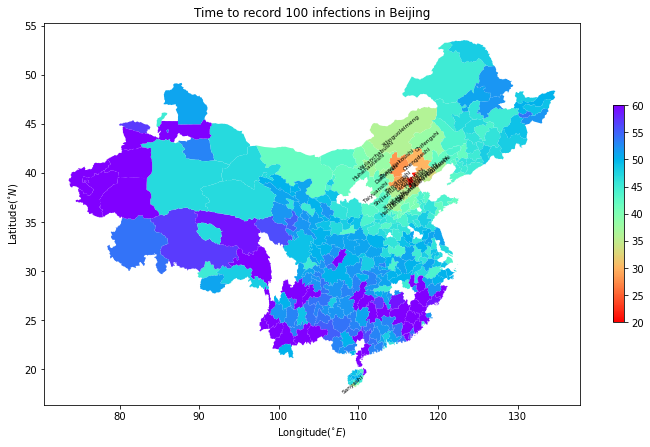

In [1]:
from scipy.integrate import solve_ivp, odeint
import sys
import time 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 140
import random
from collections import OrderedDict
from shapely.geometry import Polygon, LineString, Point
np.set_printoptions(linewidth=100)


renata_shape_file_relevant_column = gpd.read_file("../china_codes/spatial_match.shp") #shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code", "pop_2020", "ADM2_EN", "geometry"]])
tp_df.columns = ['tile_ID', 'population', 'Name', 'geometry']
tp_df['tile_ID'] = tp_df['tile_ID'].fillna(0).astype(int)
tp_df.reset_index(drop=True, inplace=True)
tp_gdf = tp_df.copy() # for getting the geometry
tp_df = pd.DataFrame(tp_df[['tile_ID', 'population', 'Name']])





def filter_data(df):
    mv_ot = df
    mv_ot = mv_ot.fillna(0)
    mv_ot = mv_ot * 44520/100 #44520/100
    mv_ot_id = mv_ot.rename(columns=lambda x: x.split("_")[1])
    column_name_and_index = list(mv_ot_id.columns)
    mv_ot_id.insert(0, "tile_ID", column_name_and_index, True)
    mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id= mv_ot_id.to_numpy()
    np.fill_diagonal(mv_ot_id, 0)
    mv_ot_id = pd.DataFrame(mv_ot_id, columns=column_name_and_index)
    mv_ot_id.insert(0, "ID", column_name_and_index, True)
    #mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id['ID'] = mv_ot_id['ID'].astype(int)
    #display(mv_ot_id)
    mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tp_df['tile_ID'])].copy()
    #display(mv_ot_id_filter)
    mv_ot_id_filter['ID'] = mv_ot_id_filter['ID'].astype(str)
    col_name = mv_ot_id_filter['ID'].tolist()
    mv_ot_id_filter = mv_ot_id_filter.set_index('ID')
    mv_ot_id_filter_ro_col = mv_ot_id_filter[col_name]
    #pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
    #mv_ot_id_filter_ro_col =  mv_ot_id_filter_ro_col.set_index('ID')
    return mv_ot_id_filter_ro_col

def tp_filter(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    epsilon_0 = epsilon_0[['ID', '110000']]
    epsilon_0 = epsilon_0.set_index('ID')
    df = df.drop('0', axis = 0)
    #display(epsilon_0)
    tp_filter = pd.concat([epsilon_0, df], axis=1)
    #display(tp_filter)
    tp_arr = tp_filter['population'].to_numpy()
    return tp_arr


mv_ot = pd.read_csv('move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)
#display(epsilon_0)
mv_in = pd.read_csv('move_in_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_1 = filter_data(mv_in)
#epsilon_1

epsilon = (epsilon_0 + epsilon_1)/2.0
# no_of_loc = 5
# epsilon = epsilon.iloc[:no_of_loc, : no_of_loc]

tp_for_pop_filter = tp_df.copy()
tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
tp = tp_filter(tp_for_pop_filter, epsilon_0) # get population the same order of ID in the flow frame


# print (tp[0:no_of_loc])
# tp = tp[0:no_of_loc]
# print(tp)
#tp = np.array([18827262.0, 11090783.0, 10163788.0, 7577289.0, 2987605.0])
epsilon = epsilon/tp
epsilon= epsilon.to_numpy()
np.fill_diagonal(epsilon, 0)
n=len(epsilon)
pi = (np.ones(n*n).reshape(n,n))*(1/7)

#tc = 3  # time between contacts in days 
tl = 5.5  # latent period of the infection
tr = 10  # recovery time in days
te = 60*365 # Human life expectancy in days (60 yr) 

R0_list = [4]
for rnot in R0_list:
    R0 = rnot

    #beta = 1 / tc  # contact rate in per daymu
    sigma = 1 /tl  # latency rate per day
    gamma = 1 / tr # recovery rate in per day
    mu = 1/te # Natural human death rate (in days^-1)
    beta = R0*(gamma+mu)
    #beta = R0*(gamma) #natural births and deaths are not considered in our model 

    t0 = 0.0 # start time
    tn = 356 # No_of_days
    time_sp = 1 # time increment is one day


    S0=np.zeros(n, dtype='float128')
    E0=np.zeros(n, dtype='float128')
    I0=np.zeros(n, dtype='float128')
    R0=np.zeros(n, dtype='float128')

    # s0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Sij random num b/w 1 and 5
    # e0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Eij random num b/w 1 and 5
    # i0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Iij random num b/w 1 and 5
    # r0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Rij random num b/w 1 and 5

    s0= np.zeros(n*n).reshape(n,n)
    e0= np.zeros(n*n).reshape(n,n)
    i0= np.zeros(n*n).reshape(n,n)
    r0= np.zeros(n*n).reshape(n,n)

    np.fill_diagonal(s0, 0)
    np.fill_diagonal(e0, 0)
    np.fill_diagonal(i0, 0)
    np.fill_diagonal(r0, 0)


    #for i in range(0, len(tp)):
    #E_temp = np.random.randint(100,150,(1,n)).reshape(-1)
    E_temp = np.zeros(n)
    #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)

    time = []
    inf_loc =[]
    for i in range(1,n):
        #print ('Location:', i)
        I_temp = np.zeros(n)
        I_temp[i] = 100
        #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)
        #print (E_temp)

        S0 = tp + s0.sum(axis=1) - e0.sum(axis=1) - i0.sum(axis=1) -r0.sum(axis=1) - E_temp - I_temp
        #S0 = tp 
        E0 =  E_temp 
        I0 = I_temp 
        #R0 = r0.reshape(n,n).sum(axis=1)

        # print ('Sii0:', S0)
        # print ('Eii0:', E0)
        # print ('Iii0:', I0)
        # print ('Rii0:', R0)
        # print ('sumSij0:', s0.sum(axis=1))
        # print ('sumEij0:', e0.sum(axis=1))
        # print ('sumIij0:', i0.sum(axis=1))
        # print ('sumRij0:', r0.sum(axis=1))

        #print('Sii0 + Eii0 + Iii0 + Rii0 + sumSij0 + sumEij0 + sumIij0 + sumRij0:', S0+E0+I0+R0+s0.sum(axis=1)+e0.sum(axis=1)+i0.sum(axis=1)+r0.sum(axis=1))


        sij = s0.reshape(-1)
        eij = e0.reshape(-1)
        iij = i0.reshape(-1)
        rij = r0.reshape(-1)


        ics = np.hstack((S0,E0,I0,R0,sij,eij,iij,rij))

        #print (ics.dtype)



        def seir_meta(t, ics, epsilon, pi):
            Sii = ics[0:n]; Eii = ics[n:2*n]
            Iii = ics[(2*n):3*n]; Rii = ics[(3*n):4*n]
            Sij = ics[(4*n+(0*n**2)):(4*n+(1*n**2))]
            Eij = ics[(4*n+(1*n**2)):(4*n+(2*n**2))]
            Iij = ics[(4*n+(2*n**2)):(4*n+(3*n**2))]
            Rij = ics[(4*n+(3*n**2)):(4*n+(4*n**2))]
            Sij.shape = (n,n); Eij.shape = (n,n); Iij.shape = (n,n); Rij.shape = (n,n)

            axis = 1
            sumIij = Iii + Iij.sum(axis=axis) # sumIij... no: of infected people in each location from all other loc ([len[N]])
            sumNij = Sii + Eii + Iii + Rii + Sij.sum(axis=axis) + Eij.sum(axis=axis) + Iij.sum(axis=axis) + Rij.sum(axis=axis)
            ''' Xij.sum(axis=1) are the arrays of population from all j's to a particular i '''

            Nij = Sij + Eij + Iij + Rij


            dSii_dt = mu*sumNij -beta*Sii*(sumIij/sumNij) - (epsilon*Sii).sum(axis=0) + (pi*Sij).sum(axis=0) - mu*Sii
            dSij_dt = mu*Nij -beta*Sij*(sumIij/sumNij)  + (epsilon*Sii)  - pi*Sij - mu*Sij
            dEii_dt = beta*Sii*(sumIij/sumNij) - (epsilon*Eii).sum(axis=0) + (pi*Eij).sum(axis=0) - sigma * Eii - mu*Eii
            dEij_dt = beta*Sij*(sumIij/sumNij) + (epsilon*Eii) - pi*Eij - sigma*Eij - mu*Eij
            dIii_dt = sigma * Eii  - (epsilon*Iii).sum(axis=0) + (pi*Iij).sum(axis=0) - gamma*Iii - mu*Iii
            dIij_dt = sigma * Eij  + (epsilon*Iii) - pi*Iij - gamma*Iij  - mu*Iij
            dRii_dt = gamma*Iii - (epsilon*Rii).sum(axis=0) + (pi*Rij).sum(axis=0) - mu*Rii
            dRij_dt = gamma*Iij  + (epsilon*Rii) - pi*Rij - mu*Rij

            dSij_dt_r = dSij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dEij_dt_r = dEij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dIij_dt_r = dIij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dRij_dt_r = dRij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array

            r = np.hstack((dSii_dt, dEii_dt, dIii_dt, dRii_dt, dSij_dt_r, dEij_dt_r, dIij_dt_r, dRij_dt_r))

            return r

        p = (epsilon, pi)
        t_span = (t0, tn)
        t = np.arange(t0, tn+time_sp, time_sp)

        # tic = time.time()
        # result_odeint = odeint(seir_meta, ics, t, p, tfirst=True)
        # toc = time.time()
        # print("Time Elapsed for ODEINT:", toc - tic)


        #tic = time.time()
        result_solve_ivp = solve_ivp(seir_meta, t_span, ics, args=p,
                                       method='DOP853', dense_output=True, t_eval=t, rtol= 1e-3, atol=1e-6) #DOP853
        # toc = time.time()
        # print("Time Elapsed for solve_ivp: ", toc - tic)

        #State DataFrame Creation
        col_name = list(mv_ot.columns)
        name = [x.split('_')[0] for x in col_name]
        code = [x.split('_')[1] for x in col_name]
        code_filter = list(epsilon_0.columns)
        #print(len(code), len(code_filter))
        index = []
        for i, x in enumerate(code):
            for j in code_filter:
                if x == j:
                    index.append(i)

        name_filter = []
        for i, x in enumerate(index):
            name_filter.append(name[x])



        level_1_label = [n+'_'+c for n,c in zip(name_filter,code_filter)]
        level_1_label = level_1_label[0:n]
        level_2_label = ['S_ii','S_ij','E_ii','E_ij','I_ii','I_ij','R_ii','R_ij']
        #level_2_label = ['S_ii','E_ii','I_ii','R_ii']
        S = result_solve_ivp.y[0:n, : ].T; E = result_solve_ivp.y[n:2*n, : ].T
        I = result_solve_ivp.y[2*n:3*n, : ].T; R = result_solve_ivp.y[3*n:4*n, : ].T


        Sij = result_solve_ivp.y[(4*n+(0*n**2)):(4*n+(1*n**2))].T
        Eij = result_solve_ivp.y[(4*n+(1*n**2)):(4*n+(2*n**2))].T
        Iij = result_solve_ivp.y[(4*n+(2*n**2)):(4*n+(3*n**2))].T
        Rij = result_solve_ivp.y[(4*n+(3*n**2)):(4*n+(4*n**2))].T

        Sij = Sij.reshape(Sij.shape[0],n,n); Eij = Eij.reshape(Eij.shape[0],n,n) 
        Iij = Iij.reshape(Iij.shape[0],n,n); Rij = Rij.reshape(Rij.shape[0],n,n)
        #x.shape is a 2-tuple which represents the shape of x,  
        #x.shape[0] gives the first element in that tuple

        sumSij = Sij.sum(axis=1); sumEij = Eij.sum(axis=1)  #X's came to i from all js
        sumIij = Iij.sum(axis=1); sumRij = Rij.sum(axis=1)  #X's came to i from all js

        header = pd.MultiIndex.from_product([level_1_label, level_2_label], names=['Location','State'])
        #fortran_order = np.reshape(np.vstack([S,E,I,R]), (len(S), -1), order = 'F') #reshape the data in Fortran order, before creating the dataframe
        fortran_order = np.reshape(np.vstack([S, sumSij,E,sumEij,I,sumIij,R,sumRij]), (len(S), -1), order = 'F')
        df = pd.DataFrame(fortran_order, columns = header)
        df.index.name = 'Time'

        #tot_te = time.time()
        #print("Total Time Elapsed: ", tot_te - tot_t)

        df1 = df.iloc[:, df.columns.get_level_values(0)=='Beijingshi_110000']
        #df2 = df1.iloc[:, df1.columns.get_level_values(1)=='I_ii']
        df1.columns = df1.columns.get_level_values('State')
        time_temp = df1[df1['I_ii'] + df1['I_ij'] >=100.].index.values
        #print(time[0])
        time.append(time_temp[0])

        #print (time_temp[0])

#     df_100_to_Beijing_dist = {'Location': level_1_label[1:n], 'Beijing records 100 infections on':time}
#     df_100_to_Beijing = pd.DataFrame(df_100_to_Beijing_dist)
    
    
    def tp_filter_df_with_geometry(df, epsilon_0):
        epsilon_0 = epsilon_0.reset_index(drop=False)
        epsilon_0 = epsilon_0[['ID', '110000']]
        epsilon_0 = epsilon_0.set_index('ID')
        df = df.drop('0', axis = 0)
        #display(epsilon_0)
        tp_filter = pd.concat([epsilon_0, df], axis=1)
        tp_filter = tp_filter.drop(columns ='110000')
        gdf = gpd.GeoDataFrame(tp_filter, crs="EPSG:4326", geometry='geometry')
        #display(gdf)
        return gdf


    tp_for_pop_filter = tp_gdf.copy()
    tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
    tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
    tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
    gdf_filter_0 = tp_filter_df_with_geometry(tp_for_pop_filter, epsilon_0)

    gdf_filter = gdf_filter_0[1:n].copy()

    gdf_filter.insert(2, 'Beijing_100_infections_time', time, True)
    gdf_filter.insert(1, '100_initial_infections_at', level_1_label[1:n], True)
    
    Beijing_100_infections_time = pd.DataFrame(gdf_filter.iloc[:, : 5])
    Beijing_100_infections_time = Beijing_100_infections_time[['100_initial_infections_at', 'Beijing_100_infections_time']]
    #Beijing_100_infections_time.to_csv('Beijing_100_infections_time_with_out_interventions_r0_1_3.csv', index=True)
    gdf_filter = gdf_filter.to_crs(epsg=3395)
    Beijing_temp = gpd.GeoDataFrame(tp_gdf[['tile_ID', 'population', "geometry"]])
    Beijing_temp_proj = Beijing_temp.to_crs(epsg=3395)
    #Beijing_temp_proj
    Beijing = Beijing_temp_proj.geometry[0]

    distance_from_Beijing = gdf_filter.geometry.distance(Beijing)
    gdf_filter.insert(4, 'distance_from_Beijing', distance_from_Beijing, True)
    gdf_filter = gdf_filter.to_crs(epsg=4326)

    fig = plt.figure(figsize=(12, 8))
    ax = gdf_filter.plot(column='Beijing_100_infections_time', vmin = 20, vmax= 60, 
                               cmap="rainbow_r", figsize=(12,8), legend=True, legend_kwds={'shrink': 0.5}, 
                         alpha = 1.0, markersize = 10)#rainbow, winter, jet autumn copper Reds_r
    #ax = gdf_filter.plot(column='distance_from_Beijing', ax=ax, color='blue', alpha=0.5, zorder=2)
    for idx, row in gdf_filter.iterrows():
        if(row['Beijing_100_infections_time'] < 40):
            plt.annotate(text=row['100_initial_infections_at'].split('_')[0], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                     horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
    ax.set_title('Time to record 100 infections in Beijing')

    ax.set_xlabel(r'Longitude($^{\circ} E$)')
    ax.set_ylabel(r'Latitude($^{\circ} N$)')
    #ax.figure.savefig("time_to_record_100_infections_in_Beijing.png", dpi =300, transparent=False)
    plt.show()



### Simulation with Pi = epsilon times 1/7

In [1]:
from scipy.integrate import solve_ivp, odeint
import sys
import time 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 140
import random
from collections import OrderedDict
from shapely.geometry import Polygon, LineString, Point
np.set_printoptions(linewidth=100)


renata_shape_file_relevant_column = gpd.read_file("../china_codes/spatial_match.shp") #shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code_", "pop_2020", "ADM2_EN", "geometry"]])
tp_df.columns = ['tile_ID', 'population', 'Name', 'geometry']
tp_df['tile_ID'] = tp_df['tile_ID'].fillna(0).astype(int)
tp_df.reset_index(drop=True, inplace=True)
tp_gdf = tp_df.copy() # for getting the geometry
tp_df = pd.DataFrame(tp_df[['tile_ID', 'population', 'Name']])





def filter_data(df):
    mv_ot = df
    mv_ot = mv_ot.fillna(0)
    mv_ot = mv_ot * 44520/100 #44520/100
    mv_ot_id = mv_ot.rename(columns=lambda x: x.split("_")[1])
    column_name_and_index = list(mv_ot_id.columns)
    mv_ot_id.insert(0, "tile_ID", column_name_and_index, True)
    mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id= mv_ot_id.to_numpy()
    np.fill_diagonal(mv_ot_id, 0)
    mv_ot_id = pd.DataFrame(mv_ot_id, columns=column_name_and_index)
    mv_ot_id.insert(0, "ID", column_name_and_index, True)
    #mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id['ID'] = mv_ot_id['ID'].astype(int)
    #display(mv_ot_id)
    mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tp_df['tile_ID'])].copy()
    #display(mv_ot_id_filter)
    mv_ot_id_filter['ID'] = mv_ot_id_filter['ID'].astype(str)
    col_name = mv_ot_id_filter['ID'].tolist()
    mv_ot_id_filter = mv_ot_id_filter.set_index('ID')
    mv_ot_id_filter_ro_col = mv_ot_id_filter[col_name]
    #pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
    #mv_ot_id_filter_ro_col =  mv_ot_id_filter_ro_col.set_index('ID')
    return mv_ot_id_filter_ro_col

def tp_filter(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    epsilon_0 = epsilon_0[['ID', '110000']]
    epsilon_0 = epsilon_0.set_index('ID')
    df = df.drop('0', axis = 0)
    #display(epsilon_0)
    tp_filter = pd.concat([epsilon_0, df], axis=1)
    #display(tp_filter)
    tp_arr = tp_filter['population'].to_numpy()
    return tp_arr


mv_ot = pd.read_csv('move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)
#display(epsilon_0)
mv_in = pd.read_csv('move_in_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_1 = filter_data(mv_in)
#epsilon_1

epsilon = (epsilon_0 + epsilon_1)/2.0
# no_of_loc = 5
# epsilon = epsilon.iloc[:no_of_loc, : no_of_loc]

tp_for_pop_filter = tp_df.copy()
tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
tp = tp_filter(tp_for_pop_filter, epsilon_0) # get population the same order of ID in the flow frame


# print (tp[0:no_of_loc])
# tp = tp[0:no_of_loc]
# print(tp)
#tp = np.array([18827262.0, 11090783.0, 10163788.0, 7577289.0, 2987605.0])
epsilon = epsilon/tp
epsilon= epsilon.to_numpy()
np.fill_diagonal(epsilon, 0)
n=len(epsilon)
#pi = (np.ones(n*n).reshape(n,n))*(1/7)
pi = epsilon*(1/7)

#tc = 3  # time between contacts in days 
tl = 5.5  # latent period of the infection
tr = 10  # recovery time in days
te = 60*365 # Human life expectancy in days (60 yr) 

R0_list = [4]
for rnot in R0_list:
    R0 = rnot

    #beta = 1 / tc  # contact rate in per daymu
    sigma = 1 /tl  # latency rate per day
    gamma = 1 / tr # recovery rate in per day
    mu = 1/te # Natural human death rate (in days^-1)
    beta = R0*(gamma+mu)
    #beta = R0*(gamma) #natural births and deaths are not considered in our model 

    t0 = 0.0 # start time
    tn = 356 # No_of_days
    time_sp = 1 # time increment is one day


    S0=np.zeros(n, dtype='float128')
    E0=np.zeros(n, dtype='float128')
    I0=np.zeros(n, dtype='float128')
    R0=np.zeros(n, dtype='float128')

    # s0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Sij random num b/w 1 and 5
    # e0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Eij random num b/w 1 and 5
    # i0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Iij random num b/w 1 and 5
    # r0=np.random.randint(1,5,(1,n*n)).reshape(n,n) # Rij random num b/w 1 and 5

    s0= np.zeros(n*n).reshape(n,n)
    e0= np.zeros(n*n).reshape(n,n)
    i0= np.zeros(n*n).reshape(n,n)
    r0= np.zeros(n*n).reshape(n,n)

    np.fill_diagonal(s0, 0)
    np.fill_diagonal(e0, 0)
    np.fill_diagonal(i0, 0)
    np.fill_diagonal(r0, 0)


    #for i in range(0, len(tp)):
    #E_temp = np.random.randint(100,150,(1,n)).reshape(-1)
    E_temp = np.zeros(n)
    #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)

    time = []
    inf_loc =[]
    for i in range(1,n):
        #print ('Location:', i)
        I_temp = np.zeros(n)
        I_temp[i] = 100
        #I_temp = np.random.randint(1500,2000,(1,n)).reshape(-1)
        #print (E_temp)

        S0 = tp + s0.sum(axis=1) - e0.sum(axis=1) - i0.sum(axis=1) -r0.sum(axis=1) - E_temp - I_temp
        #S0 = tp 
        E0 =  E_temp 
        I0 = I_temp 
        #R0 = r0.reshape(n,n).sum(axis=1)

        # print ('Sii0:', S0)
        # print ('Eii0:', E0)
        # print ('Iii0:', I0)
        # print ('Rii0:', R0)
        # print ('sumSij0:', s0.sum(axis=1))
        # print ('sumEij0:', e0.sum(axis=1))
        # print ('sumIij0:', i0.sum(axis=1))
        # print ('sumRij0:', r0.sum(axis=1))

        #print('Sii0 + Eii0 + Iii0 + Rii0 + sumSij0 + sumEij0 + sumIij0 + sumRij0:', S0+E0+I0+R0+s0.sum(axis=1)+e0.sum(axis=1)+i0.sum(axis=1)+r0.sum(axis=1))


        sij = s0.reshape(-1)
        eij = e0.reshape(-1)
        iij = i0.reshape(-1)
        rij = r0.reshape(-1)


        ics = np.hstack((S0,E0,I0,R0,sij,eij,iij,rij))

        #print (ics.dtype)



        def seir_meta(t, ics, epsilon, pi):
            Sii = ics[0:n]; Eii = ics[n:2*n]
            Iii = ics[(2*n):3*n]; Rii = ics[(3*n):4*n]
            Sij = ics[(4*n+(0*n**2)):(4*n+(1*n**2))]
            Eij = ics[(4*n+(1*n**2)):(4*n+(2*n**2))]
            Iij = ics[(4*n+(2*n**2)):(4*n+(3*n**2))]
            Rij = ics[(4*n+(3*n**2)):(4*n+(4*n**2))]
            Sij.shape = (n,n); Eij.shape = (n,n); Iij.shape = (n,n); Rij.shape = (n,n)

            axis = 1
            sumIij = Iii + Iij.sum(axis=axis) # sumIij... no: of infected people in each location from all other loc ([len[N]])
            sumNij = Sii + Eii + Iii + Rii + Sij.sum(axis=axis) + Eij.sum(axis=axis) + Iij.sum(axis=axis) + Rij.sum(axis=axis)
            ''' Xij.sum(axis=1) are the arrays of population from all j's to a particular i '''

            Nij = Sij + Eij + Iij + Rij


            dSii_dt = mu*sumNij -beta*Sii*(sumIij/sumNij) - (epsilon*Sii).sum(axis=0) + (pi*Sij).sum(axis=0) - mu*Sii
            dSij_dt = mu*Nij -beta*Sij*(sumIij/sumNij)  + (epsilon*Sii)  - pi*Sij - mu*Sij
            dEii_dt = beta*Sii*(sumIij/sumNij) - (epsilon*Eii).sum(axis=0) + (pi*Eij).sum(axis=0) - sigma * Eii - mu*Eii
            dEij_dt = beta*Sij*(sumIij/sumNij) + (epsilon*Eii) - pi*Eij - sigma*Eij - mu*Eij
            dIii_dt = sigma * Eii  - (epsilon*Iii).sum(axis=0) + (pi*Iij).sum(axis=0) - gamma*Iii - mu*Iii
            dIij_dt = sigma * Eij  + (epsilon*Iii) - pi*Iij - gamma*Iij  - mu*Iij
            dRii_dt = gamma*Iii - (epsilon*Rii).sum(axis=0) + (pi*Rij).sum(axis=0) - mu*Rii
            dRij_dt = gamma*Iij  + (epsilon*Rii) - pi*Rij - mu*Rij

            dSij_dt_r = dSij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dEij_dt_r = dEij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dIij_dt_r = dIij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array
            dRij_dt_r = dRij_dt.reshape(-1) #Flattening (n x n) array -- Converting the (n x n) array into a 1D array

            r = np.hstack((dSii_dt, dEii_dt, dIii_dt, dRii_dt, dSij_dt_r, dEij_dt_r, dIij_dt_r, dRij_dt_r))

            return r

        p = (epsilon, pi)
        t_span = (t0, tn)
        t = np.arange(t0, tn+time_sp, time_sp)

        # tic = time.time()
        # result_odeint = odeint(seir_meta, ics, t, p, tfirst=True)
        # toc = time.time()
        # print("Time Elapsed for ODEINT:", toc - tic)


        #tic = time.time()
        result_solve_ivp = solve_ivp(seir_meta, t_span, ics, args=p,
                                       method='DOP853', dense_output=True, t_eval=t, rtol= 1e-3, atol=1e-6) #DOP853
        # toc = time.time()
        # print("Time Elapsed for solve_ivp: ", toc - tic)

        #State DataFrame Creation
        col_name = list(mv_ot.columns)
        name = [x.split('_')[0] for x in col_name]
        code = [x.split('_')[1] for x in col_name]
        code_filter = list(epsilon_0.columns)
        #print(len(code), len(code_filter))
        index = []
        for i, x in enumerate(code):
            for j in code_filter:
                if x == j:
                    index.append(i)

        name_filter = []
        for i, x in enumerate(index):
            name_filter.append(name[x])



        level_1_label = [n+'_'+c for n,c in zip(name_filter,code_filter)]
        level_1_label = level_1_label[0:n]
        level_2_label = ['S_ii','S_ij','E_ii','E_ij','I_ii','I_ij','R_ii','R_ij']
        #level_2_label = ['S_ii','E_ii','I_ii','R_ii']
        S = result_solve_ivp.y[0:n, : ].T; E = result_solve_ivp.y[n:2*n, : ].T
        I = result_solve_ivp.y[2*n:3*n, : ].T; R = result_solve_ivp.y[3*n:4*n, : ].T


        Sij = result_solve_ivp.y[(4*n+(0*n**2)):(4*n+(1*n**2))].T
        Eij = result_solve_ivp.y[(4*n+(1*n**2)):(4*n+(2*n**2))].T
        Iij = result_solve_ivp.y[(4*n+(2*n**2)):(4*n+(3*n**2))].T
        Rij = result_solve_ivp.y[(4*n+(3*n**2)):(4*n+(4*n**2))].T

        Sij = Sij.reshape(Sij.shape[0],n,n); Eij = Eij.reshape(Eij.shape[0],n,n) 
        Iij = Iij.reshape(Iij.shape[0],n,n); Rij = Rij.reshape(Rij.shape[0],n,n)
        #x.shape is a 2-tuple which represents the shape of x,  
        #x.shape[0] gives the first element in that tuple

        sumSij = Sij.sum(axis=1); sumEij = Eij.sum(axis=1)  #X's came to i from all js
        sumIij = Iij.sum(axis=1); sumRij = Rij.sum(axis=1)  #X's came to i from all js

        header = pd.MultiIndex.from_product([level_1_label, level_2_label], names=['Location','State'])
        #fortran_order = np.reshape(np.vstack([S,E,I,R]), (len(S), -1), order = 'F') #reshape the data in Fortran order, before creating the dataframe
        fortran_order = np.reshape(np.vstack([S, sumSij,E,sumEij,I,sumIij,R,sumRij]), (len(S), -1), order = 'F')
        df = pd.DataFrame(fortran_order, columns = header)
        df.index.name = 'Time'

        #tot_te = time.time()
        #print("Total Time Elapsed: ", tot_te - tot_t)

        df1 = df.iloc[:, df.columns.get_level_values(0)=='Beijingshi_110000']
        #df2 = df1.iloc[:, df1.columns.get_level_values(1)=='I_ii']
        df1.columns = df1.columns.get_level_values('State')
        time_temp = df1[df1['I_ii'] + df1['I_ij'] >=100.].index.values
        #print(time[0])
        time.append(time_temp[0])

        #print (time_temp[0])

#     df_100_to_Beijing_dist = {'Location': level_1_label[1:n], 'Beijing records 100 infections on':time}
#     df_100_to_Beijing = pd.DataFrame(df_100_to_Beijing_dist)
    
    
    def tp_filter_df_with_geometry(df, epsilon_0):
        epsilon_0 = epsilon_0.reset_index(drop=False)
        epsilon_0 = epsilon_0[['ID', '110000']]
        epsilon_0 = epsilon_0.set_index('ID')
        df = df.drop('0', axis = 0)
        #display(epsilon_0)
        tp_filter = pd.concat([epsilon_0, df], axis=1)
        tp_filter = tp_filter.drop(columns ='110000')
        gdf = gpd.GeoDataFrame(tp_filter, crs="EPSG:4326", geometry='geometry')
        #display(gdf)
        return gdf


    tp_for_pop_filter = tp_gdf.copy()
    tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
    tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
    tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
    gdf_filter_0 = tp_filter_df_with_geometry(tp_for_pop_filter, epsilon_0)

    gdf_filter = gdf_filter_0[1:n].copy()

    gdf_filter.insert(2, 'Beijing_100_infections_time', time, True)
    gdf_filter.insert(1, '100_initial_infections_at', level_1_label[1:n], True)
    
    Beijing_100_infections_time = pd.DataFrame(gdf_filter.iloc[:, : 5])
    Beijing_100_infections_time = Beijing_100_infections_time[['100_initial_infections_at', 'Beijing_100_infections_time']]
    Beijing_100_infections_time.to_csv('Beijing_100_infections_time_with_out_interventions_r0_1_3.csv', index=True)
    gdf_filter = gdf_filter.to_crs(epsg=3395)
    Beijing_temp = gpd.GeoDataFrame(tp_gdf[['tile_ID', 'population', "geometry"]])
    Beijing_temp_proj = Beijing_temp.to_crs(epsg=3395)
    #Beijing_temp_proj
    Beijing = Beijing_temp_proj.geometry[0]

    distance_from_Beijing = gdf_filter.geometry.distance(Beijing)
    gdf_filter.insert(4, 'distance_from_Beijing', distance_from_Beijing, True)
    gdf_filter = gdf_filter.to_crs(epsg=4326)

    fig = plt.figure(figsize=(12, 8))
    ax = gdf_filter.plot(column='Beijing_100_infections_time', vmin = 20, vmax= 60, 
                               cmap="rainbow_r", figsize=(12,8), legend=True, legend_kwds={'shrink': 0.5}, 
                         alpha = 1.0, markersize = 10)#rainbow, winter, jet autumn copper Reds_r
    #ax = gdf_filter.plot(column='distance_from_Beijing', ax=ax, color='blue', alpha=0.5, zorder=2)
    for idx, row in gdf_filter.iterrows():
        if(row['Beijing_100_infections_time'] < 40):
            plt.annotate(text=row['100_initial_infections_at'].split('_')[0], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                     horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
    ax.set_title('Time to record 100 infections in Beijing')

    ax.set_xlabel(r'Longitude($^{\circ} E$)')
    ax.set_ylabel(r'Latitude($^{\circ} N$)')
    ax.figure.savefig("time_to_record_100_infections_in_Beijing.png", dpi =300, transparent=False)
    plt.show()

ModuleNotFoundError: No module named 'geopandas'

In [90]:

Beijing_100_infections_time.sort_values('Beijing_100_infections_time', ascending=True).head(10)

,100_initial_infections_at,Beijing_100_infections_time
ID,,
131000,Langfangshi_131000,41
130700,Zhangjiakoushi_130700,57
130600,Baodingshi_130600,59
130800,Chengdeshi_130800,61
120000,Tianjinshi_120000,67
130300,Qinhuangdaoshi_130300,69
130200,Tangshanshi_130200,74
131100,Hengshuishi_131100,76
130900,Cangzhoushi_130900,76


## Gravity term for Beijing

In [60]:
import skmob
import pandas as pd
import geopandas as gpd
import numpy as np
from skmob.models import Gravity

renata_shape_file_relevant_column = gpd.read_file("../china_codes/spatial_match.shp") #shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code_", "pop_2020", "ADM2_EN", "geometry"]])
tp_df.columns = ['tile_ID', 'population', 'Name', 'geometry']
tp_df['tile_ID'] = tp_df['tile_ID'].fillna(0).astype(int)
tp_df.reset_index(drop=True, inplace=True)
tp_gdf = tp_df.copy() # for getting the geometry
tp_df = pd.DataFrame(tp_df[['tile_ID', 'population', 'Name']])
tessellation = gpd.GeoDataFrame(tp_gdf[["tile_ID", "population", "geometry"]])
tessellation['tile_ID'] = tessellation['tile_ID'].astype(str)

def filter_data(df):
    mv_ot = df
    mv_ot = mv_ot.fillna(0)
    mv_ot = mv_ot * 44520/100 #44520/100
    mv_ot_id = mv_ot.rename(columns=lambda x: x.split("_")[1])
    column_name_and_index = list(mv_ot_id.columns)
    mv_ot_id.insert(0, "tile_ID", column_name_and_index, True)
    mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id= mv_ot_id.to_numpy()
    np.fill_diagonal(mv_ot_id, 0)
    mv_ot_id = pd.DataFrame(mv_ot_id, columns=column_name_and_index)
    mv_ot_id.insert(0, "ID", column_name_and_index, True)
    #mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id['ID'] = mv_ot_id['ID'].astype(int)
    #display(mv_ot_id)
    mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tp_df['tile_ID'])].copy()
    #display(mv_ot_id_filter)
    mv_ot_id_filter['ID'] = mv_ot_id_filter['ID'].astype(str)
    col_name = mv_ot_id_filter['ID'].tolist()
    mv_ot_id_filter = mv_ot_id_filter.set_index('ID')
    mv_ot_id_filter_ro_col = mv_ot_id_filter[col_name]
    #pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
    #mv_ot_id_filter_ro_col =  mv_ot_id_filter_ro_col.set_index('ID')
    return mv_ot_id_filter_ro_col

def tp_filter(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    epsilon_0 = epsilon_0[['ID', '110000']]
    epsilon_0 = epsilon_0.set_index('ID')
    df = df.drop('0', axis = 0)
    #display(epsilon_0)
    tp_filter = pd.concat([epsilon_0, df], axis=1)
    #display(tp_filter)
    tp_arr = tp_filter['population'].to_numpy()
    return tp_arr


mv_ot = pd.read_csv('move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)
#display(epsilon_0)
mv_in = pd.read_csv('move_in_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_1 = filter_data(mv_in)
#epsilon_1

mv_ot_id = (epsilon_0 + epsilon_1)/2.0
mv_ot_id = mv_ot_id.reset_index()

mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tessellation['tile_ID'])].copy()
col_name = mv_ot_id_filter['ID']
mv_ot_id_filter_ro_col = pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
 
df_1 = mv_ot_id_filter_ro_col.melt(id_vars="ID", var_name=["destination"], value_name="flow") # we need data in this format to create skmob.FlowDataFrame
df_1 = df_1.rename(columns={'ID': 'origin'})

tessellation_filter = tessellation[tessellation['tile_ID'].isin(mv_ot_id_filter_ro_col['ID'])].copy()

fdf = skmob.FlowDataFrame(df_1, origin='origin', destination='destination', flow='flow', tessellation=tessellation_filter, tile_id='tile_ID')

# compute the total outflows from each location of the tessellation (excluding self loops)
tot_outflows = fdf[fdf['origin'] != fdf['destination']].groupby(by='origin', axis=0)[['flow']].sum().fillna(0)

tessellation = tessellation_filter.merge(tot_outflows, left_on='tile_ID', right_on='origin').rename(columns={'flow': 'tot_outflow'})
id_population = pd.DataFrame(tessellation_filter[['tile_ID', 'population']])
id_population = id_population.set_index('tile_ID')

# instantiate a singly constrained Gravity model
gravity_singly = Gravity(gravity_type='singly constrained')
print(gravity_singly)

np.random.seed(0)
synth_fdf = gravity_singly.generate(tessellation,
                                   tile_id_column='tile_ID', #tot_outflows_column='tot_outflow',
                                   relevance_column= 'population',
                                   out_format='flows') # average flow between two locations
#synth_fdf.sort_values(by = ['origin', 'destination'])

df2=pd.pivot(pd.DataFrame(synth_fdf), index='destination', columns='origin', values='flow')
df_temp = df2.iloc[0:1,:]
df_temp.columns.name = None
df_temp.index.name = None
df_Gravity_term_for_Beijing = df_temp.T
df_Gravity_term_for_Beijing.reset_index(inplace=True)
df_Gravity_term_for_Beijing = df_Gravity_term_for_Beijing.rename(columns={'index':'ID'})
df_Gravity_term_for_Beijing['ID'] = df_Gravity_term_for_Beijing['ID'].astype(str)
df_Gravity_term_for_Beijing.set_index('ID', inplace=True)


/home/rsjohn/anaconda3/envs/habitat/lib/python3.8/site-packages/skmob/core/flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).
  warn("The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).")


Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 346/346 [00:00<00:00, 6631.52it/s]
/home/rsjohn/anaconda3/envs/habitat/lib/python3.8/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/home/rsjohn/anaconda3/envs/habitat/lib/python3.8/site-packages/skmob/core/flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).
  warn("The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).")


In [61]:
Beijing_100_infections_time = pd.read_csv('Beijing_100_infections_time_with_out_interventions.csv')#, index_col='ID')
Beijing_100_infections_time['ID'] = Beijing_100_infections_time['ID'].astype(str)
Beijing_100_infections_time.set_index('ID', inplace=True)
Beijing_100_infections_time

,100_initial_infections_at,Beijing_100_infections_time
ID,,
120000,Tianjinshi_120000,31
130100,Shijiazhuangshi_130100,36
130200,Tangshanshi_130200,35
130300,Qinhuangdaoshi_130300,33
130400,Handanshi_130400,37
...,...,...
653200,Hetiandiqu_653200,64
654000,Yilihasakezizhizhou_654000,54
654200,Tachengdiqu_654200,52


In [75]:
df_gravity_inf_time = pd.merge(Beijing_100_infections_time, df_Gravity_term_for_Beijing, left_index=True, right_index=True)
df_gravity_inf_time.rename(columns={'110000':'Gravity_Flow'}, inplace=True)
df_gravity_inf_time.set_index('100_initial_infections_at', inplace=True)
df_gravity_inf_time

,Beijing_100_infections_time,Gravity_Flow
100_initial_infections_at,,
Tianjinshi_120000,31,147.916606
Shijiazhuangshi_130100,36,158.779004
Tangshanshi_130200,35,133.384103
Qinhuangdaoshi_130300,33,15.013389
Handanshi_130400,37,194.396236
...,...,...
Kashidiqu_653100,64,6.212181
Hetiandiqu_653200,64,6.452275
Yilihasakezizhizhou_654000,54,29.789963


In [76]:
p_pr = pd.read_csv('Diff_Centrality.csv') 
p_pr = p_pr.sort_values('WeightedPersonalizedPagerank', ascending=False)
p_pr.set_index('Name_ID', inplace=True)
p_pr = p_pr[['WeightedPersonalizedPagerank']]
p_pr


,WeightedPersonalizedPagerank
Name_ID,
Beijingshi_110000,0.194290
Langfangshi_131000,0.038429
Tianjinshi_120000,0.027796
Baodingshi_130600,0.023356
Shijiazhuangshi_130100,0.014314
...,...
Bengbushi_340300,0.000000
Luanshi_341500,0.000000
Xiamenshi_350200,0.000000


In [77]:
p_pr_mer = pd.merge(df_gravity_inf_time, p_pr, left_index=True, right_index=True)

p_pr_mer

,Beijing_100_infections_time,Gravity_Flow,WeightedPersonalizedPagerank
Tianjinshi_120000,31,147.916606,0.027796
Shijiazhuangshi_130100,36,158.779004,0.014314
Tangshanshi_130200,35,133.384103,0.011084
Qinhuangdaoshi_130300,33,15.013389,0.005623
Handanshi_130400,37,194.396236,0.008497
...,...,...,...
Kashidiqu_653100,64,6.212181,0.000357
Hetiandiqu_653200,64,6.452275,0.000246
Yilihasakezizhizhou_654000,54,29.789963,0.000482
Tachengdiqu_654200,52,13.647979,0.000483


/tmp/ipykernel_43942/841769039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_pr_mer['WeightedPersonalizedPagerank']= p_pr_mer['WeightedPersonalizedPagerank'].astype(float)


<AxesSubplot:>

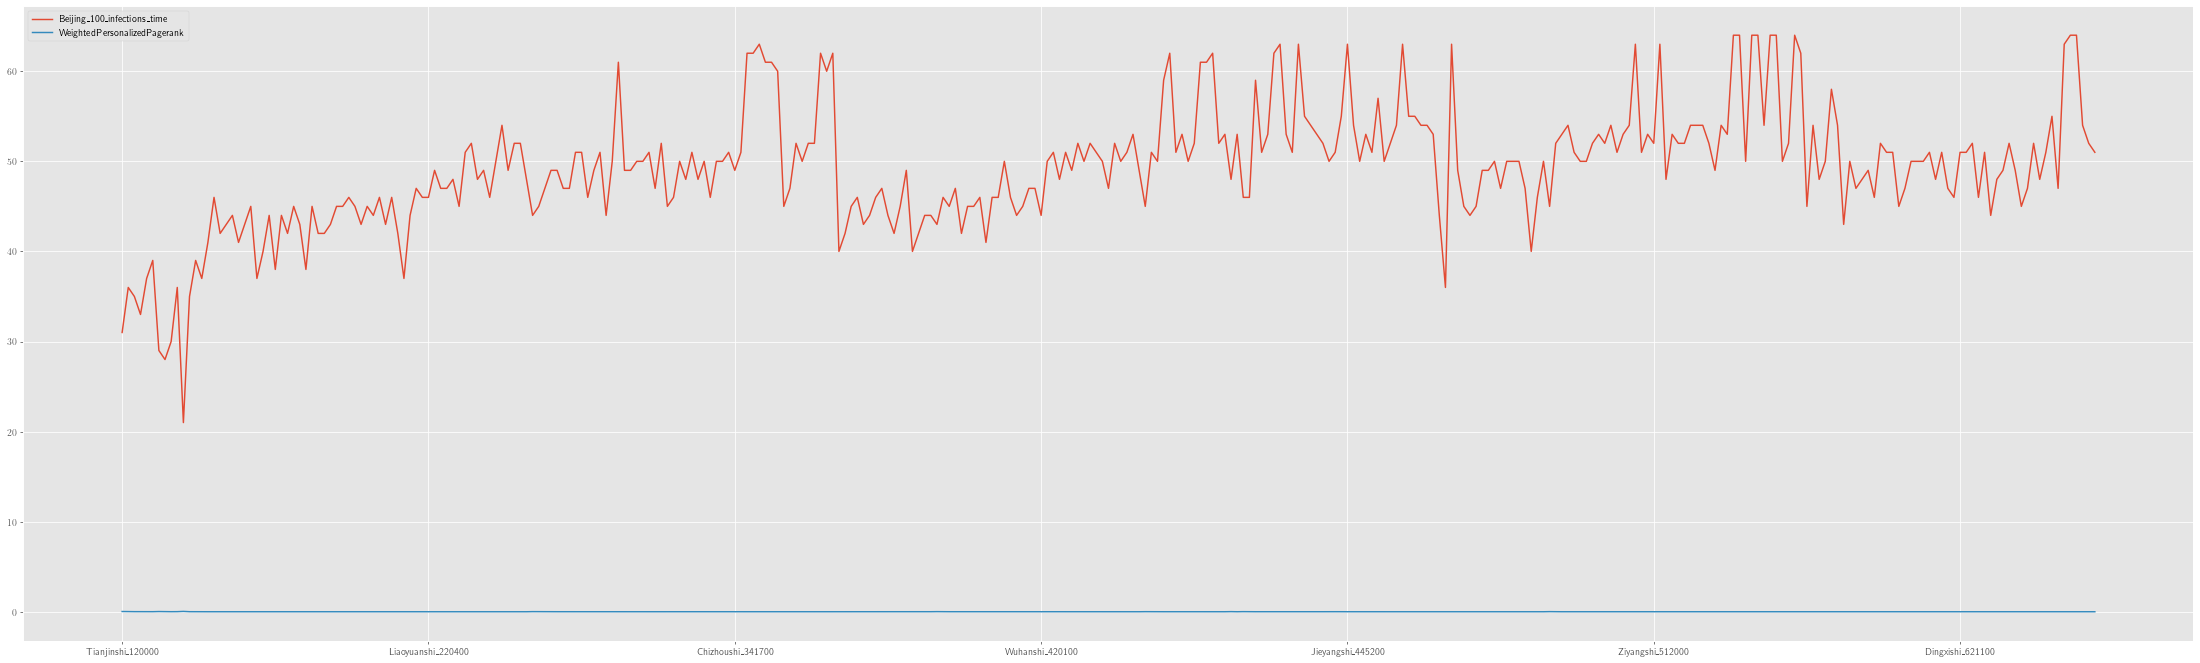

In [85]:
p_pr_mer['WeightedPersonalizedPagerank']= p_pr_mer['WeightedPersonalizedPagerank'].astype(float)
p_pr_mer = p_pr_mer[['Beijing_100_infections_time', 'WeightedPersonalizedPagerank']]
p_pr_mer.plot()

In [80]:
p_pr_mer['WeightedPersonalizedPagerank'].corr(p_pr_mer['Beijing_100_infections_time'])

-0.5526232533086561

ValueError: Could not interpret value `WeightedPersonalizedPagerank` for parameter `y`

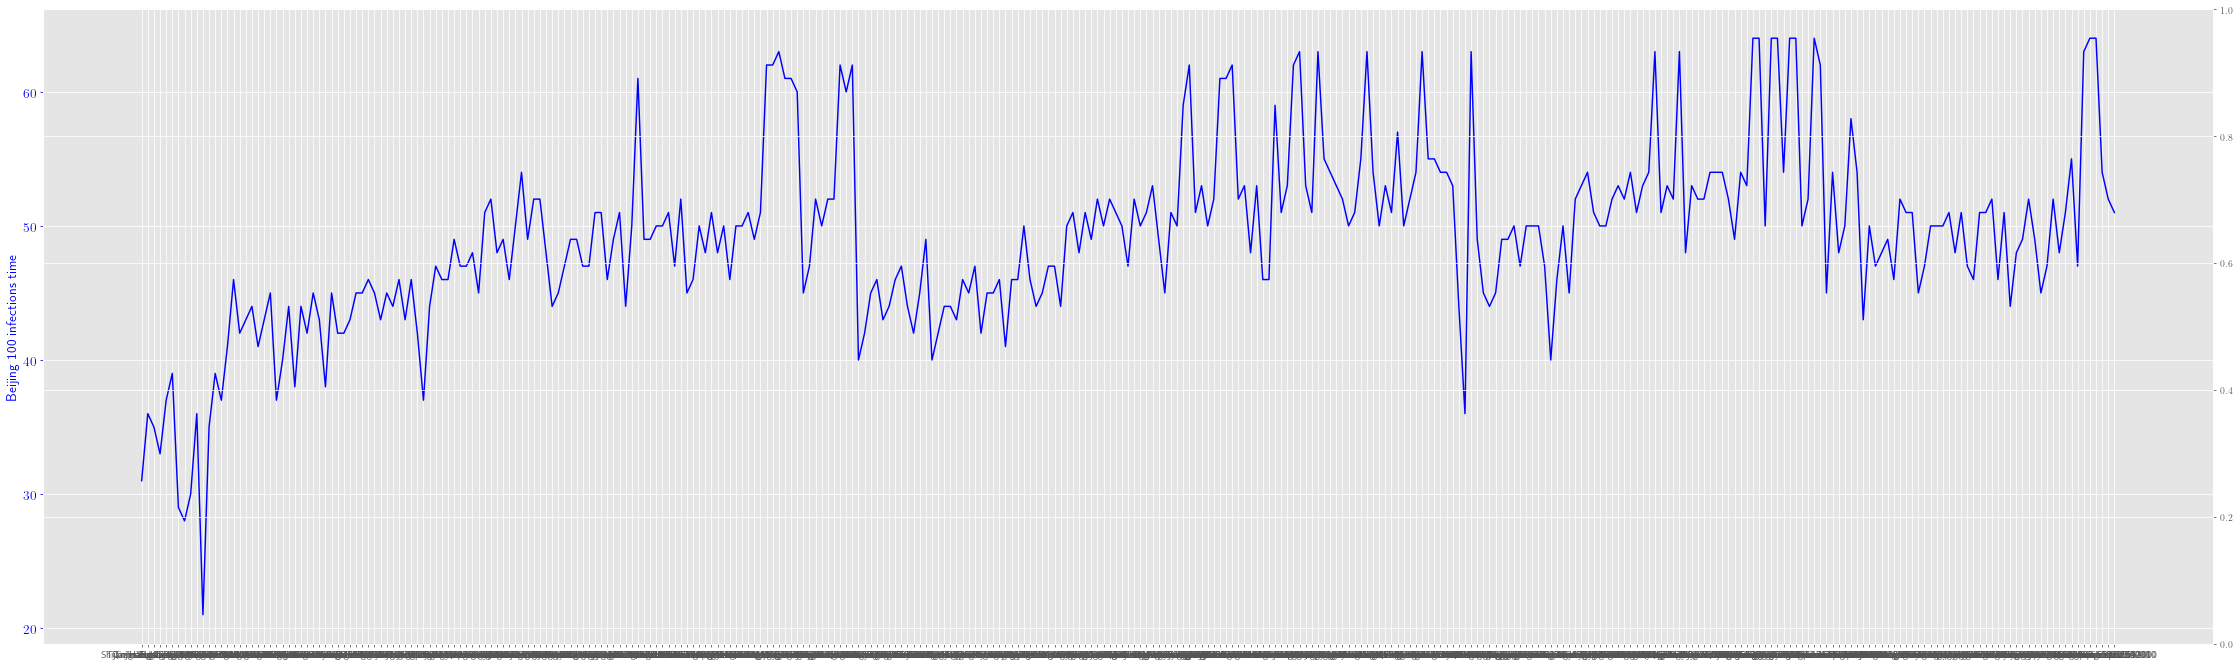

In [83]:

plt.rcParams['figure.figsize'] = [40, 12] #[W,H]
plt.rcParams['figure.dpi'] = 70
plt.rcParams['text.usetex'] = True
plt.style.use('ggplot')

# plot line chart on axis #1
ax1 = sns.lineplot(
    x=p_pr_mer.index, 
    y='Beijing_100_infections_time', 
    data=df_gravity_inf_time, 
    sort=False, 
    color='blue'
)
ax1.set_ylabel(r"Beijing 100 infections time")
#ax1.set_ylim(0, 0.5)
#ax1.set_yscale('log')
#ax1.legend([r"$\displaystyle\sum_{r=0}^i \frac{i!}{r!(i-r)!} \frac{(-1)^{r}}{r!}$"], loc="upper center")
ax1.yaxis.label.set_color('blue')
ax1.yaxis.label.set_fontsize(14)
ax1.tick_params(axis='y', colors='blue', labelsize=14)

# set up the 2nd axis
ax2 = ax1.twinx() 

# plot bar chart on axis #2
sns.lineplot(
    x=p_pr_mer.index, 
    y='WeightedPersonalizedPagerank', 
    data=df_gravity_inf_time, 
    sort=False, 
    color='red', 
    ax = ax2       # Pre-existing axes for the plot
)
ax2.grid(False) # turn off grid #2
ax2.set_ylabel(r"WeightedPersonalizedPagerank")
#ax2.set_ylim(1e-8, 5e-01)
ax2.set_yscale('log')
#ax2.legend([r"$\displaystyle\frac{1}{e^{1/12}2\pi i} \left(1 - \frac{e}{i}\right)^{2i}$"], loc="best")
ax2.yaxis.label.set_color('red')
ax2.yaxis.label.set_fontsize(14)
ax2.tick_params(axis='y', colors='red', labelsize=14)



#plt.title(r"$\displaystyle\sum_{r=0}^i \frac{i!}{r!(i-r)!} \frac{(-1)^{r}}{r!}$ and $\displaystyle\frac{1}{e^{1/12}2\pi i} \left(1 - \frac{e}{i}\right)^{2i}$ vs. $i$ plot")

plt.savefig('temp.pdf', 
            metadata = {'Creator': 'Reju Sam John', 'Author': 'Reju', 'Title': 'binomial-coefficient'},
           bbox_inches = 'tight', pad_inches = 0.2)

plt.show()

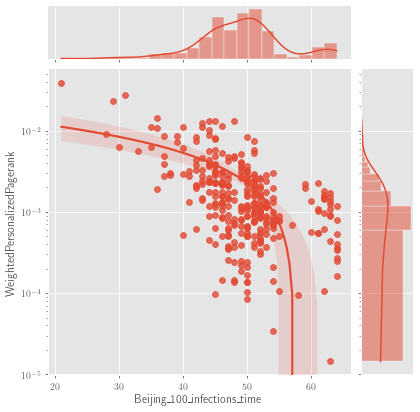

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.jointplot(x = "Beijing_100_infections_time", y = 'WeightedPersonalizedPagerank', data = p_pr_mer, kind="reg");
plt.yscale('log')

<Figure size 1680x1120 with 0 Axes>

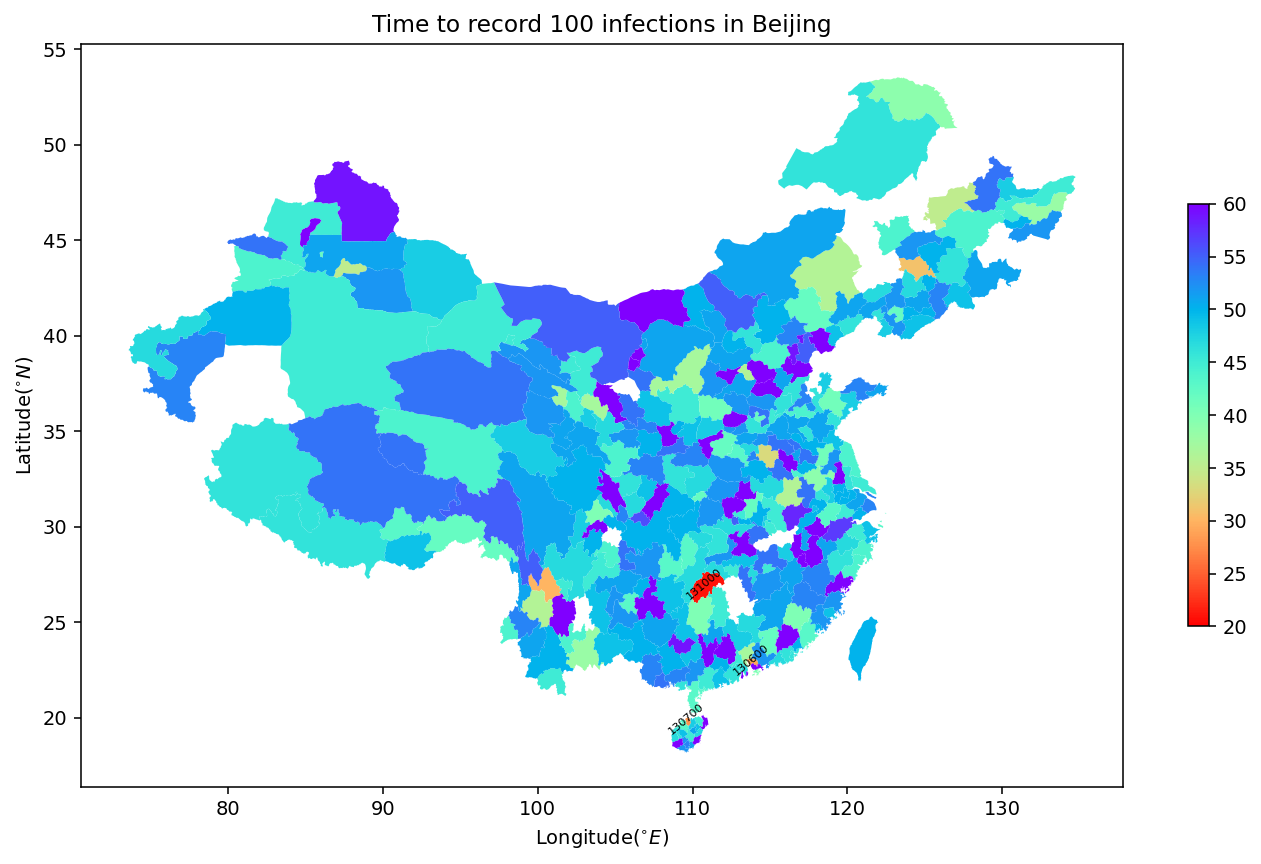

In [7]:
fig = plt.figure(figsize=(12, 8))
ax = gdf_filter.plot(column='Beijing_100_infections_time', vmin = 20, vmax= 60, 
                           cmap="rainbow_r", figsize=(12,8), legend=True, legend_kwds={'shrink': 0.5}, 
                     alpha = 1.0, markersize = 10)#rainbow, winter, jet autumn copper Reds_r
#ax = gdf_filter.plot(column='distance_from_Beijing', ax=ax, color='blue', alpha=0.5, zorder=
for idx, row in gdf_filter.iterrows():
    if(row['Beijing_100_infections_time'] < 30):
        plt.annotate(text=row['100_initial_infections_at'].split('_')[1], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
ax.set_title('Time to record 100 infections in Beijing')

ax.set_xlabel(r'Longitude($^{\circ} E$)')
ax.set_ylabel(r'Latitude($^{\circ} N$)')
ax.figure.savefig("time_to_record_100_infections_in_Beijing.png", dpi =300, transparent=False)
plt.show()

In [9]:
def filter_data(df):
    mv_ot = df
    mv_ot = mv_ot.fillna(0)
    mv_ot = mv_ot * 44520/100 #44520/100
    mv_ot_id = mv_ot.rename(columns=lambda x: x.split("_")[1])
    column_name_and_index = list(mv_ot_id.columns)
    mv_ot_id.insert(0, "tile_ID", column_name_and_index, True)
    mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id= mv_ot_id.to_numpy()
    np.fill_diagonal(mv_ot_id, 0)
    mv_ot_id = pd.DataFrame(mv_ot_id, columns=column_name_and_index)
    mv_ot_id.insert(0, "ID", column_name_and_index, True)
    #mv_ot_id = mv_ot_id.set_index('tile_ID')
    mv_ot_id['ID'] = mv_ot_id['ID'].astype(int)
    #display(mv_ot_id)
    mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tp_df['tile_ID'])].copy()
    #display(mv_ot_id_filter)
    mv_ot_id_filter['ID'] = mv_ot_id_filter['ID'].astype(str)
    col_name = mv_ot_id_filter['ID'].tolist()
    mv_ot_id_filter = mv_ot_id_filter.set_index('ID')
    mv_ot_id_filter_ro_col = mv_ot_id_filter[col_name]
    #pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
    #mv_ot_id_filter_ro_col =  mv_ot_id_filter_ro_col.set_index('ID')
    return mv_ot_id_filter




mv_ot = pd.read_csv('move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)
display(epsilon_0['131000'])
# mv_in = pd.read_csv('move_in_mean_2021_01_19_2022_01_18_.csv', index_col=0)
# epsilon_1 = filter_data(mv_in)
# #epsilon_1

# #epsilon = (epsilon_0 + epsilon_1)/2.0

ID
110000    67179.699426
120000    19200.095924
130100     2281.784900
130200     2410.232575
130300      973.785715
              ...     
653200        0.000000
654000        0.000000
654200        0.000000
654300        0.000000
659001        0.000000
Name: 131000, Length: 346, dtype: float64

In [11]:
epsilon_0_Baj = epsilon_0.iloc[0:1, 0:]
display(epsilon_0_Baj)

,110000,120000,130100,130200,130300,130400,130500,130600,130700,130800,...,653100,653200,654000,654200,654300,659001,659002,659003,659004,659006
ID,,,,,,,,,,,,,,,,,,,,,
110000,0.0,25359.555468,7203.651673,7532.764214,4123.111378,6223.936687,3242.004951,29392.626819,13329.014552,8314.023921,...,86.626275,41.572434,84.365609,24.834422,30.018053,24.021092,10.269728,7.666701,8.147816,2.868907


In [12]:
display(epsilon_0_Baj.idxmax())

110000    110000
120000    110000
130100    110000
130200    110000
130300    110000
           ...  
659001    110000
659002    110000
659003    110000
659004    110000
659006    110000
Length: 352, dtype: object

In [1]:
def tp_filter_df_with_geometry(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    epsilon_0 = epsilon_0[['ID', '110000']]
    epsilon_0 = epsilon_0.set_index('ID')
    df = df.drop('0', axis = 0)
    #display(epsilon_0)
    tp_filter = pd.concat([epsilon_0, df], axis=1)
    tp_filter = tp_filter.drop(columns ='110000')
    gdf = gpd.GeoDataFrame(tp_filter, crs="EPSG:4326", geometry='geometry')
    #display(gdf)
    return gdf


tp_for_pop_filter = tp_gdf.copy()
tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
tp_for_pop_filter['ID'] = tp_for_pop_filter['ID'].astype(str)
tp_for_pop_filter = tp_for_pop_filter.set_index('ID')
gdf_filter_0 = tp_filter_df_with_geometry(tp_for_pop_filter, epsilon_0)

gdf_filter = gdf_filter_0[1:n].copy()

gdf_filter.insert(2, 'Beijing_100_infections_time', time, True)
gdf_filter.insert(1, '100_initial_infections_at', level_1_label[1:n], True)
gdf_filter = gdf_filter.to_crs(epsg=3395)
Beijing_temp = gpd.GeoDataFrame(tp_gdf[['tile_ID', 'population', "geometry"]])
Beijing_temp_proj = Beijing_temp.to_crs(epsg=3395)
#Beijing_temp_proj
Beijing = Beijing_temp_proj.geometry[0]

distance_from_Beijing = gdf_filter.geometry.distance(Beijing)
gdf_filter.insert(4, 'distance_from_Beijing', distance_from_Beijing, True)
gdf_filter = gdf_filter.to_crs(epsg=4326)

fig = plt.figure(figsize=(12, 8))
ax = gdf_filter.plot(column='Beijing_100_infections_time', vmin = 20, vmax= 60, 
                           cmap="rainbow_r", figsize=(12,8), legend=True, legend_kwds={'shrink': 0.5}, 
                     alpha = 1.0, markersize = 10)#rainbow, winter, jet autumn copper Reds_r
#ax = gdf_filter.plot(column='distance_from_Beijing', ax=ax, color='blue', alpha=0.5, zorder=2)
for idx, row in gdf_filter.iterrows():
    if(row['Beijing_100_infections_time'] < 30):
        plt.annotate(text=row['100_initial_infections_at'].split('_')[0], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
ax.set_title('Time to record 100 infections in Beijing')

ax.set_xlabel(r'Longitude($^{\circ} E$)')
ax.set_ylabel(r'Latitude($^{\circ} N$)')
ax.figure.savefig("time_to_record_100_infections_in_Beijing.png", dpi =300, transparent=False)
plt.show()

NameError: name 'tp_gdf' is not defined

In [61]:
tp_filter

<function __main__.tp_filter(df, epsilon_0)>

In [58]:
gdf_filter

,110000,100_initial_infections_at,population,Beijing_100_infections_time,Name,geometry
ID,,,,,,
120000,26359.355467,Tianjinshi_120000,1.650580e+07,31,Tianjin Municipality,"POLYGON ((125.67162 43.25693, 125.64575 43.223..."
130100,7041.465835,Shijiazhuangshi_130100,1.116099e+07,36,Shijiazhuang,"POLYGON ((120.82834 42.24618, 120.74813 42.222..."
130200,6748.885970,Tangshanshi_130200,7.976681e+06,35,Tangshan,"POLYGON ((128.10533 48.02067, 128.13350 47.999..."
130300,4499.648550,Qinhuangdaoshi_130300,3.152924e+06,33,Qinhuangdao,"POLYGON ((114.85746 34.28204, 114.90185 34.276..."
130400,6156.416800,Handanshi_130400,9.896665e+06,37,Handan,"POLYGON ((101.90721 37.15533, 101.90529 37.093..."
...,...,...,...,...,...,...
653200,246.525614,Hetiandiqu_653200,2.409087e+06,64,Hotan Prefecture,"POLYGON ((106.78232 39.22937, 106.80653 39.186..."
654000,0.000000,Yilihasakezizhizhou_654000,2.398408e+06,54,Ili Kazak Autonomous Prefecture,"POLYGON ((106.42790 36.57240, 106.42606 36.566..."
654200,0.000000,Tachengdiqu_654200,1.349048e+06,52,Tarba?atay Prefecture,"POLYGON ((125.69674 45.52486, 125.66609 45.452..."


In [49]:
tp_gdf

,tile_ID,population,Name,geometry
0,652900,2.834335e+06,Aksu Prefecture,"POLYGON ((85.26975 45.29042, 85.29748 45.25837..."
1,654300,6.652869e+05,Altay Prefecture,"POLYGON ((91.57898 45.05081, 91.53255 44.96698..."
2,152900,2.989649e+05,Alxa League,"POLYGON ((86.10937 44.26667, 86.11806 44.11220..."
3,610900,2.588710e+06,Ankang,"POLYGON ((119.78428 46.64984, 119.86729 46.598..."
4,340800,5.501120e+06,Anqing,"POLYGON ((125.53547 40.92808, 125.46792 40.922..."
...,...,...,...,...
356,430200,4.299574e+06,Zhuzhou,"MULTIPOLYGON (((110.07875 18.49237, 110.07872 ..."
357,370300,4.985487e+06,Zibo,"MULTIPOLYGON (((110.56541 19.99486, 110.56541 ..."
358,510300,2.330002e+06,Zigong,"MULTIPOLYGON (((109.41402 18.22208, 109.41402 ..."
359,512000,2.898271e+06,Ziyang,"POLYGON ((112.72885 35.21256, 112.76003 35.172..."


In [47]:
df.to_csv('seir_meta_pop_all_stats_with_renata_shape_file.csv', index=True)

In [46]:
df

Location Beijingshi_110000                                              \
State                 S_ii          S_ij      E_ii      E_ij      I_ii   
Time                                                                     
0             2.859078e+07  0.000000e+00  0.000000  0.000000  0.000000   
1             2.827116e+07  3.196301e+05  0.000701  0.000008  0.000043   
2             2.799742e+07  5.933868e+05  0.002485  0.000053  0.000302   
3             2.776299e+07  8.278541e+05  0.005165  0.000154  0.000921   
4             2.756221e+07  1.028671e+06  0.008778  0.000328  0.002022   
...                    ...           ...       ...       ...       ...   
352           7.534026e+05  6.359256e+04  0.124184  0.010487  1.113046   
353           7.546595e+05  6.369874e+04  0.114826  0.009697  1.027732   
354           7.559163e+05  6.380491e+04  0.106176  0.008966  0.948984   
355           7.571731e+05  6.391107e+04  0.098180  0.008291  0.876295   
356           7.584298e+05  6.401723e+04  0.090788  0.007667  0.809196   

Location                                           Tianjinshi_120000  \
State             I_ij          R_ii          R_ij              S_ii   
Time                                                                   
0         0.000000e+00  0.000000e+00  0.000000e+00      1.650580e+07   
1         4.869425e-07  1.101187e-06  1.245961e-08      1.637147e+07   
2         6.434219e-06  1.586170e-05  3.286229e-07      1.625604e+07   
3         2.749686e-05  7.319021e-05  2.177782e-06      1.615686e+07   
4         7.537187e-05  2.147378e-04  8.029106e-06      1.607164e+07   
...                ...           ...           ...               ...   
352       9.402082e-02  2.564010e+07  2.165941e+06      4.397466e+05   
353       8.681418e-02  2.563893e+07  2.165842e+06      4.404772e+05   
354       8.016220e-02  2.563776e+07  2.165743e+06      4.412078e+05   
355       7.402202e-02  2.563659e+07  2.165644e+06      4.419383e+05   
356       6.835410e-02  2.563542e+07  2.165545e+06      4.426688e+05   

Location                 ... Aleitaidiqu_654300      Shihezishi_659001  \
State              S_ij  ...               R_ii R_ij              S_ii   
Time                     ...                                             
0              0.000000  ...                0.0  0.0     567132.161543   
1         134335.863575  ...                0.0  0.0     556592.078633   
2         249771.721922  ...                0.0  0.0     547634.551072   
3         348966.717095  ...                0.0  0.0     540019.771707   
4         434205.854962  ...                0.0  0.0     533544.350751   
...                 ...  ...                ...  ...               ...   
352        26982.924061  ...                0.0  0.0      15990.162516   
353        27027.782801  ...                0.0  0.0      16015.139359   
354        27072.639652  ...                0.0  0.0      16040.115208   
355        27117.494611  ...                0.0  0.0      16065.090062   
356        27162.347676  ...                0.0  0.0      16090.063921   

Location                                                           \
State             S_ij       E_ii      E_ij        I_ii      I_ij   
Time                                                                
0             0.000000   0.000000  0.000000  100.000000  0.000000   
1         10502.183469  34.193814  0.645202   91.946123  1.734900   
2         19424.173414  60.037974  2.129777   90.081580  3.194806   
3         27003.632461  81.074236  4.054265   92.587664  4.629690   
4         33442.388730  99.578939  6.241015   98.364210  6.166089   
...                ...        ...       ...         ...       ...   
352        2243.431572   0.000121  0.000017    0.000835  0.000117   
353        2246.940364   0.000112  0.000016    0.000776  0.000109   
354        2250.449015   0.000104  0.000015    0.000721  0.000101   
355        2253.957527   0.000097  0.000014    0.000670  0.000094   
356        2257.4658

/tmp/ipykernel_83629/698975958.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distance_from_Beijing = gdf_filter.geometry.distance(Beijing)
/home/rsjohn/anaconda3/envs/habitat/lib/python3.8/site-packages/geopandas/array.py:918: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/home/rsjohn/anaconda3/envs/habitat/lib/python3.8/site-packages/geopandas/array.py:919: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/home/rsjohn/anaconda3/envs/habitat/lib/python3.8/site-packages/geopandas/array.py:920: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/home/rsjohn/anaconda3/envs/habitat/lib/python3.8/site-packages/geopandas/array.py:921: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


ValueError: cannot convert float NaN to integer

<Figure size 1680x1120 with 0 Axes>

ValueError: cannot convert float NaN to integer

In [2]:
from scipy.integrate import solve_ivp, odeint
import sys
import time 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 140
import random
from collections import OrderedDict
from shapely.geometry import Polygon, LineString, Point
np.set_printoptions(linewidth=100)

renata_shape_file_relevant_column = gpd.read_file("../china_codes/spatial_match.shp") #shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code_", "pop_2020", "ADM2_EN", "geometry"]])
tp_df.columns = ['tile_ID', 'population', 'Name', 'geometry']
tp_df.reset_index(drop=True, inplace=True)
tp_gdf = tp_df.copy() # for getting the geometry
tp_df = pd.DataFrame(tp_df[['tile_ID', 'population', 'Name']])

tp_for_pop_filter = tp_df.copy()
tp_for_pop_filter = tp_for_pop_filter.rename(columns={'tile_ID': 'ID'})
tp_for_pop_filter = tp_for_pop_filter.set_index('ID')


# display(tp_for_pop_filter.index.difference(epsilon_0.index, sort=False))
# print (len(tp_for_pop_filter.index))

display(tp_for_pop_filter[tp_for_pop_filter.index.duplicated(keep=False)].sort_values(by = 'ID'))
print (len(tp_for_pop_filter.index))

,population,Name
ID,,
NaN,4.247803e+06,Fuzhou
NaN,7.435883e+06,Fuzhou
NaN,3.905459e+04,Hong Kong Special Administrative Region
NaN,1.329048e+06,Laiwu
NaN,2.794883e+06,Luohe
NaN,0.000000e+00,Macao Special Administrative Region
NaN,1.239247e+07,Suzhou
NaN,5.165731e+06,Suzhou
NaN,0.000000e+00,Taiwan province


361


<Figure size 1120x840 with 0 Axes>

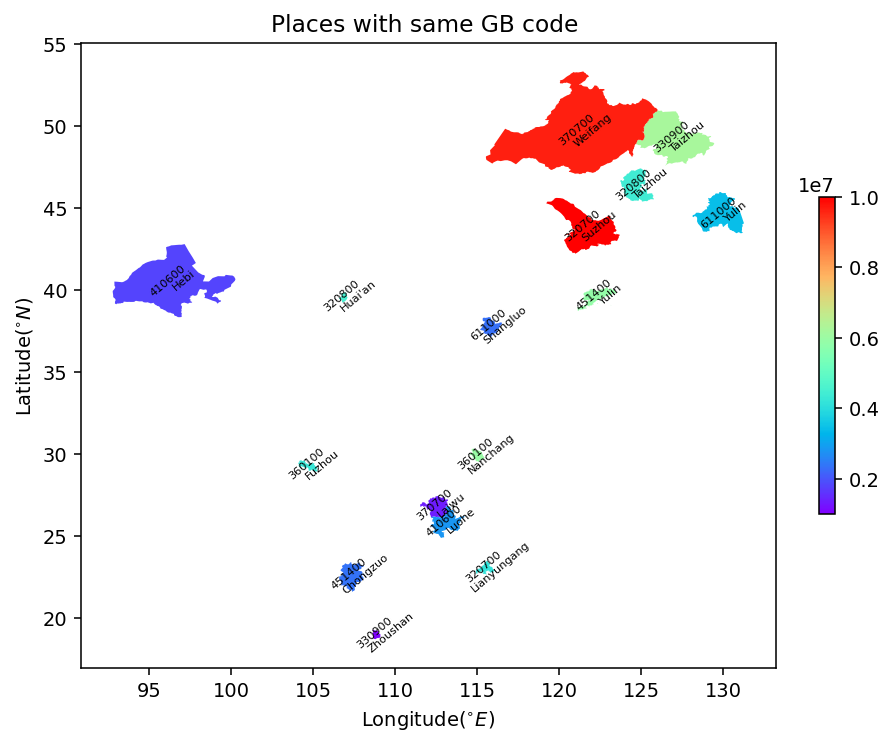

In [16]:
tp_gdf_rep = tp_gdf.set_index('tile_ID').copy()
tp_gdf_rep = tp_gdf_rep[tp_gdf_rep.index.duplicated(keep=False)]
#tp_gdf_rep
tp_gdf_rep.reset_index(drop= False, inplace = True)
fig = plt.figure(figsize=(8, 6))
ax = tp_gdf_rep.plot(column='population', vmin = 1e6, vmax= 1e7, 
                           cmap="rainbow", figsize=(8,6), legend=True, legend_kwds={'shrink': 0.5}, 
                     alpha = 1.0, markersize = 10)#rainbow, winter, jet autumn copper Reds_r
#ax = gdf_filter.plot(column='distance_from_Beijing', ax=ax, color='blue', alpha=0.5, zorder=2)
for idx, row in tp_gdf_rep.iterrows():
    if(row['population'] > 1e5):
        plt.annotate(text=row['tile_ID'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
for idx, row in tp_gdf_rep.iterrows():
    if(row['population'] > 1e5):
        plt.annotate(text=row['Name'], xy=(row['geometry'].centroid.x+1, row['geometry'].centroid.y),
                 horizontalalignment='center', rotation=40, fontsize='xx-small', color='black', wrap=True)
ax.set_title('Places with same GB code ')

ax.set_xlabel(r'Longitude($^{\circ} E$)')
ax.set_ylabel(r'Latitude($^{\circ} N$)')
ax.figure.savefig("Places_with_same_GB_code.png")
plt.show()

In [15]:
tp_gdf_rep.sort_values(by='tile_ID')

,tile_ID,population,Name,geometry
5,320700,4.145975e+06,Lianyungang,"POLYGON ((116.03070 22.93171, 116.02174 22.933..."
9,320700,1.239247e+07,Suzhou,"POLYGON ((122.22153 44.25164, 122.22691 44.246..."
3,320800,4.483264e+06,Huai'an,"POLYGON ((106.78232 39.22937, 106.76636 39.260..."
11,320800,4.376585e+06,Taizhou,"POLYGON ((125.28035 47.25538, 125.26526 47.201..."
10,330900,6.204033e+06,Taizhou,"POLYGON ((127.11095 50.87869, 127.11784 50.874..."
15,330900,6.423274e+05,Zhoushan,"MULTIPOLYGON (((108.63373 19.21749, 108.63220 ..."
1,360100,4.247803e+06,Fuzhou,"POLYGON ((105.27674 29.18481, 105.25962 29.152..."
7,360100,5.938412e+06,Nanchang,"POLYGON ((115.07461 30.24396, 115.07299 30.216..."
4,370700,1.329048e+06,Laiwu,"POLYGON ((112.94237 27.43926, 112.96783 27.375..."
12,370700,9.639713e+06,Weifang,"POLYGON ((125.98496 50.94652, 125.97784 50.917..."


In [3]:
tp_gdf

,tile_ID,population,Name,geometry
0,652900,2.834335e+06,Aksu Prefecture,"POLYGON ((85.26975 45.29042, 85.29748 45.25837..."
1,654300,6.652869e+05,Altay Prefecture,"POLYGON ((91.57898 45.05081, 91.53255 44.96698..."
2,152900,2.989649e+05,Alxa League,"POLYGON ((86.10937 44.26667, 86.11806 44.11220..."
3,610900,2.588710e+06,Ankang,"POLYGON ((119.78428 46.64984, 119.86729 46.598..."
4,340800,5.501120e+06,Anqing,"POLYGON ((125.53547 40.92808, 125.46792 40.922..."
...,...,...,...,...
356,430200,4.299574e+06,Zhuzhou,"MULTIPOLYGON (((110.07875 18.49237, 110.07872 ..."
357,370300,4.985487e+06,Zibo,"MULTIPOLYGON (((110.56541 19.99486, 110.56541 ..."
358,510300,2.330002e+06,Zigong,"MULTIPOLYGON (((109.41402 18.22208, 109.41402 ..."
359,512000,2.898271e+06,Ziyang,"POLYGON ((112.72885 35.21256, 112.76003 35.172..."


In [69]:
def gdf_tp_filter(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    tp_filter = df[df['tile_ID'].isin(epsilon_0['ID'])].copy()
    #tp_filter = tp_filter.set_index('tile_ID')
    #tp_arr = tp_filter['population'].to_numpy()
    return tp_filter

mv_ot = pd.read_csv('move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)

gdf = tp_gdf.copy()

gdf_filter_0 = gdf_tp_filter(gdf, epsilon_0)
gdf_filter = gdf_filter_0[1:n].copy()

gdf_filter

NameError: name 'n' is not defined

In [31]:
tp_df.sort_values(by='tile_ID')

,tile_ID,population,Name
23,110000,2.859078e+07,Beijing Municipality
269,120000,1.650580e+07,Tianjin Municipality
249,130100,1.116099e+07,Shijiazhuang
267,130200,7.976681e+06,Tangshan
222,130300,3.152924e+06,Qinhuangdao
...,...,...,...
1,654300,6.652869e+05,Altay Prefecture
248,659001,5.672322e+05,Shihezi
263,710100,0.000000e+00,Taiwan province
109,810100,3.905459e+04,Hong Kong Special Administrative Region


In [32]:
mv_ot_id.sort_values(by='ID')

,ID,110000,120000,130100,130200,130300,130400,130500,130600,130700,...,653100,653200,654000,654200,654300,659001,659002,659003,659004,659006
0,110000,0.000000,25359.555468,7203.651673,7532.764214,4123.111378,6223.936687,3242.004951,29392.626819,13329.014552,...,86.626275,41.572434,84.365609,24.834422,30.018053,24.021092,10.269728,7.666701,8.147816,2.868907
1,120000,26359.355467,0.000000,2933.700813,17598.856927,2726.546177,4138.745586,1464.425261,5517.671611,1636.294582,...,16.821423,23.135101,24.573623,7.458739,6.320906,7.921012,2.994708,2.393922,3.552105,1.834247
2,130100,7041.465835,2684.558336,0.000000,2303.376996,1047.537709,7325.928314,15004.535278,15142.052278,1974.451569,...,6.865498,4.018327,9.104794,3.447178,3.336129,4.836458,2.332544,1.799614,3.296686,1.825302
3,130200,6748.885970,16072.930316,2278.794997,0.000000,7946.337753,776.168008,528.469520,1814.182084,998.064888,...,5.037740,2.572922,4.814663,1.326018,2.273089,3.673898,2.434587,1.832449,1.639439,1.598560
4,130300,4499.648550,2573.606250,1022.750913,8356.333546,0.000000,256.267753,200.433124,878.675073,305.153529,...,5.450030,3.264794,4.049658,2.322399,2.130105,1.584121,1.605827,1.914013,1.469398,1.311943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,659001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.123877,...,32.589997,13.023428,380.666454,5015.103517,59.490345,0.000000,11.786824,11.054395,57.177757,4.627726
348,659002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,76.304672,99.159372,16.857171,6.129510,3.506772,12.752373,0.000000,27.964691,4.317613,4.002762
349,659003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1156.711311,11.317288,6.624529,2.801351,2.080403,10.758416,27.173799,0.000000,7.267824,2.684371
350,659004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,13.440200,6.501510,51.829046,80.877575,57.925370,59.245178,4.549773,6.996744,0.000000,2.575970


In [14]:
renata_shape_file_relevant_column.sort_values(by='flag_type')

,ADM2_EN,ADM2_PCODE,ADM1_EN,pop_2020,GB_Code_,Name_,flag_type,geometry
180,Luohe,CN041060,Henan Province,2.794883e+06,410600,None,A polygon exists but is missing flow data,"POLYGON ((113.93941 26.17724, 113.96084 26.166..."
74,Fuzhou,CN036010,Jiangxi Province,4.247803e+06,360100,None,A polygon exists but is missing flow data,"POLYGON ((105.27674 29.18481, 105.25962 29.152..."
75,Fuzhou,CN035010,Fujian Province,7.435883e+06,350100,None,A polygon exists but is missing flow data,"POLYGON ((105.42147 29.68983, 105.38770 29.644..."
109,Hong Kong Special Administrative Region,CN081010,Hong Kong Special Administrative Region,3.905459e+04,810100,None,A polygon exists but is missing flow data,"POLYGON ((106.61246 37.10888, 106.60488 37.098..."
154,Laiwu,CN037070,Shandong Province,1.329048e+06,370700,None,A polygon exists but is missing flow data,"POLYGON ((112.94237 27.43926, 112.96783 27.375..."
...,...,...,...,...,...,...,...,...
129,Jiaxing,CN033030,Zhejiang Province,5.562342e+06,330400,Jiaxingshi,none,"POLYGON ((107.71815 32.32182, 107.69729 32.263..."
128,Jiaozuo,CN041030,Henan Province,3.839205e+06,410800,Jiaozuoshi,none,"POLYGON ((105.50420 32.90392, 105.49622 32.849..."
127,Jiangmen,CN044070,Guangdong Province,4.734395e+06,440700,Jiangmenshi,none,"POLYGON ((107.67589 33.71564, 107.74325 33.713..."
135,Jincheng,CN014030,Shanxi Province,2.408314e+06,140500,Jinchengshi,none,"POLYGON ((108.82083 33.81999, 108.85586 33.776..."


In [10]:

from scipy.integrate import solve_ivp, odeint
import sys
import time 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 140
import random
from collections import OrderedDict
from shapely.geometry import Polygon, LineString, Point
np.set_printoptions(linewidth=100)

tot_t = time.time()

China_Data_Institute = gpd.read_file('../shapefiles_pop_2020/City0010/City0010_pop_2020.shp')
#print(len(China_Data_Institute))
#display(China_Data_Institute.head())
China_Data_Institute['GbCity'] = China_Data_Institute['GbCity']+'00'
#China_Data_Institute.head()
China_Data_Institute['GbCity'][0] = '110000'
China_Data_Institute['GbCity'][2] = '120000'
#China_Data_Institute.head()
tp_df = gpd.GeoDataFrame(China_Data_Institute[["GbCity", "pop_2020", "geometry"]])
tp_df.columns = ['tile_ID', 'population', 'geometry']
tp_df.reset_index(drop=True, inplace=True)
tp_gdf = tp_df.copy() # for getting the geometry
tp_df = pd.DataFrame(tp_df[['tile_ID', 'population']])

# renata_shape_file_relevant_column = gpd.read_file("../china_codes/shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
# tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code_", "pop_2020", "geometry"]])
# tp_df.columns = ['tile_ID', 'population', 'geometry']
# tp_df.reset_index(drop=True, inplace=True)
# tp_gdf = tp_df.copy() # for getting the geometry
# tp_df = pd.DataFrame(tp_df[['tile_ID', 'population']])



def filter_data(df):
    mv_ot = df
    mv_ot = mv_ot.fillna(0)
    mv_ot = mv_ot * 44520/100 #44520/100
    mv_ot_id = mv_ot.rename(columns=lambda x: x.split("_")[1])
    column_name_and_index = list(mv_ot_id.columns)
    mv_ot_id.insert(0, "tile_ID", column_name_and_index, True)
    mv_ot_id = mv_ot_id.set_index('tile_ID')


    mv_ot_id= mv_ot_id.to_numpy()
    np.fill_diagonal(mv_ot_id, 0)
    mv_ot_id = pd.DataFrame(mv_ot_id, columns=column_name_and_index)
    mv_ot_id.insert(0, "ID", column_name_and_index, True)
    #mv_ot_id = mv_ot_id.set_index('tile_ID')
    #mv_ot_id
    mv_ot_id_filter = mv_ot_id[mv_ot_id['ID'].isin(tp_df['tile_ID'])].copy()
    col_name = mv_ot_id_filter['ID']
    mv_ot_id_filter_ro_col = pd.concat([mv_ot_id_filter['ID'], mv_ot_id_filter[col_name]], axis=1)
    mv_ot_id_filter_ro_col =  mv_ot_id_filter_ro_col.set_index('ID')
    return mv_ot_id_filter_ro_col

def tp_filter(df, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    tp_filter = df[df['tile_ID'].isin(epsilon_0['ID'])].copy()
    #tp_filter = tp_filter.set_index('tile_ID')
    tp_arr = tp_filter['population'].to_numpy()
    return tp_arr

def test_id(tp_list, epsilon_0):
    epsilon_0 = epsilon_0.reset_index(drop=False)
    epsilon_list = epsilon_0['ID'].tolist()
    if tp_list == epsilon_list:
        print ("The lists are identical")
    else :
        print ("The lists are not identical")

mv_ot = pd.read_csv('move_out_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_0 = filter_data(mv_ot)
#epsilon_0
mv_in = pd.read_csv('move_in_mean_2021_01_19_2022_01_18_.csv', index_col=0)
epsilon_1 = filter_data(mv_in)
#epsilon_1


sys.exit()



/tmp/ipykernel_63563/1890856693.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  China_Data_Institute['GbCity'][0] = '110000'
/tmp/ipykernel_63563/1890856693.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  China_Data_Institute['GbCity'][2] = '120000'


SystemExit: 

/home/rsjohn/anaconda3/envs/habitat/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
epsilon_0

,110000,120000,130100,130200,130300,130400,130500,130600,130700,130800,...,652300,652700,652800,652900,653000,653100,653200,654000,654200,654300
ID,,,,,,,,,,,,,,,,,,,,,
110000,0.000000,25359.555468,7203.651673,7532.764214,4123.111378,6223.936687,3242.004951,29392.626819,13329.014552,8314.023921,...,84.995534,8.140316,127.391025,64.148319,6.209754,86.626275,41.572434,84.365609,24.834422,30.018053
120000,26359.355467,0.000000,2933.700813,17598.856927,2726.546177,4138.745586,1464.425261,5517.671611,1636.294582,1802.245817,...,28.479952,3.817905,21.735029,19.986495,2.788452,16.821423,23.135101,24.573623,7.458739,6.320906
130100,7041.465835,2684.558336,0.000000,2303.376996,1047.537709,7325.928314,15004.535278,15142.052278,1974.451569,1099.090377,...,15.664126,2.087586,27.458279,7.047817,1.963256,6.865498,4.018327,9.104794,3.447178,3.336129
130200,6748.885970,16072.930316,2278.794997,0.000000,7946.337753,776.168008,528.469520,1814.182084,998.064888,3466.941223,...,9.449549,1.756854,9.809091,5.074016,1.541611,5.037740,2.572922,4.814663,1.326018,2.273089
130300,4499.648550,2573.606250,1022.750913,8356.333546,0.000000,256.267753,200.433124,878.675073,305.153529,1071.647099,...,6.282812,1.230748,6.609929,3.611203,1.235589,5.450030,3.264794,4.049658,2.322399,2.130105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,107.610778,18.646440,343.288380,1198.634085,3005.620582,0.000000,912.269247,96.630510,32.171257,15.225741
653200,246.525614,180.851822,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,53.339216,8.534904,574.353604,298.613686,30.231026,1065.737259,0.000000,32.103060,9.699633,9.273867
654000,0.000000,0.000000,0.000000,0.000000,0.000000,71.718515,0.000000,0.000000,0.000000,0.000000,...,490.005968,646.547251,731.101676,258.017494,10.633040,96.643916,34.894203,0.000000,2828.631766,312.781355


In [2]:
from scipy.integrate import solve_ivp, odeint
import sys
import time 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
renata_shape_file_relevant_column = gpd.read_file("../china_codes/spatial_match.shp") #shape_file_only_relevant_column/shape_file_only_relevant_column.shp")
#tp_df = gpd.GeoDataFrame(renata_shape_file_relevant_column[["GB_Code_", "pop_2020", "ADM2_EN", "geometry"]])

In [3]:
renata_shape_file_relevant_column

,ADM2_EN,OBJECTID,Admin_type,Adm2_CAP,ADM2_ZH,ADM2_PCODE,ADM1_EN,ADM1_ZH,ADM1_PCODE,ADM0_EN,ADM0_ZH,ADM0_PCODE,pop_2020,GB_Code_,Name_,flag_type,geometry
0,Aksu Prefecture,23,Prefecture,Aksu City,?????,CN065020,Xinjiang Uygur Autonomous Region,????????,CN065,China,??,CN,2.834335e+06,652900.0,Akesudiqu,As there is only one polygon for multiple GB_C...,"POLYGON ((85.26975 45.29042, 85.29748 45.25837..."
1,Altay Prefecture,104,Prefecture,Altay City,?????,CN065030,Xinjiang Uygur Autonomous Region,????????,CN065,China,??,CN,6.652869e+05,654300.0,Aleitaidiqu,none,"POLYGON ((91.57898 45.05081, 91.53255 44.96698..."
2,Alxa League,107,League,"Bayanhot Elute Subdistrict, Alxa Left B",????,CN015010,Inner Mongolia Autonomous Region,??????,CN015,China,??,CN,2.989649e+05,152900.0,Alashanmeng,none,"POLYGON ((86.10937 44.26667, 86.11806 44.11220..."
3,Ankang,136,Prefecture-level city,Hanbin District,???,CN061010,Shaanxi Province,???,CN061,China,??,CN,2.588710e+06,610900.0,Ankangshi,none,"POLYGON ((119.78428 46.64984, 119.86729 46.598..."
4,Anqing,191,Prefecture-level city,Daguan District,???,CN034010,Anhui Province,???,CN034,China,??,CN,5.501120e+06,340800.0,Anqingshi,none,"POLYGON ((125.53547 40.92808, 125.46792 40.922..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,Zhuzhou,154,Prefecture-level city,Tianyuan District,???,CN043140,Hunan Province,???,CN043,China,??,CN,4.299574e+06,430200.0,Zhuzhoushi,none,"MULTIPOLYGON (((110.07875 18.49237, 110.07872 ..."
357,Zibo,323,Prefecture-level city,Zhangdian District,???,CN037170,Shandong Province,???,CN037,China,??,CN,4.985487e+06,370300.0,Ziboshi,none,"MULTIPOLYGON (((110.56541 19.99486, 110.56541 ..."
358,Zigong,75,Prefecture-level city,Ziliujing District,???,CN051200,Sichuan Province,???,CN051,China,??,CN,2.330002e+06,510300.0,Zigongshi,none,"MULTIPOLYGON (((109.41402 18.22208, 109.41402 ..."
359,Ziyang,82,Prefecture-level city,Yanjiang District,???,CN051210,Sichuan Province,???,CN051,China,??,CN,2.898271e+06,512000.0,Ziyangshi,none,"POLYGON ((112.72885 35.21256, 112.76003 35.172..."
